# Imports and functions

Importing necessary libraries used for recommendation modeling and data preprocessing.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import entropy

warnings.filterwarnings("ignore")

### Library Breakdown

- **`pandas as pd`**  
  `pandas` is a powerful data manipulation and analysis library. It provides data structures like `DataFrame` and `Series` to efficiently handle and transform tabular data.  
  **Use case:** Reading datasets, handling missing values, slicing/filtering data.

- **`numpy as np`**  
  `numpy` is used for numerical operations on large, multi-dimensional arrays and matrices. It provides mathematical functions for linear algebra, statistics, etc.  
  **Use case:** Performing matrix operations, creating vectors, and handling numerical data efficiently.

- **`from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances`**  
  These functions from `scikit-learn` are used to compute pairwise similarity or distance between rows in a matrix.  
  - `cosine_similarity`: Measures similarity between vectors based on the cosine of the angle between them.
  - `pairwise_distances`: Computes distance metrics (e.g., Euclidean, cosine) between vectors.  
  **Use case:** User-item similarity calculations in recommender systems.

- **`from sklearn.metrics import mean_squared_error, mean_absolute_error`**  
  These are evaluation metrics commonly used to assess the performance of regression models.  
  - `mean_squared_error`: Penalizes larger errors more heavily (squared).
  - `mean_absolute_error`: Penalizes all errors equally (absolute).  
  **Use case:** Measuring the accuracy of predicted ratings or numerical outputs.

- **`from tqdm import tqdm`**  
  `tqdm` is a progress bar library that makes loops show progress in a user-friendly way.  
  **Use case:** Wrapping around loops to visualize model training or data processing progress.

- **`import warnings`**  
  The `warnings` module manages warning messages. It’s used here to suppress non-critical warnings to keep the output clean.  
  **Use case:** Avoid clutter in notebook output due to library warnings.

- **`import matplotlib.pyplot as plt`**  
  `matplotlib` is a visualization library. The `pyplot` module provides functions to create plots such as line graphs, histograms, scatter plots, etc.  
  **Use case:** Visualizing model metrics, distributions, and relationships between variables.

- **`import seaborn as sns`**  
  `seaborn` is built on top of `matplotlib` and provides high-level interfaces for drawing attractive statistical graphics.  
  **Use case:** Creating heatmaps, correlation matrices, or distribution plots.

- **`from collections import defaultdict`**  
  `defaultdict` is a dictionary subclass from the `collections` module that returns a default value for missing keys.  
  **Use case:** Grouping and aggregating data without needing to check if a key already exists.

- **`from scipy.stats import entropy`**  
  The `entropy` function from `scipy.stats` calculates entropy, a measure from information theory.  
  **Use case:** Measuring unpredictability or diversity in distributions, sometimes used in fairness metrics or item diversity in recommendations.

- **`warnings.filterwarnings("ignore")`**  
  This command suppresses all warning messages during runtime to maintain clean and readable output.


## Functions

### Data loading an preprocessing

The function `load_and_preprocess_data` loads the MovieLens dataset from a specified CSV file created during the exploratory data analysis. It reads the data into a pandas DataFrame and, if the `verbose` parameter is set to `True`, it prints key statistics about the dataset, including its shape, the number of unique users and movies, and the average number of ratings per user and per movie. The function then returns the DataFrame for further analysis or modeling.

In [2]:
def load_and_preprocess_data(filepath='Datasets/combined_ratings.csv', verbose=True):
    """Load and preprocess the MovieLens dataset"""
    ratings = pd.read_csv(filepath)
    if verbose:
        print(f"Original shape: {ratings.shape}")
        print(f"Number of unique users: {ratings['UserID'].nunique()}")
        print(f"Number of unique movies: {ratings['MovieID'].nunique()}")
        print(f"Average ratings per user: {ratings.groupby('UserID')['Rating'].count().mean():.2f}")
        print(f"Average ratings per movie: {ratings.groupby('MovieID')['Rating'].count().mean():.2f}")
    return ratings

The function `filter_data` filters the ratings dataset by removing users who have rated fewer than a specified number of movies and movies that have received fewer than a specified number of ratings. It uses the `min_user_ratings` and `min_movie_ratings` thresholds to determine which users and movies to retain. If `verbose` is set to `True`, the function prints the shape of the filtered dataset, the number of users, movies, and ratings removed, as well as the density of the resulting user-movie matrix. The function returns the filtered DataFrame.

In [3]:
def filter_data(ratings, min_user_ratings=44, min_movie_ratings=50, verbose=True):
    """Filter out users and movies with too few ratings"""
    # Get counts before filtering
    n_users_before = ratings['UserID'].nunique()
    n_movies_before = ratings['MovieID'].nunique()
    n_ratings_before = len(ratings)
    
    # Filter users and movies with too few ratings
    user_counts = ratings['UserID'].value_counts()
    movie_counts = ratings['MovieID'].value_counts()
    
    filtered_ratings = ratings[ratings['UserID'].isin(user_counts[user_counts >= min_user_ratings].index)]
    filtered_ratings = filtered_ratings[filtered_ratings['MovieID'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]
    
    if verbose:
        print(f"Filtered shape: {filtered_ratings.shape}")
        print(f"Removed {n_users_before - filtered_ratings['UserID'].nunique()} users")
        print(f"Removed {n_movies_before - filtered_ratings['MovieID'].nunique()} movies")
        print(f"Removed {n_ratings_before - len(filtered_ratings)} ratings")
        print(f"Density: {len(filtered_ratings) / (filtered_ratings['UserID'].nunique() * filtered_ratings['MovieID'].nunique()) * 100:.2f}%")
    
    return filtered_ratings

The function `feature_engineering` enriches the ratings dataset by applying normalization techniques and extracting additional features. It first stores the original rating values and then normalizes the ratings based on the specified method: mean-centering, z-score, or min-max scaling. For each method, user-specific statistics such as mean, standard deviation, minimum, and maximum are computed and stored in a dictionary to enable future denormalization of predicted ratings. If no normalization is selected, the ratings remain unchanged.

In addition to normalization, the function creates a separate user features DataFrame that includes demographic information such as gender, age, and occupation. If timestamp data is available, the function extracts temporal features including day of the week, month, and year.

It returns the updated ratings DataFrame with both original and normalized ratings, the user features DataFrame indexed by `UserID`, and a dictionary containing the statistics used for normalization.

In [4]:
def feature_engineering(ratings, normalization='mean_centering'):
    """Apply feature engineering to ratings data"""
    # Store original ratings
    ratings['Rating_original'] = ratings['Rating']
    
    # Calculate and store user means for denormalization
    user_means = {}
    if normalization == 'mean_centering':
        # Calculate and store user means
        user_means = ratings.groupby('UserID')['Rating'].mean().to_dict()
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: x - x.mean())
    elif normalization == 'z_score':
        user_means_dict = ratings.groupby('UserID')['Rating'].mean().to_dict()
        user_stds_dict = ratings.groupby('UserID')['Rating'].std().to_dict()
        user_means = {'means': user_means_dict, 'stds': user_stds_dict}
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: (x - x.mean()) / x.std())
    elif normalization == 'min_max':
        user_mins = ratings.groupby('UserID')['Rating'].min().to_dict()
        user_maxs = ratings.groupby('UserID')['Rating'].max().to_dict()
        user_means = {'mins': user_mins, 'maxs': user_maxs}
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    else:  # No normalization
        ratings['Rating_normalized'] = ratings['Rating']
    
    # Create user demographic features
    user_features = ratings[['UserID', 'Gender', 'Age', 'Occupation']].drop_duplicates().set_index('UserID')
    
    # Add timestamp features if available
    if 'Timestamp' in ratings.columns:
        ratings['TimestampDT'] = pd.to_datetime(ratings['Timestamp'], unit='s')
        ratings['DayOfWeek'] = ratings['TimestampDT'].dt.dayofweek
        ratings['Month'] = ratings['TimestampDT'].dt.month
        ratings['Year'] = ratings['TimestampDT'].dt.year
    
    return ratings, user_features, user_means

The function `create_user_item_matrix` transforms the ratings dataset into a user-item interaction matrix using normalized rating values. It constructs a pivot table where each row represents a user, each column a movie, and each cell contains the normalized rating given by the user to the movie. This matrix serves as the core input for collaborative filtering algorithms.

After creating the matrix, the function computes and prints the matrix shape and sparsity level. Sparsity indicates the proportion of missing values in the matrix, which is important for understanding the density of the dataset and its implications for recommendation performance. The function returns the constructed user-item matrix.

In [5]:
def create_user_item_matrix(ratings):
    """Create user-item matrix from ratings data"""
    # Use normalized ratings for the matrix
    user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating_normalized')
    print(f"User-item matrix shape: {user_item_matrix.shape}")
    
    # Calculate sparsity
    sparsity = 1 - (np.count_nonzero(~np.isnan(user_item_matrix)) / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
    print(f"Matrix sparsity: {sparsity*100:.2f}%")
    
    return user_item_matrix

The function `train_test_split` partitions the user-item interaction matrix into training and test sets by randomly removing a subset of existing ratings. It ensures that only observed (non-missing) ratings are eligible for selection into the test set, based on a specified `test_size` proportion.

The function creates a test matrix initialized with NaNs and a corresponding mask to identify eligible entries. A random selection mechanism is applied to determine which ratings are moved to the test set. These selected values are then set to NaN in the training matrix to simulate the missing entries during model training.

For evaluation purposes, the selected test ratings are also returned in a long-format DataFrame. If the original `ratings_df` is provided, the function merges the true rating values into this long-format structure; otherwise, it assumes the normalized values represent the ground truth.

The function concludes by printing the number and proportion of ratings in the training and test sets, and returns the modified training matrix, the test matrix, and the long-format test DataFrame.

In [6]:
def train_test_split(user_item_matrix, test_size=0.2, ratings_df=None):
    """Split data into train/test sets by removing values from the matrix"""
    # Create an empty matrix for the test set
    test_matrix = pd.DataFrame(np.nan, index=user_item_matrix.index, columns=user_item_matrix.columns)
    
    # Isolate non-missing values
    rated_mask = ~user_item_matrix.isna()
    
    # Count total ratings
    total_ratings = rated_mask.sum().sum()
    
    # Create a binary matrix for selecting test ratings
    random_matrix = pd.DataFrame(
        np.random.rand(*user_item_matrix.shape),
        index=user_item_matrix.index,
        columns=user_item_matrix.columns
    )
    
    # Test mask: where ratings exist and randomly selected up to test_size
    test_mask = rated_mask & (random_matrix < test_size)
    
    # Move values from train to test
    test_matrix[test_mask] = user_item_matrix[test_mask]
    train_matrix = user_item_matrix.copy()
    train_matrix[test_mask] = np.nan
    
    # Convert test matrix to long format for easier evaluation
    # This approach handles multi-index properly
    test_indices = np.where(test_mask.values)
    test_users = [user_item_matrix.index[i] for i in test_indices[0]]
    test_movies = [user_item_matrix.columns[i] for i in test_indices[1]]
    test_ratings = test_matrix.values[test_indices]
    
    test_long = pd.DataFrame({
        'UserID': test_users,
        'MovieID': test_movies,
        'Rating_normalized': test_ratings
    })
    
    # Add original ratings if ratings_df is provided
    if ratings_df is not None:
        # Assuming ratings_df has UserID, MovieID, and Rating columns
        original_ratings = ratings_df[['UserID', 'MovieID', 'Rating']]
        test_long = test_long.merge(original_ratings, on=['UserID', 'MovieID'], how='left')
    else:
        # If no ratings dataframe provided, just copy normalized to Rating
        test_long['Rating'] = test_long['Rating_normalized']
    
    # Count train and test ratings
    train_count = train_matrix.notna().sum().sum()
    test_count = test_matrix.notna().sum().sum()
    
    print(f"Training set: {train_count} ratings ({train_count/total_ratings*100:.1f}%)")
    print(f"Test set: {test_count} ratings ({test_count/total_ratings*100:.1f}%)")
    
    return train_matrix, test_matrix, test_long

### Model building and prediction

The function `compute_similarity` generates a similarity matrix that quantifies how similar users are to each other based on their rating patterns. It begins by filling missing values in the user-item training matrix with zeros to ensure compatibility with similarity calculations.

Depending on the specified `similarity_method`, the function computes similarity using one of three strategies:
- **Cosine similarity** calculates the cosine of the angle between user rating vectors.
- **Pearson correlation** measures linear correlation, with adjustments to handle NaNs resulting from users with zero variance.
- **Jaccard similarity** compares users based on whether they rated an item or not, using a binary representation.

After computing the similarity scores, the resulting matrix is converted into a pandas DataFrame with user IDs as both rows and columns for easier interpretation and indexing. The function returns this user-user similarity DataFrame, which serves as the foundation for collaborative filtering in user-based recommender systems.

In [7]:
def compute_similarity(train_matrix, similarity_method='cosine'):
    """Compute similarity matrix between users"""
    # Fill NaNs for similarity calculation
    train_filled = train_matrix.fillna(0)
    
    if similarity_method == 'cosine':
        similarity_matrix = cosine_similarity(train_filled)
    elif similarity_method == 'pearson':
        similarity_matrix = 1 - pairwise_distances(train_filled, metric='correlation')
        # Replace NaNs (which can occur if a user has no variance)
        similarity_matrix = np.nan_to_num(similarity_matrix)
    elif similarity_method == 'jaccard':
        # Convert to binary matrix (rated or not rated)
        binary_matrix = (train_filled > 0).astype(int)
        similarity_matrix = 1 - pairwise_distances(binary_matrix, metric='jaccard')
    else:
        raise ValueError(f"Similarity method '{similarity_method}' not recognized")
    
    # Convert to DataFrame for easier indexing
    similarity_df = pd.DataFrame(
        similarity_matrix, 
        index=train_filled.index, 
        columns=train_filled.index
    )
    
    return similarity_df

The function `predict_rating` estimates a user's rating for a specific item using a user-based k-nearest neighbors (UserKNN) collaborative filtering approach. It first verifies that the user and item exist in the dataset, then identifies other users who have rated the item and computes their similarity scores with the target user using a precomputed similarity matrix.

The function filters out low similarity scores based on a `min_similarity` threshold and selects the top `k` most similar users who have rated the item. It then calculates a weighted average of these users' ratings, where the weights are the similarity scores, resulting in a normalized predicted rating.

To bring the prediction back to its original scale (i.e., undo normalization), the function adds the target user's mean rating, which was previously stored during preprocessing. This ensures that predictions are interpretable and comparable to the original rating scale. If insufficient data is available at any step, the function returns `NaN` to indicate that a reliable prediction could not be made.

In [8]:
def predict_rating(user_id, item_id, similarity_df, train_matrix, user_means, k=30, min_similarity=0):
    """Predict original-scale rating for a user-item pair using UserKNN"""
    if user_id not in similarity_df.index or item_id not in train_matrix.columns:
        return np.nan
    
    users_who_rated = train_matrix[item_id].dropna().index
    if len(users_who_rated) == 0:
        return np.nan
    
    sim_scores = similarity_df.loc[user_id, users_who_rated]
    if min_similarity > 0:
        sim_scores = sim_scores[sim_scores >= min_similarity]
    if len(sim_scores) == 0:
        return np.nan
    
    top_k_users = sim_scores.nlargest(k).index
    top_k_ratings = train_matrix.loc[top_k_users, item_id].dropna()
    top_k_sims = similarity_df.loc[user_id, top_k_ratings.index]
    
    if len(top_k_ratings) == 0 or top_k_sims.sum() == 0:
        return np.nan
    
    weighted_sum = (top_k_ratings * top_k_sims).sum()
    sim_sum = top_k_sims.sum()
    pred_normalized = weighted_sum / sim_sum

    # Add back user's mean rating to return to original scale
    user_mean = user_means.get(user_id, 0)
    
    # Return the denormalized prediction
    return pred_normalized + user_mean

### Model evaluation and tuning

The function `tune_hyperparameters` performs a grid search to identify the optimal combination of hyperparameters for the UserKNN recommendation model. Specifically, it evaluates different values of `k` (the number of neighbors) and `min_similarity` (the minimum similarity threshold for neighbor inclusion). The function iterates over all combinations of these parameters and evaluates performance on a subset of the test dataset.

For each configuration, it predicts ratings using the `predict_rating` function, compares them to the actual ratings (using original ratings when available), and calculates evaluation metrics including RMSE, MAE, and coverage. These results are stored and later summarized in a DataFrame to facilitate analysis.

To ensure robustness and efficiency, the function uses a sample of up to 10,000 test cases and displays a progress bar to track progress. The best hyperparameter combination is determined by the lowest RMSE, and the function returns both the full results and the optimal `k` and `min_similarity` values. This process helps fine-tune the UserKNN model for maximum predictive accuracy.

In [9]:
def tune_hyperparameters(test_long, similarity_df, train_matrix, user_means, k_values=None, similarity_thresholds=None):
    """Perform grid search to find optimal hyperparameters"""
    if k_values is None:
        k_values = list(range(5, 51, 5))
    
    if similarity_thresholds is None:
        similarity_thresholds = [0]  # By default, don't filter by similarity
    
    results = []
    
    print("Tuning hyperparameters...")
    # Progress bar for combinations
    total_combinations = len(k_values) * len(similarity_thresholds)
    progress_bar = tqdm(total=total_combinations)
    
    for k in k_values:
        for min_sim in similarity_thresholds:
            predictions = []
            actuals = []
            
            # Sample only a portion of test data for faster tuning if the dataset is large
            sample_size = min(10000, len(test_long))
            test_sample = test_long.sample(n=sample_size, random_state=42) if len(test_long) > sample_size else test_long
            
            for row in test_sample.itertuples(index=False):
                # Unpack based on column structure
                if 'Rating_normalized' in test_long.columns and 'Rating' in test_long.columns:
                    uid, iid, norm_rating, original_rating = row
                else:
                    uid, iid, rating = row
                    norm_rating = rating
                    original_rating = rating
                
                # Get prediction
                pred = predict_rating(uid, iid, similarity_df, train_matrix, user_means, k=k, min_similarity=min_sim)
                
                if not np.isnan(pred):
                    predictions.append(pred)
                    actuals.append(original_rating)  # Use original rating for comparison
            
            if len(predictions) > 0:
                rmse = mean_squared_error(actuals, predictions, squared=False)
                mae = mean_absolute_error(actuals, predictions)
                coverage = len(predictions) / len(test_sample) * 100
                results.append((k, min_sim, rmse, mae, coverage))
                print(f"k={k}, min_sim={min_sim:.2f} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {coverage:.1f}%")
            else:
                print(f"k={k}, min_sim={min_sim:.2f} → No valid predictions")
            
            progress_bar.update(1)
    
    progress_bar.close()
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['k', 'min_similarity', 'rmse', 'mae', 'coverage'])
    
    # Find best parameters based on RMSE
    best_idx = results_df['rmse'].idxmin()
    best_k = results_df.loc[best_idx, 'k']
    best_min_sim = results_df.loc[best_idx, 'min_similarity']
    best_rmse = results_df.loc[best_idx, 'rmse']
    
    print(f"\n Best parameters: k={best_k}, min_similarity={best_min_sim:.2f} with RMSE: {best_rmse:.4f}")
    
    return results_df, best_k, best_min_sim

The function `evaluate_model` assesses the performance of a UserKNN recommendation model on a test dataset using specified hyperparameters. It takes the similarity matrix, training matrix, and test data (in long format), along with the user's mean ratings, and computes predictions for each user-item pair.

Predictions are generated by the `predict_rating` function, and can be calculated on the entire test set or a random sample for efficiency. The function collects predicted ratings alongside actual ratings to compute key evaluation metrics: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and coverage (the percentage of test cases for which a prediction was made).

In addition to returning a detailed evaluation DataFrame containing actual and predicted ratings (including absolute and signed errors), the function also prints a summary of prediction statistics and alerts if any predicted values fall outside the expected rating scale (e.g., outside 1–5). This makes it easier to identify outliers or anomalies in model behavior during evaluation.

In [10]:
def evaluate_model(test_long, similarity_df, train_matrix, user_means, k, min_similarity=0, sample_size=None, ratings_df=None):
    """
    Evaluate model on test set using best parameters
    """
    print(f"\nEvaluating final model with k={k}, min_similarity={min_similarity}")
    
    predictions = []
    actuals = []
    user_item_pairs = []
    
    # Use a sample or the full test set
    test_data = test_long
    if sample_size and len(test_long) > sample_size:
        test_data = test_long.sample(n=sample_size, random_state=42)
    
    # Progress bar
    print("Generating predictions...")
    for row in tqdm(test_data.itertuples(index=False)):
        # Unpack based on column structure
        if len(row) >= 4:  # If we have normalized and original ratings
            uid, iid, norm_rating, true_rating = row
        else:
            uid, iid, true_rating = row
        
        # Use original prediction function
        pred = predict_rating(uid, iid, similarity_df, train_matrix, user_means, k=k, min_similarity=min_similarity)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(true_rating)
            user_item_pairs.append((uid, iid))
    
    # Calculate metrics only if we have predictions
    if len(predictions) > 0:
        rmse = mean_squared_error(actuals, predictions, squared=False)
        mae = mean_absolute_error(actuals, predictions)
        coverage = len(predictions) / len(test_data) * 100
        
        print(f"\nFinal Evaluation Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Coverage: {coverage:.2f}%")
        
        # Create prediction-actual pairs DataFrame
        eval_df = pd.DataFrame({
            'UserID': [pair[0] for pair in user_item_pairs],
            'MovieID': [pair[1] for pair in user_item_pairs],
            'Actual': actuals,
            'Predicted': predictions,
            'Error': [a - p for a, p in zip(actuals, predictions)],
            'AbsError': [abs(a - p) for a, p in zip(actuals, predictions)]
        })
        
        # Add histogram of predictions to see their distribution
        print("\nPrediction distribution:")
        print(pd.Series(predictions).describe())
        
        # Check for extreme predictions
        extreme_preds = [p for p in predictions if p < 1 or p > 5]
        if extreme_preds:
            print(f"\nFound {len(extreme_preds)} extreme predictions outside the 1-5 range")
            print(f"Min prediction: {min(predictions):.2f}")
            print(f"Max prediction: {max(predictions):.2f}")
        
        return rmse, mae, coverage, eval_df
    else:
        print("No valid predictions made")
        return None, None, 0, None

### Visualization

The function `plot_tuning_results` visualizes the results of the hyperparameter tuning process for a UserKNN recommendation model. It plots the Root Mean Squared Error (RMSE) against the number of neighbors `k` for each tested similarity threshold, helping to compare model performance across configurations.

Each line in the plot corresponds to a different minimum similarity threshold (`min_similarity`), allowing for easy comparison of how RMSE varies with `k` under different constraints. The function also highlights the best-performing configuration by drawing a vertical dashed line at the optimal `k` value, annotated with the corresponding `min_similarity`.

The plot is useful for identifying trends, such as diminishing returns with increasing `k` or the impact of stricter similarity requirements. The function returns the matplotlib figure object for further customization or saving.

In [11]:
def plot_tuning_results(results_df):
    """Plot hyperparameter tuning results"""
    # RMSE vs k for each similarity threshold
    plt.figure(figsize=(12, 6))
    
    for min_sim in results_df['min_similarity'].unique():
        subset = results_df[results_df['min_similarity'] == min_sim]
        plt.plot(subset['k'], subset['rmse'], marker='o', linestyle='-', 
                 label=f'min_sim={min_sim:.2f}')
    
    # Highlight best k
    best_idx = results_df['rmse'].idxmin()
    best_k = results_df.loc[best_idx, 'k']
    best_sim = results_df.loc[best_idx, 'min_similarity']
    
    plt.axvline(x=best_k, color='red', linestyle='--', 
                label=f'Best k={best_k}, min_sim={best_sim:.2f}')
    
    plt.title('RMSE vs. Number of Neighbors (k)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.xticks(sorted(results_df['k'].unique()))
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()  # Return the current figure

The function `plot_error_distribution` visualizes the distribution of prediction errors in a recommendation model. It creates a histogram based on the `Error` column of the evaluation DataFrame, which represents the difference between actual and predicted ratings.

The plot includes a vertical dashed red line at zero to indicate the ideal prediction point (no error). Additionally, it computes and displays summary statistics such as the mean and standard deviation of the errors, which are annotated in the plot for quick interpretation.

This visualization is helpful for assessing model bias (e.g., consistently over- or under-predicting) and the spread of errors, offering insights into the model's accuracy and reliability. The function returns the matplotlib figure object for further use or saving.

In [12]:
def plot_error_distribution(eval_df):
    """Plot distribution of prediction errors"""
    plt.figure(figsize=(12, 6))
    
    # Create a histogram of errors
    plt.hist(eval_df['Error'], bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='red', linestyle='--')
    
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Count')
    plt.grid(True)
    
    # Add error statistics as text
    mean_error = eval_df['Error'].mean()
    std_error = eval_df['Error'].std()
    
    plt.annotate(f'Mean Error: {mean_error:.4f}\nStd Dev: {std_error:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt.gcf()

The function `plot_actual_vs_predicted` visualizes the relationship between actual and predicted ratings using a scatter plot. To improve readability in dense areas, it adds random jitter to both axes. If the evaluation dataset is large, it samples up to 1,000 points to maintain clarity.

The plot includes a red dashed identity line (where predicted equals actual) to indicate perfect prediction. The function also computes the Pearson correlation coefficient between actual and predicted ratings and displays it within the plot.

This visualization helps assess model calibration—whether predictions are systematically biased or well-aligned with true values—and is a useful diagnostic tool for understanding model behavior. The function returns the matplotlib figure object for further use.

In [13]:
def plot_actual_vs_predicted(eval_df, sample_size=1000):
    """Plot actual vs predicted ratings"""
    plt.figure(figsize=(10, 10))
    
    # Sample if there are too many points
    if len(eval_df) > sample_size:
        plot_df = eval_df.sample(sample_size, random_state=42)
    else:
        plot_df = eval_df
    
    # Create scatter plot with jitter
    x_jitter = np.random.normal(0, 0.1, size=len(plot_df))
    y_jitter = np.random.normal(0, 0.1, size=len(plot_df))
    
    plt.scatter(plot_df['Actual'] + x_jitter, 
                plot_df['Predicted'] + y_jitter, 
                alpha=0.5)
    
    # Add identity line
    min_val = min(plot_df['Actual'].min(), plot_df['Predicted'].min())
    max_val = max(plot_df['Actual'].max(), plot_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title('Actual vs Predicted Ratings')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.grid(True)
    
    # Add correlation coefficient
    corr = plot_df['Actual'].corr(plot_df['Predicted'])
    plt.annotate(f'Correlation: {corr:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt.gcf()

### Demographic analysis

The function `evaluate_demographic_subsets` assesses the performance of a recommender system across different demographic groups. It merges the evaluation dataset with user demographic information—such as gender, age group, or occupation—and then computes key error metrics for each subgroup.

For each demographic attribute specified in `demo_cols`, the function groups users accordingly and calculates the RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), number of predictions, and the relative proportion of the group in the full evaluation set. This allows for a nuanced understanding of how well the model performs across diverse user segments.

The function prints a detailed summary for each demographic group and returns a nested dictionary containing the computed metrics. This is particularly valuable for analyzing fairness and identifying systematic biases in model performance.

In [14]:
def evaluate_demographic_subsets(eval_df, ratings_df, demo_cols=['Gender', 'AgeDesc', 'OccupationDesc']):
    """Evaluate model performance across different demographic subsets"""
    if eval_df is None or len(eval_df) == 0:
        print("No evaluation data available")
        return None
    
    if ratings_df is None:
        print("No demographic data available")
        return None
    
    # Get unique user information with demographics
    user_demo = ratings_df[['UserID'] + demo_cols].drop_duplicates()
    
    # Merge with evaluation data
    eval_with_demo = eval_df.merge(user_demo, on='UserID', how='left')
    
    # Initialize results dictionary
    demo_metrics = {}
    
    # Analyze each demographic dimension
    for col in demo_cols:
        print(f"\n=== Evaluation by {col} ===")
        groups = eval_with_demo.groupby(col)
        
        col_metrics = {}
        for group_name, group_data in groups:
            group_rmse = mean_squared_error(group_data['Actual'], group_data['Predicted'], squared=False)
            group_mae = mean_absolute_error(group_data['Actual'], group_data['Predicted'])
            group_count = len(group_data)
            group_pct = group_count / len(eval_with_demo) * 100
            
            col_metrics[group_name] = {
                'rmse': group_rmse,
                'mae': group_mae,
                'count': group_count,
                'percentage': group_pct
            }
            
            print(f"  {col}={group_name}: RMSE={group_rmse:.4f}, MAE={group_mae:.4f}, Count={group_count} ({group_pct:.1f}%)")
        
        demo_metrics[col] = col_metrics
    
    return demo_metrics

The function `plot_demographic_metrics` visualizes error metrics such as RMSE or MAE across different demographic groups, enabling interpretable comparisons of model performance. It takes as input the output of `evaluate_demographic_subsets` and creates a separate plot for each demographic dimension (e.g., Gender, Age Group, Occupation).

Depending on the number of groups within each demographic, the function dynamically chooses between vertical and horizontal bar charts to ensure readability. Metric values are annotated with the number of users (`n`) in each group, providing context to the plotted results.

Each subplot is clearly labeled and styled for interpretability, making this function an effective tool for identifying potential disparities or biases in recommender system performance across demographic segments.

In [15]:
def plot_demographic_metrics(demo_metrics, metric='rmse'):
    """
    Plot metrics by demographic groups with improved readability for many groups

    Parameters:
    -----------
    demo_metrics : dict
        Dictionary with metrics for each demographic group (from evaluate_demographic_subsets)
    metric : str
        Metric to plot ('rmse' or 'mae')

    Returns:
    --------
    fig : matplotlib figure
        Figure with demographic evaluation plots
    """
    if demo_metrics is None:
        return None

    # Determine number of subplots needed
    n_plots = len(demo_metrics)
    if n_plots == 0:
        return None

    # Set up the figure
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    if n_plots == 1:
        axes = [axes]  # Make iterable for single plot case

    # Create a plot for each demographic dimension
    for i, (demo_col, groups) in enumerate(demo_metrics.items()):
        group_names = list(groups.keys())
        metric_values = [groups[g][metric] for g in group_names]
        counts = [groups[g]['count'] for g in group_names]

        # Sort by metric value
        sorted_indices = np.argsort(metric_values)
        sorted_names = [group_names[i] for i in sorted_indices]
        sorted_values = [metric_values[i] for i in sorted_indices]
        sorted_counts = [counts[i] for i in sorted_indices]

        ax = axes[i]

        # Use horizontal bar plot if there are many groups (e.g., occupations)
        if len(sorted_names) > 10:
            bars = ax.barh(sorted_names, sorted_values, color='skyblue')
            for j, bar in enumerate(bars):
                ax.text(
                    bar.get_width() + 0.01,
                    bar.get_y() + bar.get_height()/2,
                    f"n={sorted_counts[j]}",
                    va='center',
                    fontsize=8
                )
            ax.set_xlabel(metric.upper())
            ax.set_ylabel(demo_col)
        else:
            bars = ax.bar(sorted_names, sorted_values, color='skyblue')
            for j, bar in enumerate(bars):
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    f"n={sorted_counts[j]}",
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
            ax.set_ylabel(metric.upper())
            ax.set_xlabel(demo_col)
            if len(sorted_names) > 5:
                ax.set_xticklabels(sorted_names, rotation=45, ha='right')

        ax.set_title(f"{metric.upper()} by {demo_col}")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig

The function `analyze_rating_distribution_by_demographic` explores how different demographic groups—such as gender, age, or occupation—tend to rate movies on average. It processes the input ratings dataset and computes the mean rating and count of ratings for each subgroup within the specified demographic columns.

For each demographic dimension, the function generates a separate bar chart displaying the average rating per group. Bars are annotated with the number of ratings (`n`) in each category, offering insight into the sample size behind each average. The function also applies visual enhancements like y-axis gridlines and conditional rotation of x-axis labels to improve clarity, especially for groups with many categories.

This visualization is useful for identifying systematic differences in rating behavior across user demographics, helping to inform fairness analyses or personalization strategies in recommendation systems.

In [16]:
def analyze_rating_distribution_by_demographic(ratings_df, demo_cols=['Gender', 'AgeDesc', 'OccupationDesc']):
    """Analyze how different demographic groups rate movies"""
    if ratings_df is None:
        print("No ratings data available")
        return None
    
    # Determine number of subplots needed
    n_plots = len(demo_cols)
    if n_plots == 0:
        return None
    
    # Set up the figure
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    if n_plots == 1:
        axes = [axes]  # Make it iterable for single plot case
    
    # Create a plot for each demographic dimension
    for i, demo_col in enumerate(demo_cols):
        # Group by demographic and calculate mean rating
        group_means = ratings_df.groupby(demo_col)['Rating'].mean().sort_values()
        group_counts = ratings_df.groupby(demo_col)['Rating'].count()
        
        # Sort groups by mean rating
        sorted_groups = group_means.index
        sorted_means = group_means.values
        sorted_counts = group_counts[sorted_groups].values
        
        # Create bar chart
        bars = axes[i].bar(sorted_groups, sorted_means, color='lightgreen')
        
        # Add count annotations
        for j, bar in enumerate(bars):
            axes[i].text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.05,
                f"n={sorted_counts[j]}",
                ha='center',
                va='bottom',
                fontsize=8
            )
        
        # Customize the plot
        axes[i].set_title(f"Mean Rating by {demo_col}")
        axes[i].set_xlabel(demo_col)
        axes[i].set_ylabel("Mean Rating")
        axes[i].set_ylim(0, 5.5)  # Ratings are typically 1-5
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotate x-axis labels if there are many groups
        if len(sorted_groups) > 5:
            axes[i].set_xticklabels(sorted_groups, rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

The function `evaluate_model_by_demographic` assesses the performance of a UserKNN recommendation model across different demographic groups, such as gender or age. It merges predicted ratings with demographic attributes, computes standard error metrics (RMSE, MAE), and reports the proportion of users in each group.

Groups exhibiting significantly higher error than average are flagged as "problematic." If similarity matrices, training data, and test samples are provided, the function conducts additional analysis for these problematic groups by tuning the number of nearest neighbors (`k`). It evaluates multiple `k` values to determine which setting yields the lowest RMSE for each underperforming demographic segment.

The function returns a dictionary of evaluation results for each group, optionally enriched with the best `k` value and its corresponding RMSE for groups requiring adjustment. This approach provides both diagnostic insights and practical guidance for improving fairness and accuracy across user subpopulations.

In [17]:
def evaluate_model_by_demographic(eval_df, ratings_df, demographic_field, k=30, 
                                 user_means=None, similarity_df=None, train_matrix=None, test_long=None):
    """
    Evaluate model performance for specific demographic groups
    
    Parameters:
    -----------
    eval_df : DataFrame
        Evaluation results with predictions
    ratings_df : DataFrame
        Original ratings with demographic information
    demographic_field : str
        Demographic field to analyze (e.g., 'Gender', 'AgeDesc')
    k : int, default=30
        Number of neighbors for UserKNN
    user_means : dict
        Dictionary mapping user IDs to their mean ratings
    similarity_df : DataFrame, optional
        User similarity matrix (for running custom predictions)
    train_matrix : DataFrame, optional
        Training data matrix (for running custom predictions)
    test_long : DataFrame, optional
        Test data in long format for custom predictions
        
    Returns:
    --------
    dict
        Dictionary with metrics for each demographic group
    """
    if eval_df is None or len(eval_df) == 0:
        print("No evaluation data available")
        return None
    
    if ratings_df is None:
        print("No demographic data available")
        return None
    
    # Get unique user information with demographics
    user_demo = ratings_df[['UserID', demographic_field]].drop_duplicates()
    
    # Merge with evaluation data
    eval_with_demo = eval_df.merge(user_demo, on='UserID', how='left')
    
    # Group by demographic
    demo_groups = eval_with_demo.groupby(demographic_field)
    
    results = {}
    problematic_groups = []
    
    print(f"\n=== Detailed Evaluation by {demographic_field} ===")
    for group_name, group_data in demo_groups:
        # Calculate basic metrics
        group_rmse = mean_squared_error(group_data['Actual'], group_data['Predicted'], squared=False)
        group_mae = mean_absolute_error(group_data['Actual'], group_data['Predicted'])
        group_count = len(group_data)
        group_pct = group_count / len(eval_with_demo) * 100
        
        # Check if this group has particularly high error
        if group_rmse > 1.2 * np.mean([r['rmse'] for r in results.values()]) if results else False:
            problematic_groups.append(group_name)
        
        # Store results
        results[group_name] = {
            'rmse': group_rmse,
            'mae': group_mae,
            'count': group_count,
            'percentage': group_pct
        }
        
        print(f"  {demographic_field}={group_name}: RMSE={group_rmse:.4f}, MAE={group_mae:.4f}, Count={group_count} ({group_pct:.1f}%)")
    
    # If we found problematic groups and have the similarity matrix and training data
    if problematic_groups and similarity_df is not None and train_matrix is not None and test_long is not None:
        print(f"\nFound problematic groups with high error: {problematic_groups}")
        print("Analyzing optimal k values for these groups...")
        
        for group_name in problematic_groups:
            # Get users in this group
            group_users = user_demo[user_demo[demographic_field] == group_name]['UserID'].unique()
            
            # Get test data for these users
            group_test_data = test_long[test_long['UserID'].isin(group_users)]
            
            if len(group_test_data) == 0:
                print(f"No test data available for {demographic_field}={group_name}")
                continue
            
            # Try different k values
            k_values = [5, 10, 15, 20, 30, 40, 50, 75, 100]
            k_results = []
            
            for test_k in k_values:
                predictions = []
                actuals = []
                
                # Sample for faster tuning
                sample_size = min(1000, len(group_test_data))
                test_sample = group_test_data.sample(n=sample_size, random_state=42) if len(group_test_data) > sample_size else group_test_data
                
                for row in test_sample.itertuples(index=False):
                    # Handle both 3-column and 4-column formats
                    if len(row) >= 4:
                        uid, iid, norm_rating, true_rating = row
                    else:
                        uid, iid, true_rating = row
                    
                    # Call predict_rating with proper parameters including user_means
                    pred = predict_rating(uid, iid, similarity_df, train_matrix, user_means, k=test_k)
                    
                    if not np.isnan(pred):
                        predictions.append(pred)
                        actuals.append(true_rating)
                
                if len(predictions) > 0:
                    group_rmse = mean_squared_error(actuals, predictions, squared=False)
                    k_results.append((test_k, group_rmse))
                    print(f"  {demographic_field}={group_name}, k={test_k} → RMSE: {group_rmse:.4f}")
            
            if k_results:
                best_k, best_rmse = min(k_results, key=lambda x: x[1])
                print(f"  Best k for {demographic_field}={group_name}: k={best_k} with RMSE: {best_rmse:.4f}")
                results[group_name]['optimal_k'] = best_k
                results[group_name]['optimal_rmse'] = best_rmse
    
    return results

### Fairness metrics

#### Individual fairness metrics

##### Gini coefficient

The function `get_top_n_userknn` extracts the top-N recommended items per user from an evaluation DataFrame generated by a UserKNN model. The input DataFrame must contain four columns: `UserID`, `MovieID`, `Predicted`, and `Actual`.

For each user, the function first aggregates all their predicted movie ratings along with the corresponding actual ratings into a dictionary. It then sorts each user's list of recommendations in descending order based on the predicted rating (i.e. the estimated preference generated by the model). After sorting, it selects the top `n` items—those the model believes the user would rate highest.

The result is a dictionary where each key is a user ID, and the value is a list of up to `n` tuples in the format `(MovieID, PredictedRating, ActualRating)`. These sorted tuples represent the model’s most confident recommendations for each user, which can then be used for calculating precision-based metrics (e.g., precision at N or Gini coefficient). This approach provides an interpretable snapshot of which items the model prioritizes for individual users based on learned similarity patterns.

In [18]:
def get_top_n_userknn(eval_df, n=10):
    """
    Return top-N recommendations per user from UserKNN evaluation DataFrame.
    Expected columns: ['UserID', 'MovieID', 'Predicted', 'Actual']
    """
    top_n = defaultdict(list)
    
    for row in eval_df.itertuples(index=False):
        top_n[row.UserID].append((row.MovieID, row.Predicted, row.Actual))
    
    # Sort by predicted score and keep top N
    for uid, recs in top_n.items():
        recs.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = recs[:n]
    
    return top_n

The function `calculate_user_precision` computes the **precision score per user** based on their top-N recommended items. It is compatible with both **UserKNN** and **Surprise-style** recommendation outputs, assuming the input is a dictionary where each key is a `UserID` and each value is a list of tuples in the format `(MovieID, PredictedRating, ActualRating)`.

For each user, the function iterates over their top-N recommendations and counts how many of the actual ratings meet or exceed a specified relevance threshold (default is `3.5`, meaning items rated 3.5 or higher are considered "relevant" to the user). The **precision** is then calculated as:

**Precision per user** = Number of relevant items / Total items recommended

Only users who have at least one recommendation are included in the output. The result is a dictionary mapping each user ID to their individual precision score, which can later be used to compute **aggregate performance**, **fairness metrics** (e.g., Gini coefficient), or other personalized evaluation statistics.

In [19]:
def calculate_user_precision(top_n, threshold=3.5):
    """Calculate precision per user (UserKNN or Surprise-style)."""
    user_precisions = {}
    for uid, user_recs in top_n.items():
        if not user_recs:
            continue
        relevant = sum(1 for _, _, true_r in user_recs if true_r >= threshold)
        user_precisions[uid] = relevant / len(user_recs)
    return user_precisions

The function `gini_coefficient` measures **inequality** within a distribution by computing the **Gini coefficient**, a standard metric used in economics and fairness evaluations. It takes a list or array of numeric values (e.g., user precisions or predicted ratings) and returns a value between **0** and **1**:

- A Gini coefficient of **0** indicates perfect equality (all values are the same).
- A Gini coefficient of **1** indicates perfect inequality (one entity holds all the value).

**Calculation Steps:**
1. Convert the input list to a NumPy array and sort it in ascending order.
2. Compute the cumulative sum of the sorted values.
3. Use the formula:

 **Gini** =  
   $$∑[(2 * i − n − 1) × xᵢ] / (n × total_sum)$$  
   
- where:
    - *i* ranges from 1 to *n* (number of elements)
    - *xᵢ* is the *i*-th sorted value, and  
    - *total_sum* is the sum of all values.

The function safely handles edge cases where the input array is empty or all values are zero by returning 0.

This metric is especially useful when analyzing **fairness in recommendation systems**, where you want to check if some users consistently receive better recommendations than others.

In [20]:
def gini_coefficient(values):
    """Calculate the Gini coefficient to measure inequality in a distribution."""
    values = np.array(values)
    sorted_vals = np.sort(values)
    n = len(values)
    if n == 0 or np.sum(values) == 0:
        return 0
    cumulative = np.cumsum(sorted_vals)
    return np.sum((2 * np.arange(1, n+1) - n - 1) * sorted_vals) / (n * cumulative[-1])

The function `plot_lorenz_curve` visualizes inequality in a distribution using a **Lorenz curve**, which is commonly used to illustrate income or opportunity disparities. It plots the cumulative proportion of a value (e.g., precision, income) against the cumulative proportion of users, sorted from lowest to highest value.

**Key Steps:**
1. **Preparation**:  
   - Convert the input values into a NumPy array and sort them in ascending order.
   - Compute the cumulative sum of the sorted values and normalize it to range from 0 to 1.
   - Generate the corresponding cumulative percentages (x-axis).

2. **Gini Calculation (optional)**:  
   If `show_gini=True`, the function calculates the **Gini coefficient** using the `gini_coefficient` function and displays it in the plot title.

3. **Plotting**:
   - **Lorenz Curve**: The curve starts at (0, 0) and shows the cumulative share of the total value held by the bottom x% of users.
   - **Line of Equality**: A 45-degree dashed line representing perfect equality (everyone has the same value).
   - **Shaded Area**: The area between the line of equality and the Lorenz curve is shaded to visually emphasize inequality.

**Interpretation:**
- The **closer the Lorenz curve is to the line of equality**, the more equal the distribution.
- A **larger area between the curves** indicates more inequality.
- The **Gini coefficient** quantifies this area, and the function displays it in the title when requested.

In [21]:
def plot_lorenz_curve(values, title="Lorenz Curve", show_gini=True, figsize=(8, 6)):
    values = np.array(values)
    sorted_vals = np.sort(values)
    cumvals = np.cumsum(sorted_vals)
    cumvals = cumvals / cumvals[-1] if cumvals[-1] > 0 else np.zeros_like(cumvals)
    cumperc = np.linspace(0, 1, len(values) + 1)

    gini = gini_coefficient(values) if show_gini else None

    plt.figure(figsize=figsize)
    plt.plot(cumperc, np.insert(cumvals, 0, 0), label="Lorenz Curve", color="blue", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Line of Equality")
    plt.fill_between(cumperc, np.insert(cumvals, 0, 0), np.linspace(0, 1, len(values)+1),
                     color="red", alpha=0.2, label="Inequality Area")
    plt.xlabel("Cumulative % of Users")
    plt.ylabel("Cumulative % of Total Value")
    plt.title(f"{title}\nGini Coefficient: {gini:.4f}" if gini is not None else title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

The function `evaluate_gini_userKNN` assesses fairness in UserKNN recommendations by computing the **Gini coefficient** of precision across users. It measures how evenly relevant recommendations are distributed, providing insight into potential inequality in recommendation outcomes.

**Key Steps:**
1. **Group Predictions by User**:  
   The function first groups all `(MovieID, Predicted, Actual)` tuples per user from the evaluation DataFrame.

2. **Select Top-N Recommendations**:  
   For each user, it sorts the predictions by predicted score (descending) and retains only the top-N items, forming the user’s personal recommendation list.

3. **Calculate User Precision**:  
   Using `calculate_user_precision`, it computes the precision for each user:
   $$
   \text{Precision}_u = \frac{\text{Number of relevant items}}{N}
   $$
   where an item is considered relevant if the actual rating is greater than or equal to a specified `threshold`.

4. **Compute Gini Coefficient**:  
   The Gini coefficient is calculated over the list of user precisions to quantify inequality. A value of 0 implies perfect equality (all users receive the same level of relevant recommendations), while a value close to 1 implies high inequality.

5. **Visualization (optional)**:  
   If `plot=True`, a Lorenz curve is generated using `plot_lorenz_curve` to visualize the distribution of user precisions and the inequality area.

**Interpretation:**
- This function highlights **whether certain users consistently receive better recommendations** (in terms of relevance) than others.
- A **lower Gini value** suggests fairer distribution across users, while a **higher value** may indicate bias or concentration of good recommendations in a small group.

In [22]:
def evaluate_gini_userKNN(eval_df, threshold=3.5, top_n_size=5, plot=True):
    """Evaluate Gini fairness for UserKNN predictions."""
    user_predictions = defaultdict(list)
    for row in eval_df.itertuples(index=False):
        user_predictions[row.UserID].append((row.MovieID, row.Predicted, row.Actual))

    top_n = {}
    for uid, recs in user_predictions.items():
        sorted_recs = sorted(recs, key=lambda x: x[1], reverse=True)
        top_n[uid] = sorted_recs[:top_n_size]

    user_precisions = calculate_user_precision(top_n, threshold=threshold)
    gini = gini_coefficient(list(user_precisions.values()))

    print(f"=== Gini Coefficient Fairness Metric (UserKNN) ===")
    print(f"Gini Coefficient: {gini:.4f} (0 = perfect equality, 1 = perfect inequality)")
    print(f"Calculated across {len(user_precisions)} users with top-{top_n_size} recommendations")
    print(f"Relevance threshold: Rating >= {threshold}")

    if plot:
        plot_lorenz_curve(list(user_precisions.values()),
                          title="Lorenz Curve of Recommendation Precision (UserKNN)",
                          show_gini=True)

    return gini, user_precisions

##### Bottom N-average

The function `calculate_bottom_n_average` computes the average of the lowest `n` values in a given dataset. It accepts different input types, including NumPy arrays, Pandas Series, or DataFrames. If a DataFrame is provided, the column to evaluate must be explicitly specified. The function first converts the input into a NumPy array, then sorts the values in ascending order. It selects the bottom `n` values and calculates their mean. If `n` exceeds the dataset size, it adjusts `n` to match the number of available values. It returns both the average and the list of bottom `n` values used in the computation.

In [23]:
def calculate_bottom_n_average(data, n=10, column=None):
    """
    Calculate the average of the bottom N values in a dataset.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    n : int, default 10
        Number of bottom values to include in the average
    column : str, optional
        If data is a DataFrame, the column to use for calculation
        
    Returns:
    --------
    float
        The average of the bottom N values
    list
        The bottom N values used in the calculation
    """
    # Handle different input types
    if isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Column name must be specified when input is a DataFrame")
        values = data[column].values
    elif isinstance(data, pd.Series):
        values = data.values
    else:
        values = np.array(data)
    
    # Make sure n is not larger than the dataset
    n = min(n, len(values))
    
    # Sort the values and get the bottom n
    sorted_values = np.sort(values)
    bottom_n = sorted_values[:n]
    
    # Calculate the average
    bottom_n_avg = np.mean(bottom_n)
    
    return bottom_n_avg, bottom_n.tolist()

The function `calculate_user_average_predicted_ratings` computes the average predicted rating per user based on a provided evaluation DataFrame. By default, it groups the data by the `'UserID'` column and calculates the mean of the `'Predicted'` values, but alternative column names can be specified using the `user_column` and `value_column` parameters. The output is a Pandas Series indexed by user, where each entry represents that user's average predicted rating. This function is useful for analyzing how the recommender system's predictions vary across users.

In [24]:
def calculate_user_average_predicted_ratings(eval_df, user_column='UserID', value_column='Predicted'):
    """
    Calculate the average predicted rating for each user from the evaluation DataFrame.
    
    Parameters:
    -----------
    eval_df : pd.DataFrame
        DataFrame containing model evaluation results
    user_column : str, default='UserID'
        Column containing user identifiers
    value_column : str, default='Predicted'
        Column containing the predicted values
        
    Returns:
    --------
    pd.Series
        Series containing average predicted value for each user
    """
    return eval_df.groupby(user_column)[value_column].mean()

The function `plot_bottom_n_comparison` visualizes how the average of the lowest N values in a dataset compares across different N values. It accepts input data in the form of an array, Series, or DataFrame. If a DataFrame is provided, the specific column for analysis must be indicated with the `column` parameter. For each specified `n` in the list `ns`, the function calculates the average of the bottom N values using `calculate_bottom_n_average`. It also computes the overall average of the dataset for comparison.

The results are displayed as a bar chart, where each bar represents the average of the bottom N values, and one additional bar shows the overall average. The chart includes value labels for clarity, and is styled with soft colors and a grid for better readability. This visualization helps to understand how much lower the bottom-performing segments are compared to the overall distribution.

In [25]:
def plot_bottom_n_comparison(data, ns=[5, 10, 20, 50], column=None, title="Bottom N Average Comparison"):
    """
    Plot a comparison of different bottom N averages.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    ns : list of int, default [5, 10, 20, 50]
        List of N values to compare
    column : str, optional
        If data is a DataFrame, the column to use for calculation
    title : str, default "Bottom N Average Comparison"
        Title for the plot
    """
    averages = []
    labels = []
    
    # Calculate averages for different values of n
    for n in ns:
        avg, _ = calculate_bottom_n_average(data, n, column)
        averages.append(avg)
        labels.append(f"Bottom {n}")
    
    # Add overall average for comparison
    if isinstance(data, pd.DataFrame) and column is not None:
        overall_avg = data[column].mean()
    elif isinstance(data, pd.Series):
        overall_avg = data.mean()
    else:
        overall_avg = np.mean(data)
    
    averages.append(overall_avg)
    labels.append("Overall")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, averages, color=['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0', '#ffcc99'])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    
    plt.title(title)
    plt.ylabel("Average Predicted Rating")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

The function `plot_user_rating_distribution` creates a histogram that visualizes the distribution of average predicted ratings across users. It takes as input a `pandas.Series` containing per-user average ratings and optionally allows customization of the number of histogram bins through the `bins` parameter.

The plot displays the frequency of users across rating intervals and includes two reference lines: one for the overall average predicted rating (in red), and one for the bottom 10% average (in green), computed using the `calculate_bottom_n_average` function. These lines provide insight into central tendency and how the lowest-performing users differ from the general population. The visualization helps assess the fairness and spread of predictions across the user base.

In [26]:
def plot_user_rating_distribution(user_avg_ratings, bins=20):
    """
    Plot the distribution of average ratings across users.
    
    Parameters:
    -----------
    user_avg_ratings : pd.Series
        Series containing average rating for each user
    bins : int, default=20
        Number of bins for the histogram
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of user average ratings
    plt.hist(user_avg_ratings, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add lines for overall average and bottom-N averages
    overall_avg = user_avg_ratings.mean()
    plt.axvline(overall_avg, color='red', linestyle='--', linewidth=2, label=f'Overall Average: {overall_avg:.2f}')
    
    # Add bottom-10% average
    bottom_10_percent = len(user_avg_ratings) // 10
    bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, bottom_10_percent)
    plt.axvline(bottom_n_avg, color='green', linestyle='--', linewidth=2, 
                label=f'Bottom 10% Average: {bottom_n_avg:.2f}')
    
    plt.title('Distribution of Average Predicted Ratings Across Users')
    plt.xlabel('Average Predicted Rating')
    plt.ylabel('Number of Users')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The function `evaluate_bottom_n_fairness` assesses individual fairness by analyzing how users with the lowest average predicted ratings are treated by the model. It computes the average predicted rating for each user from the evaluation DataFrame and then focuses on both fixed-size and percentage-based "bottom-N" user groups.

For each bottom-N group (e.g., bottom 5 users or bottom 10% of users), the function calculates their average predicted rating and compares it to the overall average across all users. This comparison highlights disparities in how well the model serves the least-advantaged users. The function prints these metrics, computes disparity values (absolute and percentage-based), and visualizes the results using two plots:
1. A bar chart comparing bottom-N averages and the overall average.
2. A histogram showing the distribution of user average predicted ratings, with markers for key summary statistics.

The output is a dictionary that contains all calculated averages, disparities, and the full user-level prediction distribution for further analysis. This fairness evaluation provides insight into how equitably the recommender system distributes its recommendations across users.

In [27]:
def evaluate_bottom_n_fairness(eval_df, ns=[5, 10, 20, 50], user_column='UserID', value_column='Predicted'):
    """
    Evaluate bottom-N average as an individual fairness metric.
    
    Parameters:
    -----------
    eval_df : pd.DataFrame
        DataFrame with model evaluation results
    ns : list, default=[5, 10, 20, 50]
        List of N values to analyze
    user_column : str, default='UserID'
        Column containing user identifiers
    value_column : str, default='Predicted'
        Column containing the values to analyze
    
    Returns:
    --------
    dict
        Dictionary containing bottom-N analysis results
    """
    results = {}
    
    # Calculate average rating per user
    user_avg_ratings = calculate_user_average_predicted_ratings(
        eval_df, user_column, value_column)
    
    # Number of users
    num_users = len(user_avg_ratings)
    
    # Calculate percentage-based N values
    percent_ns = [1, 5, 10, 20]
    count_ns = [max(1, int(num_users * p / 100)) for p in percent_ns]
    
    print("=== Bottom-N Average Individual Fairness Metric ===")
    print(f"Total number of users: {num_users}")
    
    # Fixed-count bottom N
    for n in ns:
        if n < num_users:
            bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, n)
            print(f"Bottom {n} users average: {bottom_n_avg:.4f}")
            results[f'bottom_{n}_avg'] = bottom_n_avg
    
    # Percentage-based bottom N
    for p, n in zip(percent_ns, count_ns):
        bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, n)
        print(f"Bottom {p}% of users ({n} users) average: {bottom_n_avg:.4f}")
        results[f'bottom_{p}percent_avg'] = bottom_n_avg
    
    # Overall average for comparison
    overall_avg = user_avg_ratings.mean()
    print(f"Overall average across all users: {overall_avg:.4f}")
    results['overall_avg'] = overall_avg
    
    # Calculate disparities
    for p in percent_ns:
        disparity = overall_avg - results[f'bottom_{p}percent_avg']
        disparity_percent = (disparity / overall_avg) * 100
        print(f"Disparity between overall and bottom {p}%: {disparity:.4f} ({disparity_percent:.1f}%)")
        results[f'disparity_{p}percent'] = disparity
        results[f'disparity_{p}percent_ratio'] = disparity_percent
    
    # Plot bottom-N comparison
    plot_bottom_n_comparison(user_avg_ratings, count_ns, 
                           title=f"Bottom N% Users Average Rating Comparison")
    plt.show()
    
    # Plot distribution of user average ratings
    plot_user_rating_distribution(user_avg_ratings)
    plt.show()
    
    # Store the full user average ratings for further analysis
    results['user_avg_ratings'] = user_avg_ratings
    
    return results

#### Group fairness metrics

##### N1-Norm

The function `compute_user_metrics` calculates detailed performance metrics at the individual user level based on a model’s prediction results. Given a DataFrame containing actual and predicted ratings, it groups the data by user and computes various metrics that capture both accuracy and behavioral aspects of the predictions.

For each user, the following metrics are calculated:
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the prediction errors.
- **MAE (Mean Absolute Error)**: Represents the average absolute difference between actual and predicted ratings.
- **Average Predicted Rating**: The mean of all predicted ratings made for the user.
- **Average True Rating**: The mean of all true ratings provided by the user.
- **Prediction Variance**: Captures how much the predicted ratings vary across items for the user.
- **Average Error**: The average of the signed differences (Actual - Predicted), indicating bias direction.
- **Number of Predictions**: Total number of items rated or predicted for the user.

The result is returned as a DataFrame, where each row corresponds to a user and the columns contain the computed metrics. This function is useful for diagnosing how consistently and fairly the model performs across its user base.

In [28]:
def compute_user_metrics(eval_df, user_col='UserID', pred_col='Predicted', true_col='Actual'):
    """
    Compute user-level metrics from evaluation DataFrame.
    
    Parameters:
    -----------
    eval_df : pd.DataFrame
        DataFrame with evaluation results
    user_col : str, default='UserID'
        Column containing user identifiers
    pred_col : str, default='Predicted'
        Column containing predicted ratings
    true_col : str, default='Actual'
        Column containing true ratings
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with user-level metrics
    """
    # Group by user
    user_metrics = []
    
    for user, group in eval_df.groupby(user_col):
        # Calculate RMSE
        rmse = np.sqrt(np.mean((group[pred_col] - group[true_col])**2))
        
        # Calculate MAE
        mae = np.mean(np.abs(group[pred_col] - group[true_col]))
        
        # Calculate average predicted rating
        avg_pred = group[pred_col].mean()
        
        # Calculate average true rating
        avg_true = group[true_col].mean()
        
        # Calculate prediction variance
        pred_var = group[pred_col].var()
        
        # Calculate average error
        avg_error = (group[true_col] - group[pred_col]).mean()
        
        # Store metrics
        user_metrics.append({
            user_col: user,
            'RMSE': rmse,
            'MAE': mae,
            'avg_pred': avg_pred,
            'avg_true': avg_true,
            'pred_variance': pred_var,
            'avg_error': avg_error,
            'num_predictions': len(group)
        })
    
    # Create DataFrame
    user_metrics_df = pd.DataFrame(user_metrics)
    
    return user_metrics_df

The function `compute_user_distribution` analyzes how a specific user-level metric (e.g., RMSE, average predicted rating) is distributed across different demographic groups within a dataset. It is designed to help compare the fairness or performance of a model across segments such as gender, age groups, or occupations.

It operates as follows:
- **Bin Definition**: It divides the range of the target metric into a specified number of bins, which are used to construct histograms.
- **Overall Distribution**: It computes the overall distribution of the metric across all users using a normalized histogram (`density=True`) and calculates summary statistics such as the mean, median, and user count.
- **Group-Level Analysis**: For each unique value in the demographic column (e.g., each gender), it calculates:
  - The histogram of the target metric for that group.
  - The group-specific mean, median, and count.

The function returns:
- A dictionary of distributions (`distributions`), where keys are group names and values are arrays representing histogram frequencies.
- An array of `bin_centers` for plotting or analysis.
- A dictionary of group-level statistics (`group_stats`) including mean, median, and sample size per group.

This function is particularly useful in fairness assessments, enabling comparisons of how a model’s performance varies between demographic groups.

In [29]:
def compute_user_distribution(df, column, group_col='Gender', bins=20):
    """
    Compute the distribution of a user-level metric across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with user metrics and demographic information
    column : str
        Column to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for the distribution
    
    Returns:
    --------
    dict, numpy.ndarray, dict
        Distributions, bin centers, and group statistics
    """
    # Define bins
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_hist, _ = np.histogram(df[column], bins=bin_edges, density=True)
    overall_mean = df[column].mean()
    overall_median = df[column].median()
    
    # Initialize results
    distributions = {'overall': overall_hist}
    group_stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(df)}}
    
    # Calculate distribution and statistics for each group
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        group_hist, _ = np.histogram(group_data[column], bins=bin_edges, density=True)
        group_mean = group_data[column].mean()
        group_median = group_data[column].median()
        
        distributions[group] = group_hist
        group_stats[group] = {
            'mean': group_mean, 
            'median': group_median,
            'count': len(group_data)
        }
    
    return distributions, bin_centers, group_stats

The function `compute_n1_norm_from_distributions` calculates the **N1-norm** (also known as the **L1 distance**) between the normalized distribution of each group and the overall distribution. This metric provides a quantitative measure of how much each group's distribution diverges from the overall population, making it useful for assessing **distributional fairness**.

**How it works:**
- **Input**: A dictionary of distributions where:
  - `'overall'` is the key for the total population’s normalized histogram.
  - Each remaining key represents a demographic group (e.g., Gender, Age).
- **Distance Calculation**:
  - For each group, it computes the **absolute difference** between that group’s histogram and the overall histogram.
  - These differences are summed and then divided by 2 to ensure the result lies between 0 (identical distributions) and 1 (maximally dissimilar).
- **Output**: A dictionary where each key is a group name and the value is the computed N1-norm.

This function is especially useful in fairness analysis to detect disparities in how different groups are treated by a model, based on how their metric distributions differ from the overall user base.

In [30]:
def compute_n1_norm_from_distributions(distributions):
    """
    Compute N1-norm (L1 distance) between distributions.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary mapping group names to their distributions (numpy arrays)
    
    Returns:
    --------
    dict
        Dictionary mapping each group to its N1-norm distance from the overall distribution
    """
    # Get overall distribution as reference
    overall_dist = distributions['overall']
    
    # Initialize results
    n1_results = {}
    
    # Compute N1-norm for each group
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Calculate absolute differences and sum them
        abs_diff = np.abs(dist - overall_dist)
        n1_norm = np.sum(abs_diff) / 2  # Divide by 2 to normalize between 0 and 1
        
        n1_results[group] = n1_norm
    
    return n1_results

The function `plot_combined_n1_norm_results` visualizes **distributional disparities** across multiple user-level metrics using the **N1-norm** (L1 distance). It generates a grouped bar chart where each bar represents how much a demographic group’s metric distribution diverges from the overall population, facilitating comparative fairness analysis across metrics.

**How it works:**
- **Inputs**:
  - `n1_results_dict`: A nested dictionary where each key is a metric (e.g., `'RMSE'`, `'avg_pred'`), and each value is another dictionary with group names and their corresponding N1-norm scores.
  - `group_col`: The name of the demographic feature (e.g., `'Gender'`, `'AgeDesc'`).
  - `metrics`: A list of metrics for which the N1-norms were computed.

- **Data Preparation**:
  - All results are flattened into a single DataFrame suitable for seaborn’s grouped bar chart.

- **Visualization**:
  - Each bar shows the N1-norm (distribution difference) for a group-metric combination.
  - Horizontal reference lines are included at 0.1 and 0.2 to mark **moderate** and **large** disparities.
  - Value labels are added above the bars for clarity.

- **Purpose**:
  - This plot helps to quickly identify which demographic groups show the most deviation from the norm across selected user-level evaluation metrics, and whether the model exhibits any distributional unfairness in its predictions.

This visualization supports **user-level fairness diagnostics**, particularly in highlighting whether certain demographic groups are consistently treated differently by the model.

In [31]:
def plot_combined_n1_norm_results(n1_results_dict, group_col, metrics):
    """
    Create a combined bar chart showing N1-norm results for multiple metrics.
    
    Parameters:
    -----------
    n1_results_dict : dict
        Dictionary with N1-norm results for each metric
    group_col : str
        Name of the demographic column
    metrics : list
        List of metrics being analyzed
    """
    # Prepare data for plotting
    plot_data = []
    for metric in metrics:
        for group, value in n1_results_dict[metric].items():
            plot_data.append({
                'Group': group,
                'Metric': metric,
                'N1-norm': value
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Group', y='N1-norm', hue='Metric', data=plot_df)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.xlabel(f'{group_col}')
    plt.ylabel('N1-norm (Distribution Difference)')
    plt.title(f'User-Focused Fairness: N1-norm by {group_col}')
    
    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Moderate Difference (0.1)')
    plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.6, label='Large Difference (0.2)')
    
    # Add legend with better placement
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The function `plot_distribution_comparison` visualizes how the distribution of a selected **user-level metric** (e.g., RMSE, MAE, average predicted rating) differs across **demographic groups**, supporting fairness analysis through visual inspection of density curves.

**How it works:**
- **Inputs**:
  - `distributions`: A dictionary containing normalized histogram values (density estimates) for each group, including an `'overall'` baseline.
  - `bin_centers`: The midpoint values of the bins used for the histogram, used on the x-axis.
  - `stats`: Summary statistics for each group (mean, median, count), which are used for annotations and vertical reference lines.
  - `group_col`: The name of the demographic feature being analyzed (e.g., `"Gender"` or `"AgeDesc"`).
  - `metric`: The user-level metric being visualized (e.g., `"RMSE"`, `"avg_pred"`).

- **Visualization**:
  - Plots the overall metric distribution as a **black line**.
  - Plots group-specific distributions with **distinct colors** and overlays their **mean values** as dashed vertical lines.
  - Each group’s mean is also shown in the legend for easy comparison.

- **Purpose**:
  - This plot highlights differences in how a model performs across groups, such as whether a particular demographic group consistently receives higher or lower prediction errors.
  - It is especially useful for spotting **systematic bias** or **unequal performance** across user segments.

This visualization is an essential component in diagnosing **demographic fairness** in recommendation systems or regression models.

In [32]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Plot distribution comparison between demographic groups for a specific metric.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    plt.figure(figsize=(10, 6))
    
    # Plot overall distribution as a line
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=2, label=f'Overall (mean={stats["overall"]["mean"]:.2f})')
    
    # Plot each group distribution
    colors = plt.cm.tab10.colors[:len(distributions) - 1]
    i = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
        plt.plot(bin_centers, dist, '-', color=colors[i], 
                 linewidth=2, label=f'{group} (mean={stats[group]["mean"]:.2f})')
        i += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.5)
    i = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[i], linestyle='--', alpha=0.5)
        i += 1
    
    plt.xlabel(f'User {metric}')
    plt.ylabel('Density')
    plt.title(f'Distribution of User {metric} by {group_col}')
    plt.legend(title=group_col)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

The function `evaluate_n1_norm_fairness` measures **group fairness** by comparing the distribution of user-level metrics (e.g., RMSE, MAE) across demographic groups using the **N1-norm** (L1 distance). It highlights how different groups are treated compared to the overall population.

**Key steps:**
- Computes user-level metrics from prediction results.
- Merges user metrics with demographic info.
- For each demographic field and selected metric:
  - Calculates normalized distributions.
  - Computes N1-norm between each group and the overall distribution.
  - Classifies disparities as low (<0.1), moderate (0.1–0.2), or high (>0.2).

**Output:**
- N1-norm values per group and metric.
- Bar plots showing group disparities.
- Distribution plots comparing group vs. overall fairness.

This helps identify whether certain user groups receive consistently different model treatment.

In [33]:
def evaluate_n1_norm_fairness(eval_df, ratings_df, metrics=None, demographic_fields=None, bins=20):
    """
    Evaluate N1-norm as a group fairness metric using pre-calculated user metrics.
    
    Parameters:
    -----------
    eval_df : pd.DataFrame
        DataFrame with model evaluation results
    ratings_df : pd.DataFrame
        DataFrame with user demographic information
    metrics : list, optional
        List of metrics to analyze (default is RMSE, MAE, avg_pred)
    demographic_fields : list, optional
        List of demographic fields to analyze (default is Gender, AgeDesc, OccupationDesc)
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with N1-norm results for each demographic group and metric
    pd.DataFrame
        DataFrame with user metrics and demographic information
    """
    if metrics is None:
        metrics = ['RMSE', 'MAE', 'avg_pred']
    
    if demographic_fields is None:
        demographic_fields = ['Gender', 'AgeDesc', 'OccupationDesc']
        # Keep only fields that exist in the ratings dataframe
        demographic_fields = [field for field in demographic_fields if field in ratings_df.columns]
    
    # Calculate user-level metrics
    user_metrics_df = compute_user_metrics(eval_df)
    
    # Merge user metrics with demographic information
    user_demo_info = ratings_df[['UserID'] + demographic_fields].drop_duplicates()
    user_metrics_with_demo = user_metrics_df.merge(user_demo_info, on='UserID', how='left')
    
    # Initialize results
    results = {}
    
    print("=== N1-Norm Group Fairness Metric ===")
    
    # Analyze for each demographic field
    for demo_field in demographic_fields:
        print(f"\nAnalyzing {demo_field} fairness:")
        
        field_results = {}
        all_n1_results = {}
        
        # For each metric, compute distributions and N1-norm
        for metric in metrics:
            # Compute distributions
            distributions, bin_centers, stats = compute_user_distribution(
                user_metrics_with_demo, column=metric, group_col=demo_field, bins=bins)
            
            # Calculate N1-norm
            n1_results = compute_n1_norm_from_distributions(distributions)
            
            # Store results
            field_results[metric] = {
                'distributions': distributions,
                'bin_centers': bin_centers,
                'stats': stats,
                'n1_results': n1_results
            }
            
            all_n1_results[metric] = n1_results
            
            # Print results
            print(f"\n  {metric} distribution N1-norm:")
            for group, n1_value in n1_results.items():
                interpretation = "low" if n1_value < 0.1 else "moderate" if n1_value < 0.2 else "high"
                mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                mean_diff_pct = (mean_diff / stats['overall']['mean']) * 100 if stats['overall']['mean'] != 0 else 0
                print(f"    {group}: {n1_value:.4f} ({interpretation} difference)")
                print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
        
        # Store all results for this demographic field
        results[demo_field] = field_results
        
        # Create visualizations
        plot_combined_n1_norm_results(all_n1_results, demo_field, metrics)
        plt.show()
        
        # Distribution plots for key metrics
        for metric in metrics[:2]:  # Limit to first 2 metrics to avoid too many plots
            plot_distribution_comparison(
                field_results[metric]['distributions'],
                field_results[metric]['bin_centers'],
                field_results[metric]['stats'],
                demo_field,
                metric
            )
            plt.show()
    
    return results, user_metrics_with_demo

##### KL-divergence

The function `compute_kl_divergence_user_metric` quantifies distributional differences in a user-level metric (such as `RMSE` or `avg_pred`) across demographic groups using divergence measures like **KL divergence**, **reverse KL divergence**, and **Jensen-Shannon divergence**.

**What it does:**
- **Inputs**:
  - `df`: A DataFrame with user-level metrics and demographic labels.
  - `column`: The name of the metric to evaluate (e.g., `'avg_pred'`).
  - `group_col`: The demographic column to group by (default is `'Gender'`).
  - `bins`: The number of histogram bins to approximate probability distributions (default is 20).

**Step-by-step process:**
1. **Discretization**:
   - Defines equal-width bins over the range of the selected metric.
   - Calculates the normalized histogram (PDF) for the **overall population** with added smoothing (`epsilon`) to avoid zero probabilities.

2. **Group-level Evaluation**:
   For each demographic group:
   - Computes a smoothed and normalized histogram.
   - Stores basic statistics (mean, median, count).
   - Calculates:
     - **KL divergence** from group to overall distribution: \( D_{KL}(P \| Q) \)
     - **Reverse KL divergence** from overall to group: \( D_{KL}(Q \| P) \)
     - **Jensen-Shannon divergence** (symmetric and bounded):  
       $$
       JS(P \| Q) = \frac{1}{2} D_{KL}(P \| M) + \frac{1}{2} D_{KL}(Q \| M), \quad M = \frac{1}{2}(P + Q)
       $$

**Output:**
- `kl_results`: A dictionary containing divergence scores per group.
- `stats`: Group-wise descriptive statistics (mean, median, count).
- `distributions`: Normalized distributions for each group.
- `bin_centers`: The midpoints of each histogram bin, useful for plotting.

This function is useful for evaluating **distributional fairness**, identifying whether specific groups deviate in how predictions are distributed relative to the general population.

In [34]:
def compute_kl_divergence_user_metric(df, column, group_col='Gender', bins=20):
    """
    Compute KL divergence between distributions of a user-level metric across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with user metrics and demographic information
    column : str
        Column name for the metric to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for histogram approximation
    
    Returns:
    --------
    dict, dict, dict, numpy.ndarray
        KL divergence results, group statistics, distributions, and bin centers
    """    
    # Define bins for the metric
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_values = df[column].values
    overall_hist, _ = np.histogram(overall_values, bins=bin_edges, density=True)
    overall_mean = np.mean(overall_values)
    overall_median = np.median(overall_values)
    
    # Apply smoothing to avoid zero probabilities (which cause KL-div to be undefined)
    epsilon = 1e-10
    overall_hist = overall_hist + epsilon
    overall_hist = overall_hist / overall_hist.sum()  # Re-normalize
    
    # Initialize results
    kl_results = {}
    stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(df)}}
    distributions = {'overall': overall_hist}
    
    # Compute KL divergence for each group
    for group in df[group_col].unique():
        group_values = df[df[group_col] == group][column].values
        
        if len(group_values) == 0:
            continue
            
        # Calculate statistics
        group_mean = np.mean(group_values)
        group_median = np.median(group_values)
        
        # Store stats
        stats[group] = {
            'mean': group_mean,
            'median': group_median,
            'count': len(group_values)
        }
        
        # Calculate distribution
        group_hist, _ = np.histogram(group_values, bins=bin_edges, density=True)
        
        # Apply smoothing
        group_hist = group_hist + epsilon
        group_hist = group_hist / group_hist.sum()  # Re-normalize
        
        # Store distribution
        distributions[group] = group_hist
        
        # Calculate KL divergence: D_KL(P||Q) where P=group dist, Q=overall dist
        kl_div = entropy(group_hist, overall_hist)
        kl_results[group] = kl_div
        
        # Also calculate reverse KL divergence: D_KL(Q||P)
        reverse_kl = entropy(overall_hist, group_hist)
        kl_results[f"{group}_reverse"] = reverse_kl
        
        # Calculate symmetric Jensen-Shannon divergence
        m_dist = 0.5 * (group_hist + overall_hist)
        js_div = 0.5 * (entropy(group_hist, m_dist) + entropy(overall_hist, m_dist))
        kl_results[f"{group}_js"] = js_div
    
    return kl_results, stats, distributions, bin_centers

The `plot_kl_divergence_results` function visualizes KL divergence values between demographic group distributions and the overall distribution for a given user-level metric. It creates a bar chart showing how much each group's distribution diverges.

- **Inputs**:  
  - `kl_results`: Dictionary with KL divergence values.  
  - `group_col`: Demographic field (e.g., `"Gender"`).  
  - `metric`: Metric being analyzed (e.g., `"avg_pred"`).

- **What it does**:  
  Filters out reverse and JS divergences, plots forward KL divergences, and adds reference lines for interpreting divergence levels (0.1 = low, 0.5 = moderate, 1.0 = high).

- **Output**:  
  Returns a `matplotlib` figure showing group-wise divergence from the overall distribution, helping to assess fairness across demographic subgroups.

In [35]:
def plot_kl_divergence_results(kl_results, group_col, metric):
    """
    Plot KL divergence results with appropriate scale.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence results
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    # Filter out any non-standard KL divergence values (reverse, JS, etc.)
    standard_kl = {k: v for k, v in kl_results.items() 
                 if not ('_reverse' in k or '_js' in k)}
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Group': list(standard_kl.keys()),
        'KL Divergence': list(standard_kl.values())
    })
    
    # Determine appropriate y-axis limit with padding
    max_val = plot_df['KL Divergence'].max()
    y_limit = max_val * 1.3  # Add 30% padding
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Use color palette for better distinction
    colors = plt.cm.Set2(np.linspace(0, 1, len(plot_df)))
    bars = plt.bar(plot_df['Group'], plot_df['KL Divergence'], color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (y_limit * 0.02),
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel(f'{group_col}')
    plt.ylabel('KL Divergence')
    plt.title(f'Distribution Divergence for {metric} by {group_col}')
    
    # Set y-axis limit to make bars more visible
    plt.ylim(0, y_limit)
    
    # Add reference lines with interpretive text
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3)
    plt.text(len(plot_df) * 0.02, 0.1 + (y_limit * 0.02), 
             'Low Divergence (0.1)', color='r', alpha=0.7)
    
    if y_limit > 0.5:
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        plt.text(len(plot_df) * 0.02, 0.5 + (y_limit * 0.02), 
                 'Moderate Divergence (0.5)', color='r', alpha=0.7)
    
    if y_limit > 1.0:
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
        plt.text(len(plot_df) * 0.02, 1.0 + (y_limit * 0.02), 
                 'High Divergence (1.0)', color='r', alpha=0.7)
    
    # Add a subtle grid
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The `plot_distribution_comparison` function visualizes the distribution of a user-level metric across demographic groups compared to the overall distribution. It highlights areas where group distributions significantly diverge and annotates key statistics.

- **Inputs**:  
  - `distributions`: Dictionary of density histograms per group.  
  - `bin_centers`: X-axis positions for plotting bins.  
  - `stats`: Dictionary with group means and other stats.  
  - `group_col`: Demographic field name (e.g., `"Gender"`).  
  - `metric`: Name of the user-level metric (e.g., `"RMSE"`).

- **What it does**:  
  Plots group and overall distributions with color-coded lines and shaded areas for significant differences. Vertical lines show means, and the legend includes group-wise KL divergence and mean differences.

- **Output**:  
  A figure comparing user metric distributions by demographic group, helping assess fairness and disparity visually.

In [36]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Enhanced plot of distribution comparison with highlighting of differences.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    
    plt.figure(figsize=(12, 7))
    
    # Create a custom color map for the groups
    colors = plt.cm.tab10.colors[:len(distributions)]
    
    # Plot overall distribution first (black)
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=3, label=f'Overall (mean={stats["overall"]["mean"]:.3f})')
    
    # Plot each group distribution
    i = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Plot the distribution line
        plt.plot(bin_centers, dist, '-', color=colors[i], 
                 linewidth=2.5, label=f'{group} (mean={stats[group]["mean"]:.3f})')
        
        # Calculate and highlight the areas of largest difference
        diff = np.abs(dist - distributions['overall'])
        
        # Highlight areas where the difference exceeds a threshold
        threshold = np.max(diff) * 0.5  # 50% of max difference
        highlight_indices = np.where(diff > threshold)[0]
        
        if len(highlight_indices) > 0:
            # Group consecutive indices
            groups = np.split(highlight_indices, np.where(np.diff(highlight_indices) != 1)[0] + 1)
            
            for group_indices in groups:
                if len(group_indices) > 1:  # Only highlight regions, not single points
                    plt.fill_between(
                        bin_centers[group_indices], 
                        distributions['overall'][group_indices],
                        dist[group_indices],
                        color=colors[i], alpha=0.3
                    )
        
        i += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.7,
                label='_nolegend_')
    
    i = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[i], linestyle='--', alpha=0.7,
                   label='_nolegend_')
        i += 1
    
    # Annotations for mean differences
    y_pos = 0.85
    plt.text(0.02, y_pos, 'Mean Differences:', transform=plt.gca().transAxes, 
             fontweight='bold', fontsize=11)
    y_pos -= 0.05
    
    i = 0
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
        
        diff = group_stats['mean'] - stats['overall']['mean']
        diff_pct = (diff / stats['overall']['mean']) * 100 if stats['overall']['mean'] != 0 else 0
        diff_text = f"{group}: {diff:+.3f} ({diff_pct:+.1f}%)"
        
        plt.text(0.03, y_pos, diff_text, transform=plt.gca().transAxes,
                color=colors[i], fontweight='bold', fontsize=10)
        y_pos -= 0.04
        i += 1
    
    # Enhanced styling
    plt.xlabel(f'User {metric}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'Distribution of User {metric} by {group_col}', fontsize=14, fontweight='bold')
    plt.legend(title=group_col, title_fontsize=12, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add KL divergence values in the plot
    kl_text = "KL Divergence Values:"
    plt.text(0.70, 0.25, kl_text, transform=plt.gca().transAxes,
             fontweight='bold', fontsize=11)
    
    # Calculate KL divergence values for annotation
    i = 0
    y_pos = 0.20
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Apply smoothing
        epsilon = 1e-10
        overall_smoothed = distributions['overall'] + epsilon
        group_smoothed = dist + epsilon
        
        # Re-normalize
        overall_smoothed = overall_smoothed / overall_smoothed.sum()
        group_smoothed = group_smoothed / group_smoothed.sum()
        
        # Calculate KL divergence
        kl_div = entropy(group_smoothed, overall_smoothed)
        
        plt.text(0.72, y_pos, f"{group}: {kl_div:.4f}", 
                transform=plt.gca().transAxes, color=colors[i],
                fontweight='bold', fontsize=10)
        y_pos -= 0.04
        i += 1
    
    plt.tight_layout()
    return plt.gcf()

The `plot_kl_vs_metric_diff` function visualizes the relationship between KL divergence and group-wise mean differences in a user-level metric. Each point represents a demographic group.

- **Inputs**:
  - `kl_results`: Dictionary of KL divergence values per group.
  - `stats`: Dictionary of group statistics (means, counts, etc.).
  - `group_col`: Demographic variable (e.g., `"Gender"`).
  - `metric`: The user-level metric being analyzed (e.g., `"RMSE"`).

- **What it does**:
  It calculates the absolute and percentage difference between each group’s mean and the overall mean. Then it plots these against the KL divergence, using a scatter plot where point size reflects group sample size.

- **Output**:
  A figure showing whether groups with higher distribution divergence (KL) also differ more in average metric values, aiding in fairness interpretation across demographics.

In [37]:
def plot_kl_vs_metric_diff(kl_results, stats, group_col, metric):
    """
    Plot KL divergence vs absolute mean difference.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence results
    stats : dict
        Dictionary with group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Prepare data
    plot_data = []
    overall_mean = stats['overall']['mean']
    
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
            
        # Calculate absolute difference in means
        mean_diff = abs(group_stats['mean'] - overall_mean)
        mean_diff_pct = (mean_diff / overall_mean) * 100 if overall_mean != 0 else 0
        
        # Get KL divergence
        kl_div = kl_results.get(group, np.nan)
        
        plot_data.append({
            'Group': group,
            'KL Divergence': kl_div,
            'Absolute Mean Difference': mean_diff,
            'Mean Difference %': mean_diff_pct,
            'Sample Size': group_stats['count']
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    
    # Use sample size for point size
    sizes = plot_df['Sample Size'] / plot_df['Sample Size'].max() * 300 + 50
    
    scatter = plt.scatter(plot_df['Mean Difference %'], plot_df['KL Divergence'], 
               s=sizes, alpha=0.6, c=range(len(plot_df)), cmap='viridis')
    
    # Add group labels to points
    for i, row in plot_df.iterrows():
        plt.annotate(row['Group'], 
                    (row['Mean Difference %'], row['KL Divergence']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Labels and title
    plt.xlabel(f'Mean {metric} Difference (%)')
    plt.ylabel('KL Divergence')
    plt.title(f'Relationship Between Mean Difference and Distribution Divergence\nfor {metric} by {group_col}')
    
    # Create legend for size
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, 
                                            num=3, func=lambda s: (s-50)/300*plot_df['Sample Size'].max())
    size_legend = plt.legend(handles, labels, loc="upper left", title="Sample Size")
    plt.gca().add_artist(size_legend)
    
    plt.tight_layout()
    
    return plt.gcf()

The `evaluate_kl_divergence_fairness` function assesses group fairness by comparing the distributions of user-level metrics (e.g., RMSE, MAE) across demographic groups using KL divergence. It follows these steps:

- **Prepares input**: Computes per-user metrics and merges them with demographic data from the ratings dataset.
- **Computes divergence**: For each metric and demographic field (e.g., gender, age), it calculates the KL divergence between each group’s metric distribution and the overall distribution.
- **Prints and visualizes**: It prints divergence values along with sample sizes and mean differences. For each metric-demographic combination, it generates:
  - Bar plots of KL divergence.
  - Line plots comparing group distributions.
  - Scatter plots of KL divergence vs. mean differences.
  
The function returns a dictionary of detailed results and the enriched user metrics DataFrame. This supports fairness auditing by identifying performance disparities between demographic groups.

In [38]:
def evaluate_kl_divergence_fairness(eval_df, ratings_df, metrics=None, demographic_fields=None, bins=20):
    """
    Evaluate KL divergence as a group fairness metric.
    
    Parameters:
    -----------
    eval_df : pd.DataFrame
        DataFrame with model evaluation results
    ratings_df : pd.DataFrame
        DataFrame with user demographic information
    metrics : list, optional
        List of metrics to analyze
    demographic_fields : list, optional
        List of demographic fields to analyze
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with KL divergence results for each demographic group and metric
    pd.DataFrame
        DataFrame with user metrics and demographic information
    """
    
    if metrics is None:
        metrics = ['RMSE', 'MAE', 'avg_pred', 'avg_error']
    
    if demographic_fields is None:
        demographic_fields = ['Gender', 'AgeDesc']
        # Keep only fields that exist in the ratings dataframe
        demographic_fields = [field for field in demographic_fields if field in ratings_df.columns]
    
    # Calculate user-level metrics
    user_metrics_df = compute_user_metrics(
        eval_df, user_col='UserID', pred_col='Predicted', true_col='Actual')
    
    # Merge user metrics with demographic information
    user_demo_info = ratings_df[['UserID'] + demographic_fields].drop_duplicates()
    user_metrics_with_demo = user_metrics_df.merge(user_demo_info, on='UserID', how='left')
    
    # Initialize results
    results = {}
    
    print("=== KL Divergence Group Fairness Metric ===")
    
    # Analyze for each demographic field
    for demo_field in demographic_fields:
        print(f"\nAnalyzing {demo_field} fairness:")
        
        field_results = {}
        
        # For each metric, compute KL divergence
        for metric in metrics:
            # Compute KL divergence
            kl_results, stats, distributions, bin_centers = compute_kl_divergence_user_metric(
                user_metrics_with_demo, column=metric, group_col=demo_field, bins=bins)
            
            # Store results
            field_results[metric] = {
                'kl_results': kl_results,
                'stats': stats,
                'distributions': distributions,
                'bin_centers': bin_centers
            }
            
            # Print results
            print(f"\n  {metric} KL divergence results:")
            for group, kl_value in {k: v for k, v in kl_results.items() 
                                  if not ('_reverse' in k or '_js' in k)}.items():
                interpretation = "low" if kl_value < 0.1 else "moderate" if kl_value < 0.5 else "high"
                mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                mean_diff_pct = (mean_diff / stats['overall']['mean']) * 100 if stats['overall']['mean'] != 0 else 0
                
                print(f"    {group}: {kl_value:.4f} ({interpretation} divergence)")
                print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
                print(f"      Sample size: {stats[group]['count']}")
        
        # Store all results for this demographic field
        results[demo_field] = field_results
        
        # Create visualizations with better control of figure management
        # KL divergence bar charts
        for metric in metrics:
            plt.figure(figsize=(10, 6))  # Create new figure with explicit size
            filtered_results = {k: v for k, v in field_results[metric]['kl_results'].items() 
                              if not ('_reverse' in k or '_js' in k)}
            
            # Create bar chart
            plt.bar(filtered_results.keys(), filtered_results.values(), 
                   color='teal', alpha=0.7)
            
            # Add value labels on top of bars
            for i, (group, value) in enumerate(filtered_results.items()):
                plt.text(i, value + 0.001, f'{value:.4f}', 
                        ha='center', va='bottom', fontweight='bold')
            
            # Add reference lines
            plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, 
                      label='Low/Moderate Boundary (0.1)')
            
            # Labels and title
            plt.title(f'Distribution Divergence for {metric} by {demo_field}')
            plt.xlabel(f'{demo_field}')
            plt.ylabel('KL Divergence')
            plt.ylim(0, max(0.01, max(filtered_results.values()) * 1.2))  # Set reasonable y-limit
            plt.tight_layout()
            plt.show()
            plt.close()  # Explicitly close the figure
        
        # Enhanced distribution plots for key metrics
        for metric in metrics[:2]:  # Limit to first 2 metrics
            plt.figure(figsize=(12, 7))  # Create new figure
            
            # Plot distributions (simplified version)
            for group, dist in field_results[metric]['distributions'].items():
                if group == 'overall':
                    plt.plot(field_results[metric]['bin_centers'], dist, 'k-', 
                           linewidth=2, label=f'Overall')
                else:
                    plt.plot(field_results[metric]['bin_centers'], dist, '-', 
                           linewidth=2, label=f'{group}')
            
            # Add mean lines
            for group, stats_dict in field_results[metric]['stats'].items():
                if group == 'overall':
                    plt.axvline(x=stats_dict['mean'], color='k', linestyle='--')
                else:
                    plt.axvline(x=stats_dict['mean'], linestyle='--')
            
            plt.title(f'Distribution of {metric} by {demo_field}')
            plt.xlabel(metric)
            plt.ylabel('Density')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            plt.close()  # Explicitly close the figure
        
        # KL divergence vs mean difference scatter plot (first two metrics only)
        for metric in metrics[:2]:
            plt.figure(figsize=(10, 6))  # Create new figure
            
            # Prepare data
            plot_data = []
            for group, stats_dict in field_results[metric]['stats'].items():
                if group != 'overall':
                    kl_value = field_results[metric]['kl_results'].get(group, 0)
                    mean_diff = abs(stats_dict['mean'] - field_results[metric]['stats']['overall']['mean'])
                    mean_diff_pct = (mean_diff / field_results[metric]['stats']['overall']['mean']) * 100 if field_results[metric]['stats']['overall']['mean'] != 0 else 0
                    
                    plot_data.append({
                        'Group': group,
                        'KL Divergence': kl_value,
                        'Mean Difference (%)': mean_diff_pct,
                        'Count': stats_dict['count']
                    })
            
            # Create scatter plot
            for item in plot_data:
                plt.scatter(item['Mean Difference (%)'], item['KL Divergence'], 
                          s=item['Count']/50, alpha=0.7)
                plt.annotate(item['Group'], 
                           (item['Mean Difference (%)'], item['KL Divergence']),
                           xytext=(5, 5), textcoords='offset points')
            
            plt.title(f'KL Divergence vs Mean Difference for {metric} by {demo_field}')
            plt.xlabel(f'Mean {metric} Difference (%)')
            plt.ylabel('KL Divergence')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            plt.close()  # Explicitly close the figure
        
    return results, user_metrics_with_demo

# UserKNN

## Model Tuning and Training

In [39]:
# Load data
print("Loading and preprocessing data...")
ratings = load_and_preprocess_data('Datasets/combined_ratings.csv')

Loading and preprocessing data...
Original shape: (1000209, 14)
Number of unique users: 6040
Number of unique movies: 3706
Average ratings per user: 165.60
Average ratings per movie: 269.89


In [40]:
# Filter data
print("Filtering data...")
ratings = filter_data(ratings, min_user_ratings=44, min_movie_ratings=50)

Filtering data...
Filtered shape: (934040, 14)
Removed 1482 users
Removed 1192 movies
Removed 66169 ratings
Density: 8.15%


In [41]:
# Feature engineering
print("Performing feature engineering...")
ratings, user_features, user_means = feature_engineering(ratings, normalization='mean_centering')

Performing feature engineering...


In [42]:
# Create user-item matrix
print("Creating user-item matrix...")
user_item_matrix = create_user_item_matrix(ratings)

Creating user-item matrix...
User-item matrix shape: (4558, 2514)
Matrix sparsity: 91.85%


In [43]:
# Train/test split
print("Splitting data into train and test sets...")
train_matrix, test_matrix, test_long = train_test_split(user_item_matrix, test_size=0.2, ratings_df=ratings)

Splitting data into train and test sets...
Training set: 747647 ratings (80.0%)
Test set: 186393 ratings (20.0%)


In [44]:
# Compute similarity
print("Computing user similarity matrix...")
similarity_df = compute_similarity(train_matrix, similarity_method='cosine')

Computing user similarity matrix...


In [45]:
# Calculate user means first (if not already done)
user_means = ratings.groupby('UserID')['Rating'].mean().to_dict()

# Tune hyperparameters
print("Tuning hyperparameters...")
k_values = list(range(5, 51, 5))
similarity_thresholds = [0, 0.1, 0.2]
results_df, best_k, best_min_sim = tune_hyperparameters(
    test_long, similarity_df, train_matrix, user_means, k_values, similarity_thresholds)

Tuning hyperparameters...
Tuning hyperparameters...


  3%|▎         | 1/30 [00:10<05:07, 10.62s/it]

k=5, min_sim=0.00 → RMSE: 0.9238, MAE: 0.7247, Coverage: 100.0%


  7%|▋         | 2/30 [00:21<05:05, 10.90s/it]

k=5, min_sim=0.10 → RMSE: 0.9327, MAE: 0.7297, Coverage: 97.5%


 10%|█         | 3/30 [00:27<03:56,  8.75s/it]

k=5, min_sim=0.20 → RMSE: 0.9781, MAE: 0.7603, Coverage: 33.1%


 13%|█▎        | 4/30 [00:38<04:06,  9.47s/it]

k=10, min_sim=0.00 → RMSE: 0.8893, MAE: 0.6967, Coverage: 100.0%


 17%|█▋        | 5/30 [00:49<04:13, 10.14s/it]

k=10, min_sim=0.10 → RMSE: 0.9053, MAE: 0.7066, Coverage: 97.5%


 20%|██        | 6/30 [00:55<03:29,  8.74s/it]

k=10, min_sim=0.20 → RMSE: 0.9695, MAE: 0.7524, Coverage: 33.1%


 23%|██▎       | 7/30 [01:06<03:38,  9.50s/it]

k=15, min_sim=0.00 → RMSE: 0.8799, MAE: 0.6881, Coverage: 100.0%


 27%|██▋       | 8/30 [01:18<03:40, 10.04s/it]

k=15, min_sim=0.10 → RMSE: 0.8982, MAE: 0.7000, Coverage: 97.5%


 30%|███       | 9/30 [01:24<03:04,  8.79s/it]

k=15, min_sim=0.20 → RMSE: 0.9674, MAE: 0.7504, Coverage: 33.1%


 33%|███▎      | 10/30 [01:34<03:08,  9.42s/it]

k=20, min_sim=0.00 → RMSE: 0.8737, MAE: 0.6844, Coverage: 100.0%


 37%|███▋      | 11/30 [01:46<03:09,  9.96s/it]

k=20, min_sim=0.10 → RMSE: 0.8940, MAE: 0.6979, Coverage: 97.5%


 40%|████      | 12/30 [01:52<02:38,  8.80s/it]

k=20, min_sim=0.20 → RMSE: 0.9672, MAE: 0.7504, Coverage: 33.1%


 43%|████▎     | 13/30 [02:02<02:39,  9.38s/it]

k=25, min_sim=0.00 → RMSE: 0.8728, MAE: 0.6828, Coverage: 100.0%


 47%|████▋     | 14/30 [02:13<02:37,  9.86s/it]

k=25, min_sim=0.10 → RMSE: 0.8921, MAE: 0.6965, Coverage: 97.5%


 50%|█████     | 15/30 [02:19<02:10,  8.71s/it]

k=25, min_sim=0.20 → RMSE: 0.9669, MAE: 0.7503, Coverage: 33.1%


 53%|█████▎    | 16/30 [02:30<02:10,  9.31s/it]

k=30, min_sim=0.00 → RMSE: 0.8697, MAE: 0.6814, Coverage: 100.0%


 57%|█████▋    | 17/30 [02:41<02:07,  9.78s/it]

k=30, min_sim=0.10 → RMSE: 0.8910, MAE: 0.6959, Coverage: 97.5%


 60%|██████    | 18/30 [02:47<01:44,  8.73s/it]

k=30, min_sim=0.20 → RMSE: 0.9670, MAE: 0.7505, Coverage: 33.1%


 63%|██████▎   | 19/30 [02:58<01:42,  9.35s/it]

k=35, min_sim=0.00 → RMSE: 0.8699, MAE: 0.6813, Coverage: 100.0%


 67%|██████▋   | 20/30 [03:09<01:38,  9.88s/it]

k=35, min_sim=0.10 → RMSE: 0.8903, MAE: 0.6954, Coverage: 97.5%


 70%|███████   | 21/30 [03:15<01:19,  8.78s/it]

k=35, min_sim=0.20 → RMSE: 0.9671, MAE: 0.7506, Coverage: 33.1%


 73%|███████▎  | 22/30 [03:27<01:17,  9.64s/it]

k=40, min_sim=0.00 → RMSE: 0.8691, MAE: 0.6810, Coverage: 100.0%


 77%|███████▋  | 23/30 [03:38<01:10, 10.14s/it]

k=40, min_sim=0.10 → RMSE: 0.8904, MAE: 0.6956, Coverage: 97.5%


 80%|████████  | 24/30 [03:45<00:54,  9.12s/it]

k=40, min_sim=0.20 → RMSE: 0.9671, MAE: 0.7506, Coverage: 33.1%


 83%|████████▎ | 25/30 [03:57<00:49,  9.82s/it]

k=45, min_sim=0.00 → RMSE: 1.0282, MAE: 0.6865, Coverage: 100.0%


 87%|████████▋ | 26/30 [04:08<00:41, 10.40s/it]

k=45, min_sim=0.10 → RMSE: 0.8904, MAE: 0.6957, Coverage: 97.5%


 90%|█████████ | 27/30 [04:15<00:27,  9.24s/it]

k=45, min_sim=0.20 → RMSE: 0.9670, MAE: 0.7506, Coverage: 33.1%


 93%|█████████▎| 28/30 [04:28<00:20, 10.29s/it]

k=50, min_sim=0.00 → RMSE: 0.8706, MAE: 0.6816, Coverage: 100.0%


 97%|█████████▋| 29/30 [04:40<00:10, 10.95s/it]

k=50, min_sim=0.10 → RMSE: 0.8907, MAE: 0.6958, Coverage: 97.5%


100%|██████████| 30/30 [04:48<00:00,  9.60s/it]

k=50, min_sim=0.20 → RMSE: 0.9670, MAE: 0.7506, Coverage: 33.1%

 Best parameters: k=40, min_similarity=0.00 with RMSE: 0.8691


Visualizing hyperparameter tuning results...
Saved tuning results visualization to 'tuning_results.png'


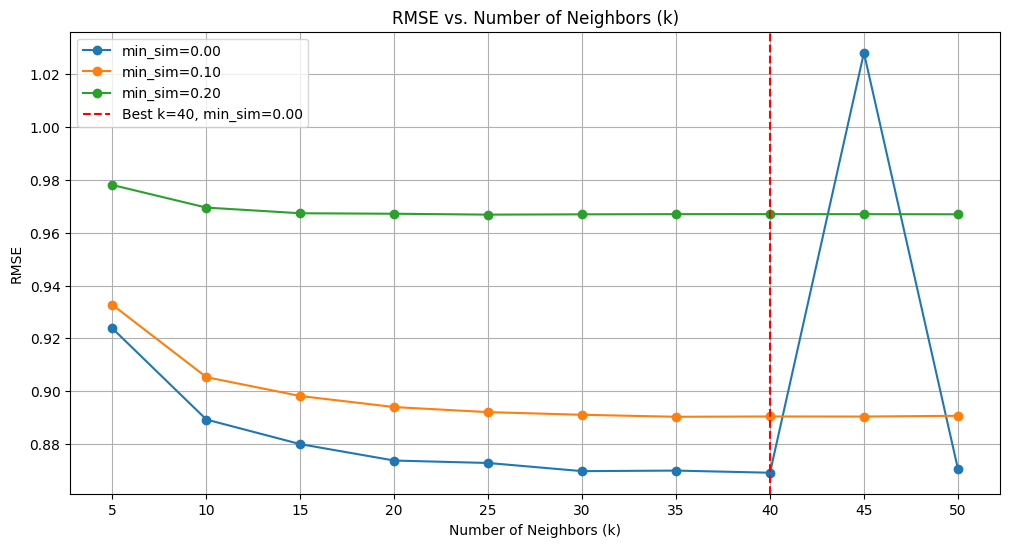

In [46]:
# Visualize tuning results
print("Visualizing hyperparameter tuning results...")
tuning_plot = plot_tuning_results(results_df)
tuning_plot.savefig('tuning_results.png')
print("Saved tuning results visualization to 'tuning_results.png'")

## Model evaluation

In [47]:
# Evaluate final model with clipped predictions
print("\n Evaluating final model with clipped predictions...")
rmse, mae, coverage, eval_df = evaluate_model(
    test_long, similarity_df, train_matrix, user_means, best_k, best_min_sim, ratings_df=ratings
)


 Evaluating final model with clipped predictions...

Evaluating final model with k=40, min_similarity=0.0
Generating predictions...


186393it [03:45, 825.91it/s]



Final Evaluation Metrics:
RMSE: 0.8845
MAE: 0.6886
Coverage: 99.99%

Prediction distribution:
count    186379.000000
mean          3.661718
std           0.756788
min         -13.013109
25%           3.201975
50%           3.745454
75%           4.203389
max          20.619393
dtype: float64

Found 3261 extreme predictions outside the 1-5 range
Min prediction: -13.01
Max prediction: 20.62



 Visualizing evaluation results...


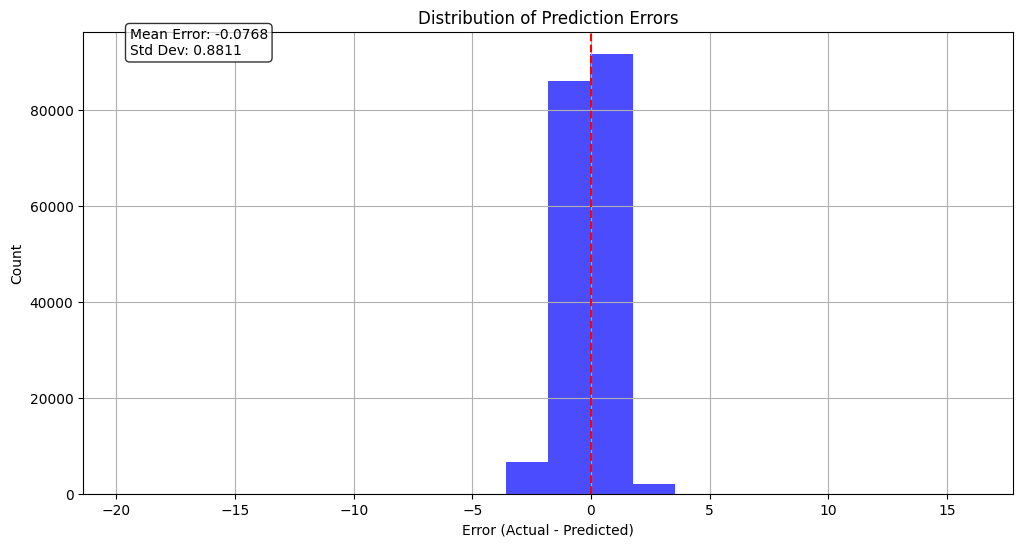

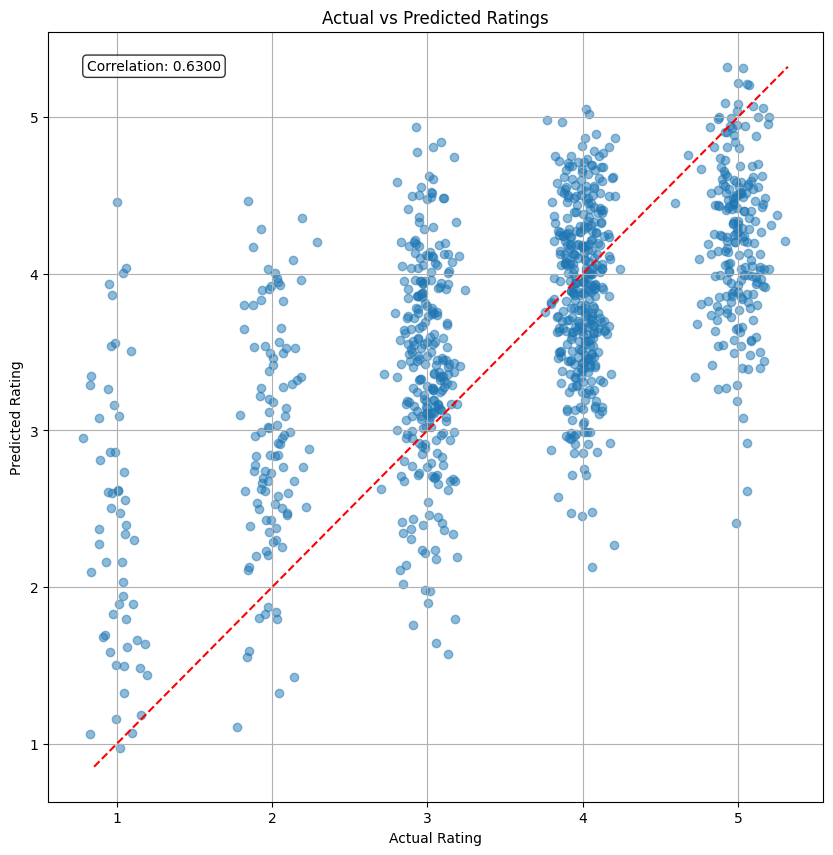

In [48]:
if eval_df is not None:
    print("\n Visualizing evaluation results...")

    # Display error distribution
    error_plot = plot_error_distribution(eval_df)
    error_plot.show()

    # Display actual vs predicted ratings
    actual_vs_pred_plot = plot_actual_vs_predicted(eval_df)
    actual_vs_pred_plot.show()


Performing demographic evaluation...

=== Evaluation by Gender ===
  Gender=F: RMSE=0.9151, MAE=0.7110, Count=45223 (24.3%)
  Gender=M: RMSE=0.8744, MAE=0.6814, Count=141156 (75.7%)

=== Evaluation by AgeDesc ===
  AgeDesc=18-24: RMSE=0.9107, MAE=0.7142, Count=34129 (18.3%)
  AgeDesc=25-34: RMSE=0.8818, MAE=0.6882, Count=74582 (40.0%)
  AgeDesc=35-44: RMSE=0.8637, MAE=0.6722, Count=37033 (19.9%)
  AgeDesc=45-49: RMSE=0.8608, MAE=0.6708, Count=15349 (8.2%)
  AgeDesc=50-55: RMSE=0.8853, MAE=0.6714, Count=13467 (7.2%)
  AgeDesc=56+: RMSE=0.8746, MAE=0.6728, Count=6761 (3.6%)
  AgeDesc=Under 18: RMSE=0.9720, MAE=0.7618, Count=5058 (2.7%)

=== Evaluation by OccupationDesc ===
  OccupationDesc=K-12 student: RMSE=0.9624, MAE=0.7580, Count=4346 (2.3%)
  OccupationDesc=academic/educator: RMSE=0.8876, MAE=0.6904, Count=15787 (8.5%)
  OccupationDesc=artist: RMSE=0.9068, MAE=0.7109, Count=9226 (5.0%)
  OccupationDesc=clerical/admin: RMSE=0.9131, MAE=0.7119, Count=5840 (3.1%)
  OccupationDesc=coll

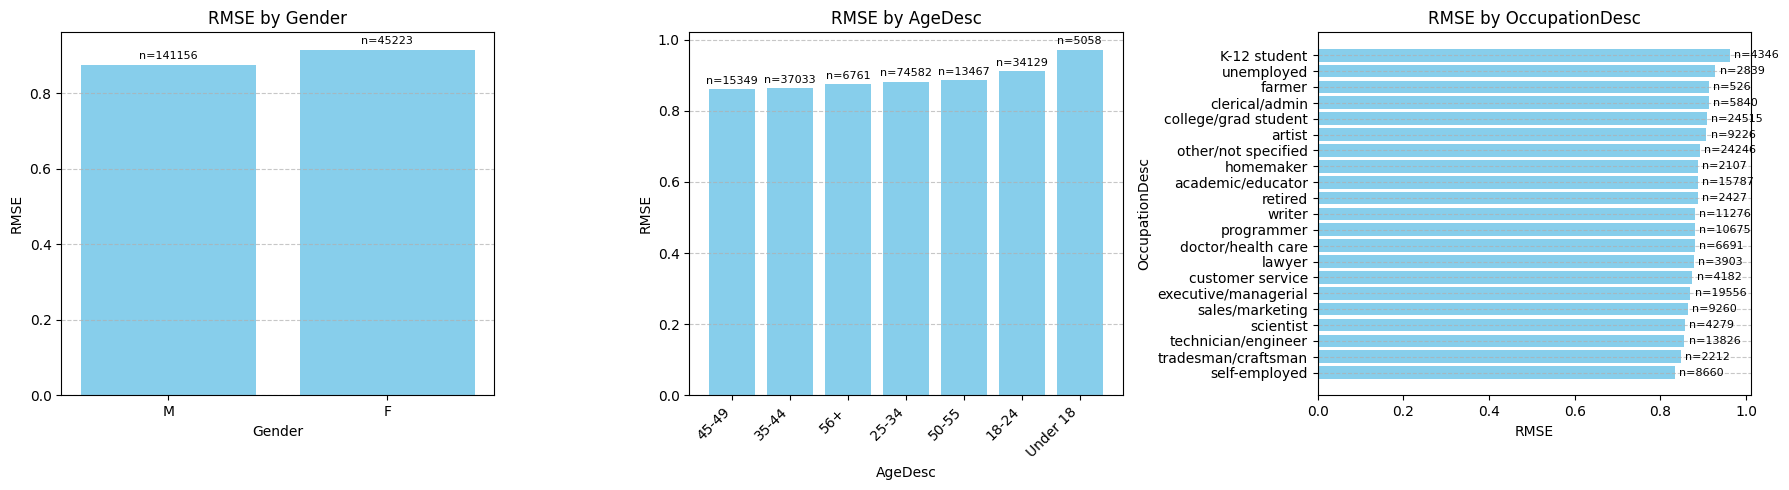

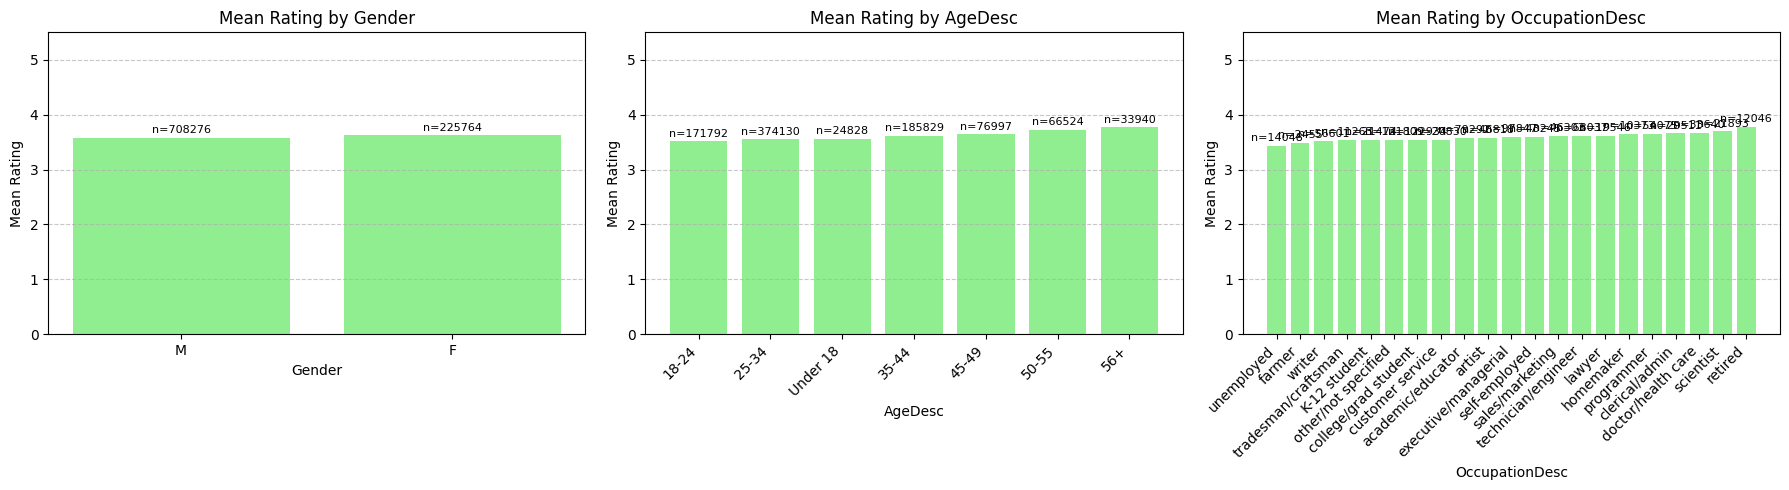

In [49]:
print("\nPerforming demographic evaluation...")

# Evaluate performance on demographic subsets
demo_metrics = evaluate_demographic_subsets(eval_df, ratings)

# Display demographic RMSE plot
demo_rmse_plot = plot_demographic_metrics(demo_metrics, metric='rmse')
if demo_rmse_plot:
    demo_rmse_plot.show()

# Display rating distribution by demographic
rating_dist_plot = analyze_rating_distribution_by_demographic(ratings)
if rating_dist_plot:
    rating_dist_plot.show()


In [50]:
print("\Analyzing optimal parameters for demographic groups...")

# Evaluate for Age groups
age_analysis = evaluate_model_by_demographic(
    eval_df, ratings, 'AgeDesc',
    k=best_k,
    user_means=user_means,
    similarity_df=similarity_df, 
    train_matrix=train_matrix,
    test_long=test_long
)

# Evaluate for Occupation groups
occupation_analysis = evaluate_model_by_demographic(
    eval_df, ratings, 'OccupationDesc',
    k=best_k,
    user_means=user_means,
    similarity_df=similarity_df, 
    train_matrix=train_matrix,
    test_long=test_long
)

\Analyzing optimal parameters for demographic groups...

=== Detailed Evaluation by AgeDesc ===
  AgeDesc=18-24: RMSE=0.9107, MAE=0.7142, Count=34129 (18.3%)
  AgeDesc=25-34: RMSE=0.8818, MAE=0.6882, Count=74582 (40.0%)
  AgeDesc=35-44: RMSE=0.8637, MAE=0.6722, Count=37033 (19.9%)
  AgeDesc=45-49: RMSE=0.8608, MAE=0.6708, Count=15349 (8.2%)
  AgeDesc=50-55: RMSE=0.8853, MAE=0.6714, Count=13467 (7.2%)
  AgeDesc=56+: RMSE=0.8746, MAE=0.6728, Count=6761 (3.6%)
  AgeDesc=Under 18: RMSE=0.9720, MAE=0.7618, Count=5058 (2.7%)

=== Detailed Evaluation by OccupationDesc ===
  OccupationDesc=K-12 student: RMSE=0.9624, MAE=0.7580, Count=4346 (2.3%)
  OccupationDesc=academic/educator: RMSE=0.8876, MAE=0.6904, Count=15787 (8.5%)
  OccupationDesc=artist: RMSE=0.9068, MAE=0.7109, Count=9226 (5.0%)
  OccupationDesc=clerical/admin: RMSE=0.9131, MAE=0.7119, Count=5840 (3.1%)
  OccupationDesc=college/grad student: RMSE=0.9080, MAE=0.7104, Count=24515 (13.2%)
  OccupationDesc=customer service: RMSE=0.8743

## Fairness Metrics

In recommender systems, fairness is a critical consideration to ensure equitable treatment of users. Fairness can be evaluated at two levels:

- **Individual Fairness**: Focuses on ensuring that each user, regardless of their characteristics, receives recommendations of similar quality.
- **Group Fairness**: Ensures that different demographic groups (e.g., based on gender, age, etc.) experience comparable recommendation quality, preventing systematic bias against certain groups.

### Individual fairness

To quantify individual fairness, we implemented two complementary metrics:

1. **Gini Coefficient** - Measuring inequality in prediction error distribution across all users
2. **Bottom-N Average** - Assessing the experience of users receiving the worst recommendation quality

#### Gini coefficient

=== Gini Coefficient Fairness Metric (UserKNN) ===
Gini Coefficient: 0.1141 (0 = perfect equality, 1 = perfect inequality)
Calculated across 4557 users with top-5 recommendations
Relevance threshold: Rating >= 3.5


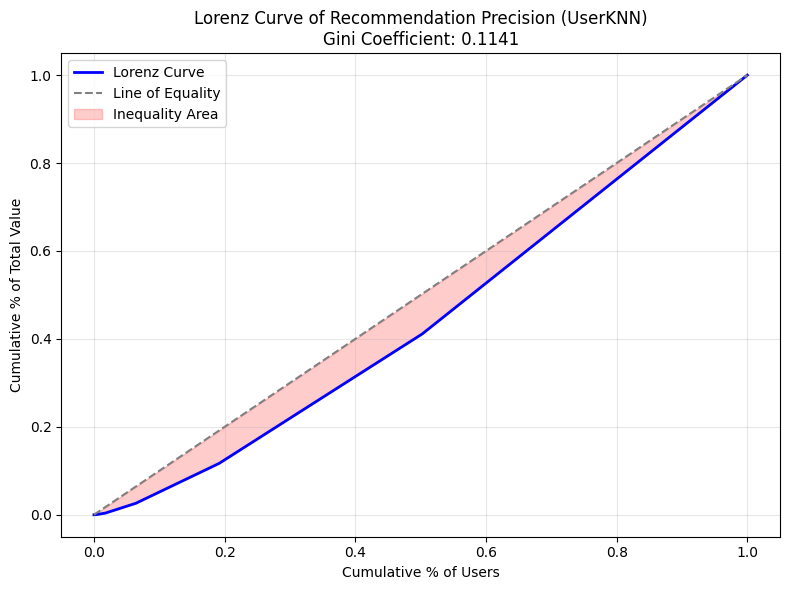

(0.1140539435483488,
 {1: 0.8,
  2: 1.0,
  3: 1.0,
  5: 0.8,
  6: 0.8,
  8: 1.0,
  9: 1.0,
  10: 0.8,
  11: 0.8,
  13: 0.8,
  15: 0.8,
  17: 1.0,
  18: 1.0,
  19: 1.0,
  22: 1.0,
  23: 0.8,
  24: 1.0,
  25: 0.8,
  26: 0.6,
  27: 1.0,
  28: 0.8,
  29: 0.4,
  31: 0.8,
  32: 0.8,
  33: 0.8,
  34: 1.0,
  35: 0.8,
  36: 1.0,
  37: 0.8,
  38: 0.8,
  39: 1.0,
  40: 1.0,
  42: 0.6,
  44: 0.8,
  45: 0.8,
  48: 1.0,
  49: 0.8,
  52: 0.8,
  53: 1.0,
  56: 0.8,
  57: 0.8,
  58: 1.0,
  59: 0.8,
  60: 0.6,
  62: 0.8,
  63: 1.0,
  65: 1.0,
  67: 1.0,
  68: 1.0,
  69: 1.0,
  70: 1.0,
  73: 1.0,
  75: 1.0,
  76: 1.0,
  78: 0.6,
  80: 1.0,
  81: 1.0,
  82: 0.8,
  83: 1.0,
  86: 1.0,
  87: 1.0,
  88: 1.0,
  90: 0.2,
  91: 1.0,
  92: 0.6,
  93: 0.8,
  95: 0.8,
  96: 0.6,
  97: 1.0,
  99: 0.8,
  100: 0.4,
  101: 1.0,
  102: 0.6,
  103: 1.0,
  104: 0.4,
  105: 1.0,
  106: 1.0,
  107: 1.0,
  109: 1.0,
  110: 1.0,
  111: 1.0,
  112: 0.8,
  113: 0.4,
  114: 1.0,
  116: 1.0,
  117: 0.6,
  118: 0.8,
  119: 0.2,


In [51]:
evaluate_gini_userKNN(eval_df, threshold=3.5, top_n_size=5, plot=True)

#### Bottom N-average

\Evaluating bottom-N individual fairness...
=== Bottom-N Average Individual Fairness Metric ===
Total number of users: 4557
Bottom 5 users average: 1.4755
Bottom 10 users average: 1.6878
Bottom 20 users average: 1.8638
Bottom 50 users average: 2.1282
Bottom 1% of users (45 users) average: 2.0972
Bottom 5% of users (227 users) average: 2.5666
Bottom 10% of users (455 users) average: 2.7864
Bottom 20% of users (911 users) average: 3.0207
Overall average across all users: 3.7903
Disparity between overall and bottom 1%: 1.6932 (44.7%)
Disparity between overall and bottom 5%: 1.2237 (32.3%)
Disparity between overall and bottom 10%: 1.0039 (26.5%)
Disparity between overall and bottom 20%: 0.7697 (20.3%)


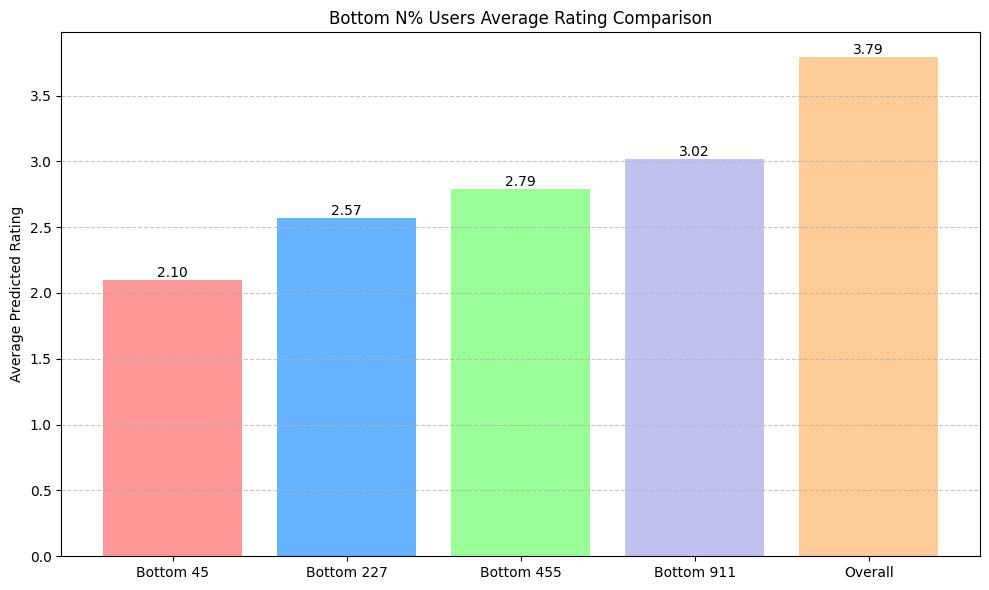

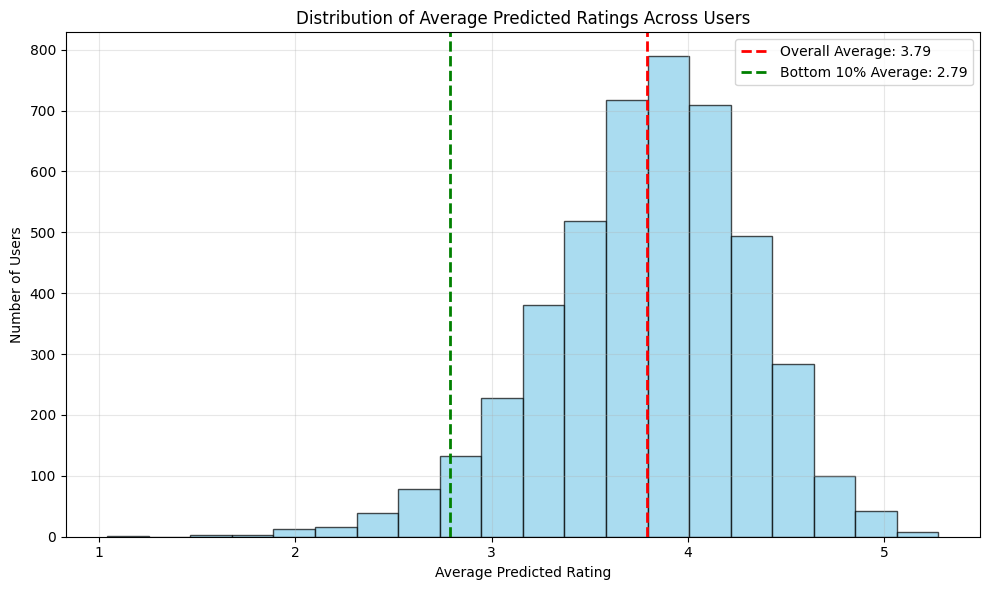

In [52]:
print("\Evaluating bottom-N individual fairness...")
bottom_n_results = evaluate_bottom_n_fairness(
    eval_df,  
    ns=[5, 10, 20, 50],
    user_column='UserID',
    value_column='Predicted'
)

### Group fairness

To assess fairness across demographic groups, we implemented two complementary metrics:

1. **N1-Norm** - Measuring absolute differences in prediction quality between demographic groups
2. **KL Divergence** - Quantifying the statistical distance between prediction distributions across different groups

#### N1-Norm

\Evaluating N1-norm group fairness...
=== N1-Norm Group Fairness Metric ===

Analyzing Gender fairness:

  RMSE distribution N1-norm:
    F: 0.3733 (high difference)
      Mean: 0.9003 vs Overall: 0.8752
      Difference: 0.0251 (2.9%)
    M: 0.1362 (moderate difference)
      Mean: 0.8661 vs Overall: 0.8752
      Difference: 0.0091 (1.0%)

  MAE distribution N1-norm:
    F: 0.9822 (high difference)
      Mean: 0.7194 vs Overall: 0.6995
      Difference: 0.0199 (2.8%)
    M: 0.3583 (high difference)
      Mean: 0.6922 vs Overall: 0.6995
      Difference: 0.0072 (1.0%)

  avg_pred distribution N1-norm:
    F: 0.3792 (high difference)
      Mean: 3.8243 vs Overall: 3.7903
      Difference: 0.0340 (0.9%)
    M: 0.1383 (moderate difference)
      Mean: 3.7779 vs Overall: 3.7903
      Difference: 0.0124 (0.3%)

  avg_error distribution N1-norm:
    F: 0.4208 (high difference)
      Mean: -0.0924 vs Overall: -0.0998
      Difference: 0.0074 (-7.4%)
    M: 0.1535 (moderate difference)
      M

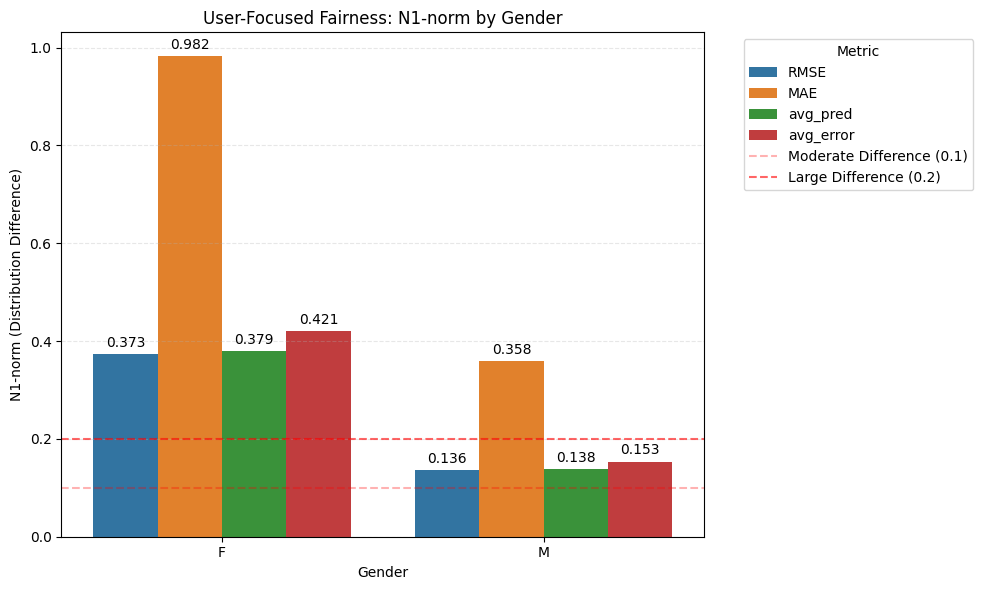

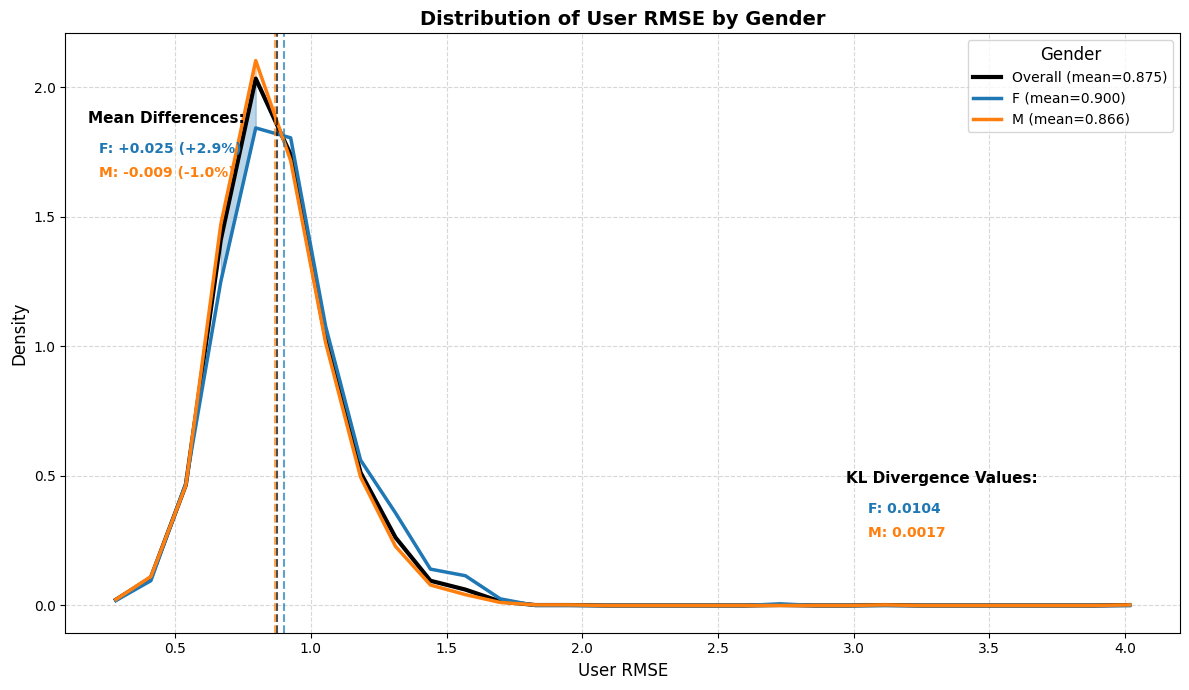

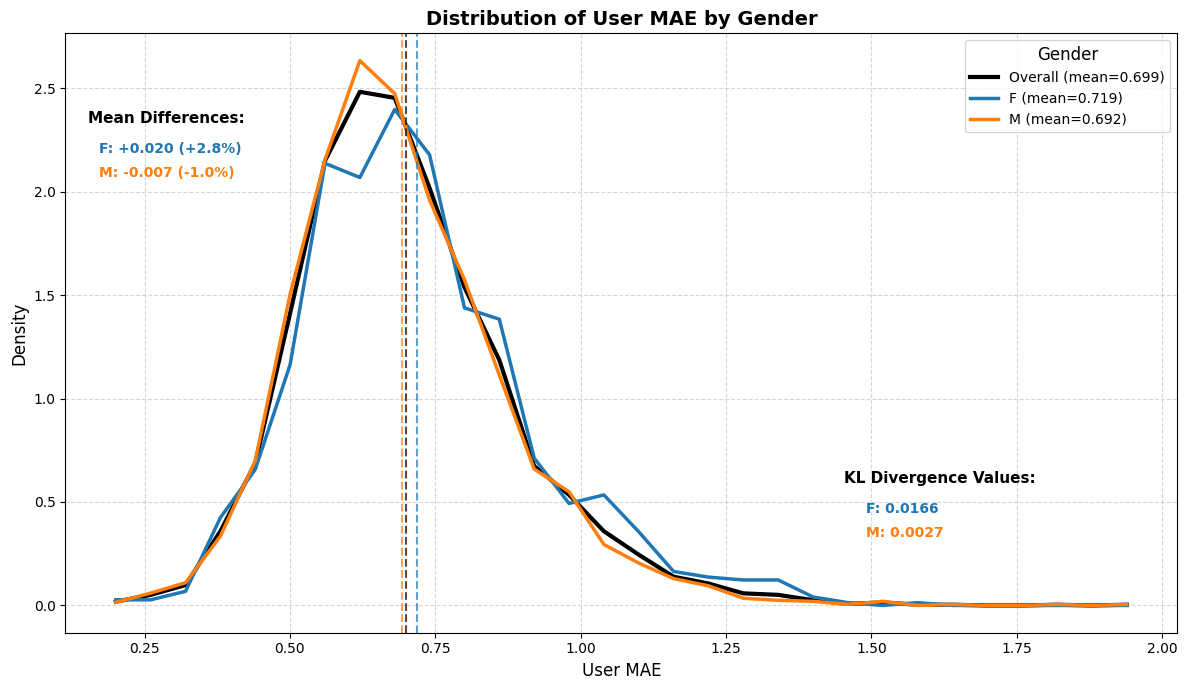


Analyzing AgeDesc fairness:

  RMSE distribution N1-norm:
    Under 18: 1.4744 (high difference)
      Mean: 0.9851 vs Overall: 0.8752
      Difference: 0.1099 (12.6%)
    56+: 0.6962 (high difference)
      Mean: 0.8606 vs Overall: 0.8752
      Difference: 0.0146 (1.7%)
    25-34: 0.1820 (moderate difference)
      Mean: 0.8718 vs Overall: 0.8752
      Difference: 0.0034 (0.4%)
    50-55: 0.4838 (high difference)
      Mean: 0.8679 vs Overall: 0.8752
      Difference: 0.0073 (0.8%)
    35-44: 0.4564 (high difference)
      Mean: 0.8503 vs Overall: 0.8752
      Difference: 0.0249 (2.8%)
    45-49: 0.6714 (high difference)
      Mean: 0.8516 vs Overall: 0.8752
      Difference: 0.0236 (2.7%)
    18-24: 0.5325 (high difference)
      Mean: 0.9064 vs Overall: 0.8752
      Difference: 0.0312 (3.6%)

  MAE distribution N1-norm:
    Under 18: 3.6630 (high difference)
      Mean: 0.7971 vs Overall: 0.6995
      Difference: 0.0976 (14.0%)
    56+: 1.5671 (high difference)
      Mean: 0.6841 v

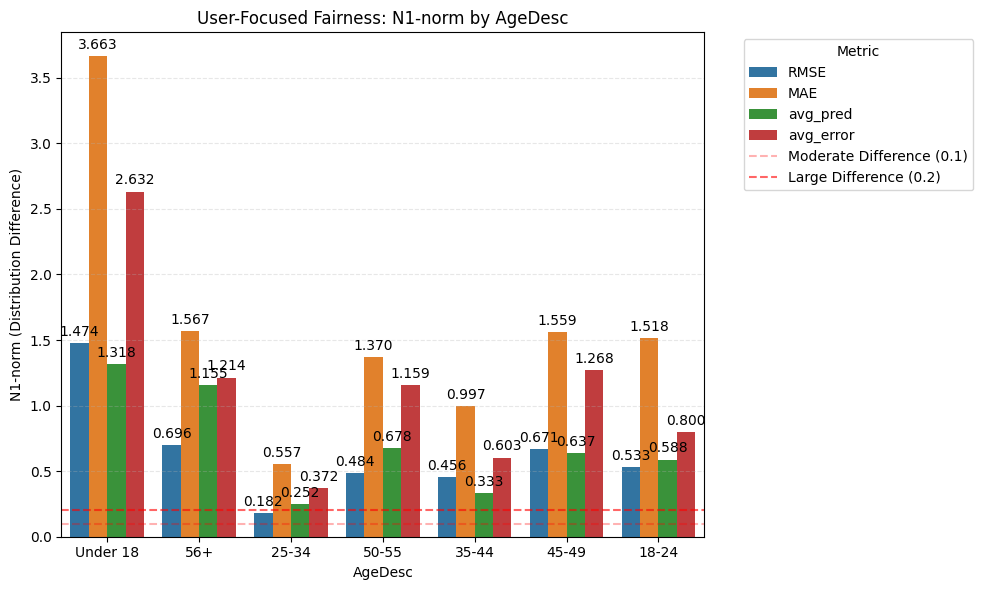

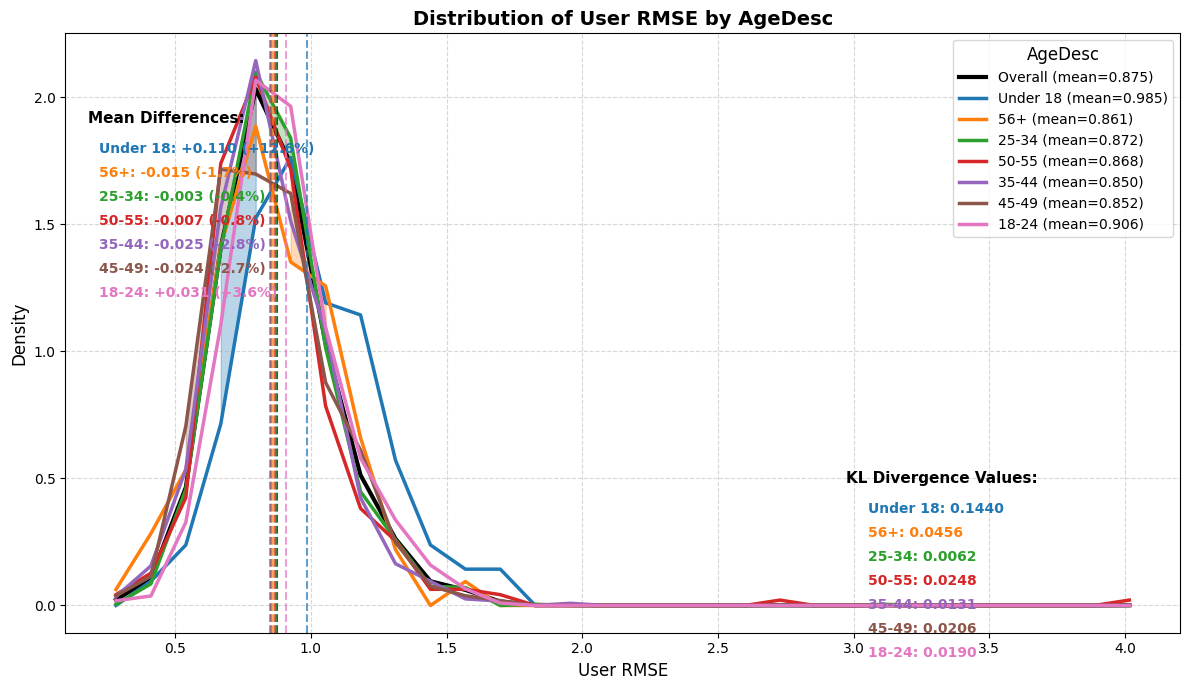

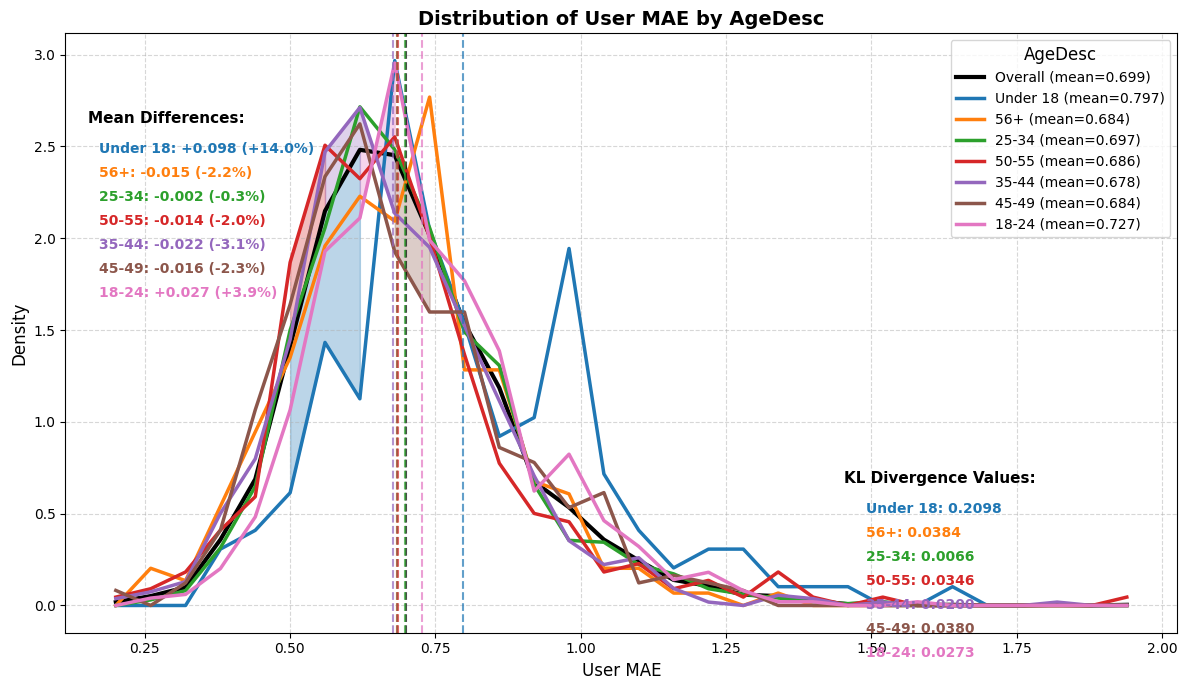

In [53]:
# Step 14: Evaluate N1-norm group fairness
print("\Evaluating N1-norm group fairness...")
n1_results, user_metrics_with_demo = evaluate_n1_norm_fairness(
    eval_df,
    ratings,
    metrics=['RMSE', 'MAE', 'avg_pred', 'avg_error'],
    demographic_fields=['Gender', 'AgeDesc'],
    bins=30
)

#### KL-divergence

\Evaluating KL divergence group fairness...
=== KL Divergence Group Fairness Metric ===

Analyzing Gender fairness:

  RMSE KL divergence results:
    F: 0.0104 (low divergence)
      Mean: 0.9003 vs Overall: 0.8752
      Difference: 0.0251 (2.9%)
      Sample size: 1218
    M: 0.0017 (low divergence)
      Mean: 0.8661 vs Overall: 0.8752
      Difference: 0.0091 (1.0%)
      Sample size: 3339

  MAE KL divergence results:
    F: 0.0166 (low divergence)
      Mean: 0.7194 vs Overall: 0.6995
      Difference: 0.0199 (2.8%)
      Sample size: 1218
    M: 0.0027 (low divergence)
      Mean: 0.6922 vs Overall: 0.6995
      Difference: 0.0072 (1.0%)
      Sample size: 3339

  avg_pred KL divergence results:
    F: 0.0114 (low divergence)
      Mean: 3.8243 vs Overall: 3.7903
      Difference: 0.0340 (0.9%)
      Sample size: 1218
    M: 0.0015 (low divergence)
      Mean: 3.7779 vs Overall: 3.7903
      Difference: 0.0124 (0.3%)
      Sample size: 3339

  avg_error KL divergence results:
  

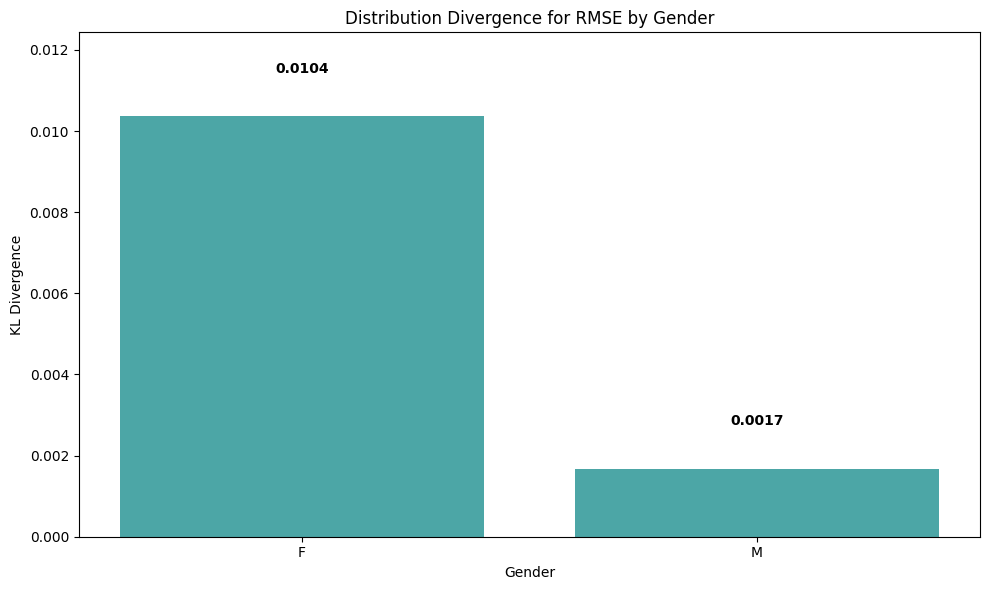

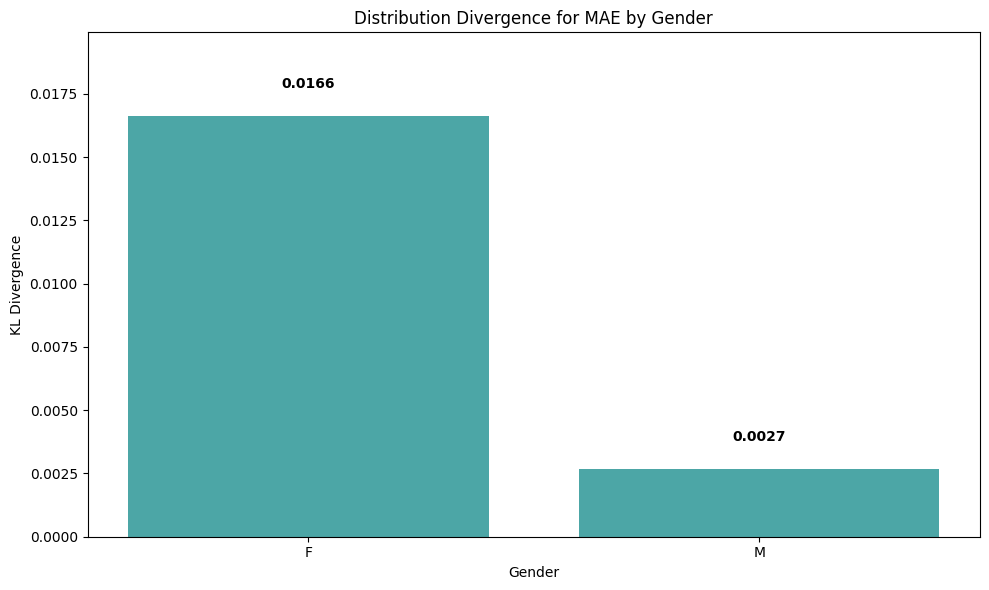

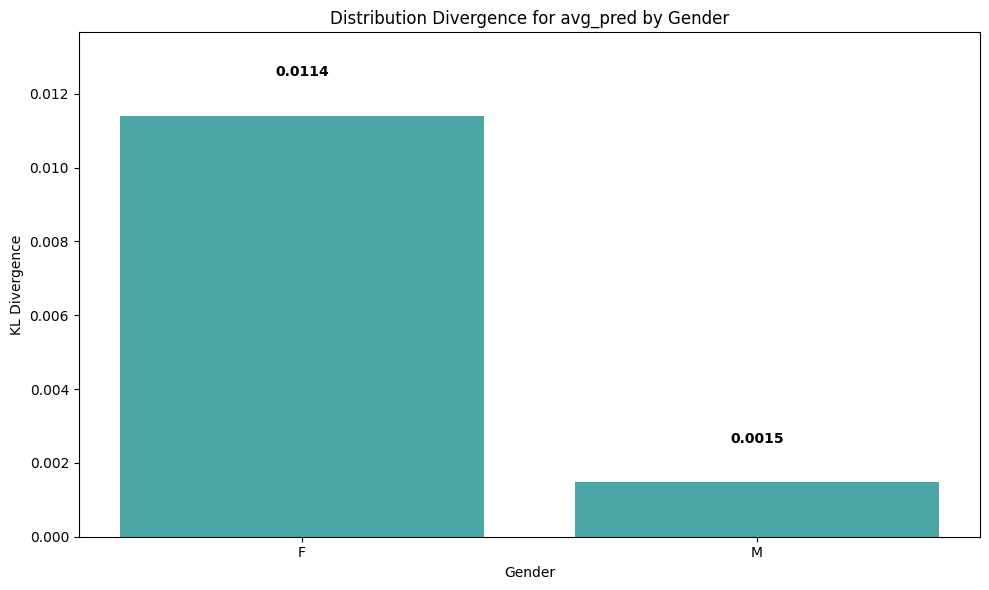

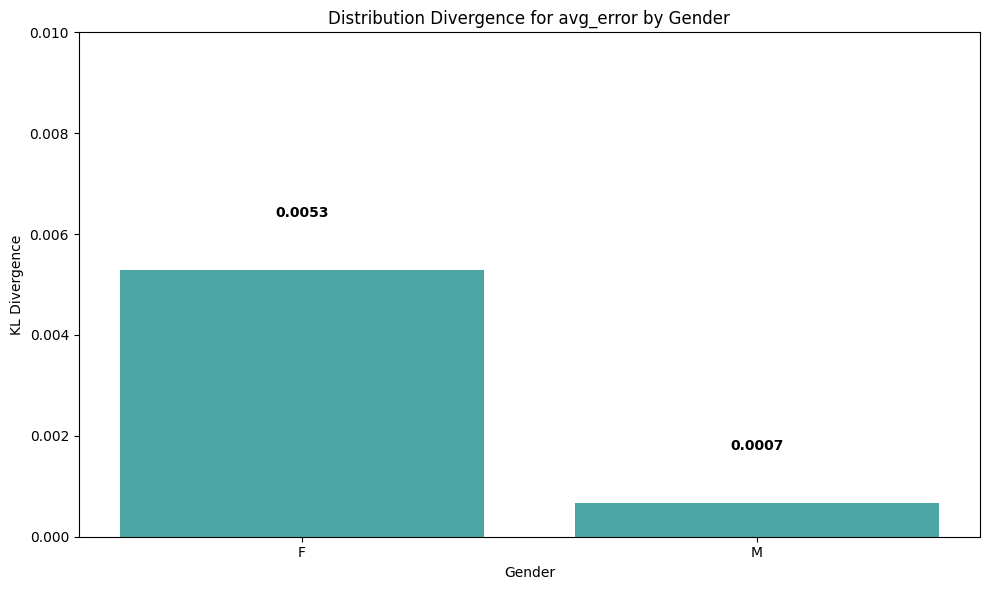

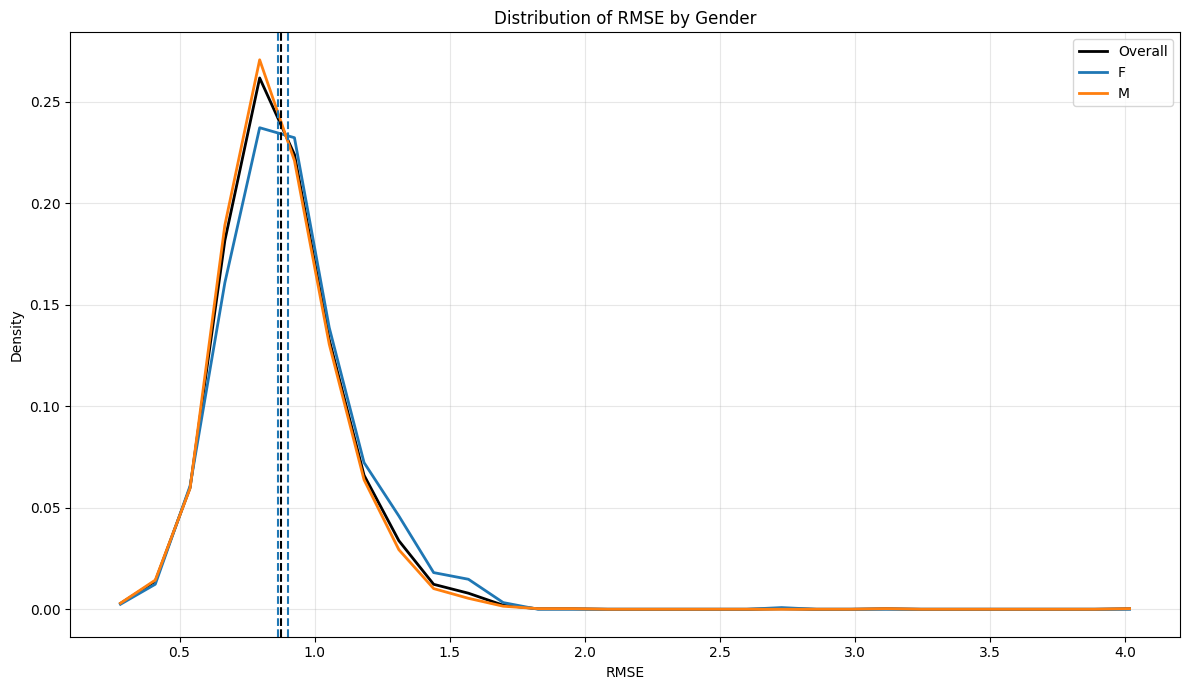

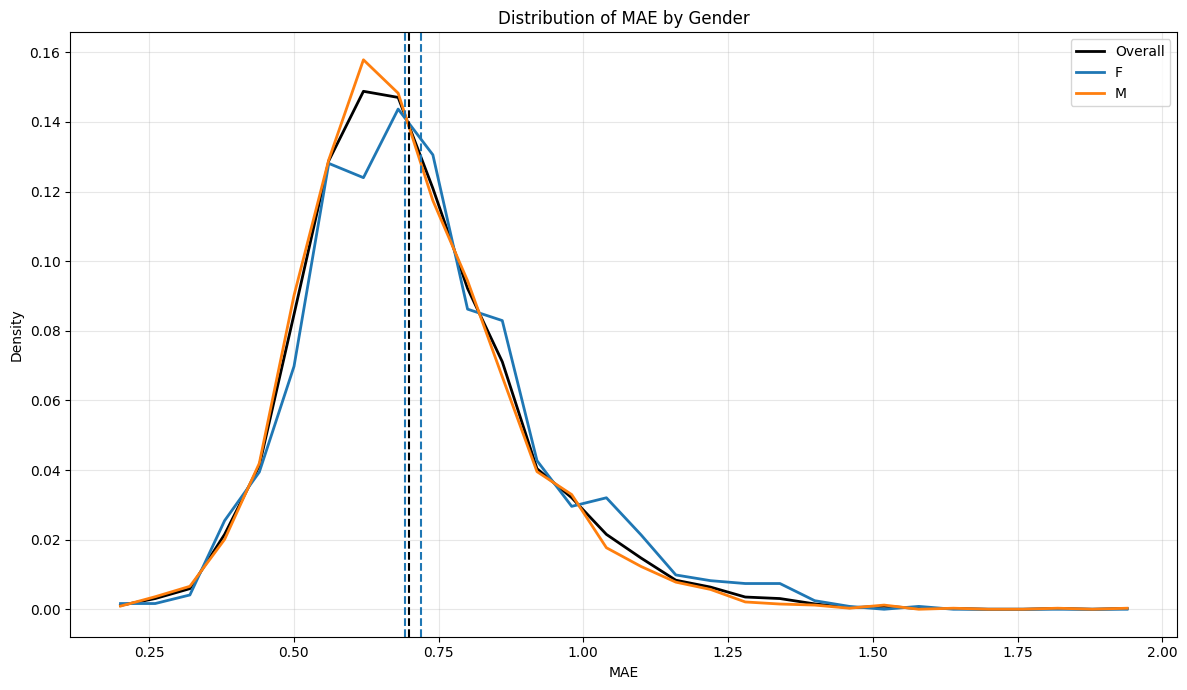

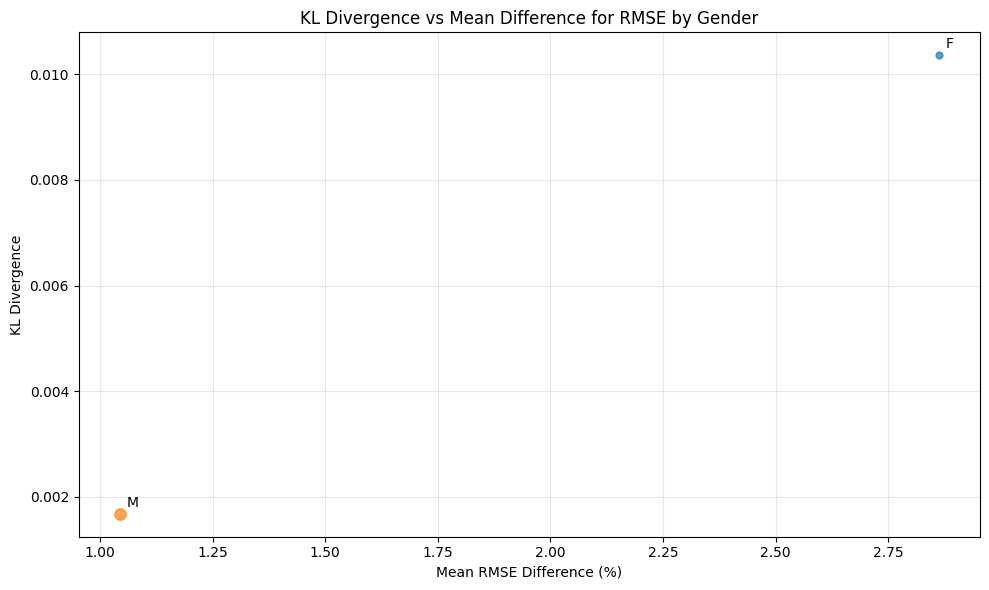

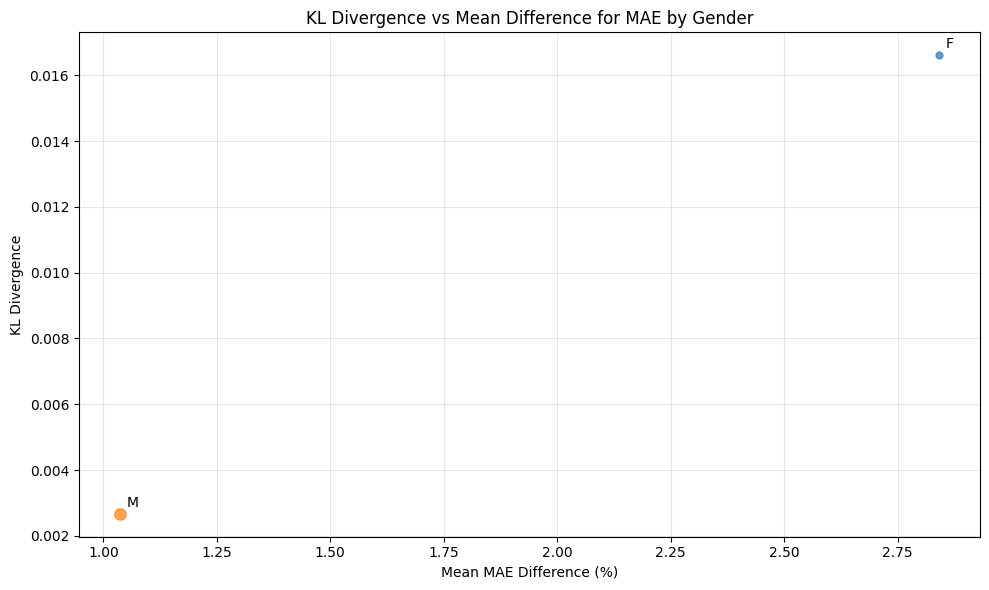


Analyzing AgeDesc fairness:

  RMSE KL divergence results:
    Under 18: 0.1440 (moderate divergence)
      Mean: 0.9851 vs Overall: 0.8752
      Difference: 0.1099 (12.6%)
      Sample size: 163
    56+: 0.0456 (low divergence)
      Mean: 0.8606 vs Overall: 0.8752
      Difference: 0.0146 (1.7%)
      Sample size: 247
    25-34: 0.0062 (low divergence)
      Mean: 0.8718 vs Overall: 0.8752
      Difference: 0.0034 (0.4%)
      Sample size: 1646
    50-55: 0.0248 (low divergence)
      Mean: 0.8679 vs Overall: 0.8752
      Difference: 0.0073 (0.8%)
      Sample size: 366
    35-44: 0.0131 (low divergence)
      Mean: 0.8503 vs Overall: 0.8752
      Difference: 0.0249 (2.8%)
      Sample size: 898
    45-49: 0.0206 (low divergence)
      Mean: 0.8516 vs Overall: 0.8752
      Difference: 0.0236 (2.7%)
      Sample size: 407
    18-24: 0.0190 (low divergence)
      Mean: 0.9064 vs Overall: 0.8752
      Difference: 0.0312 (3.6%)
      Sample size: 830

  MAE KL divergence results:
    Un

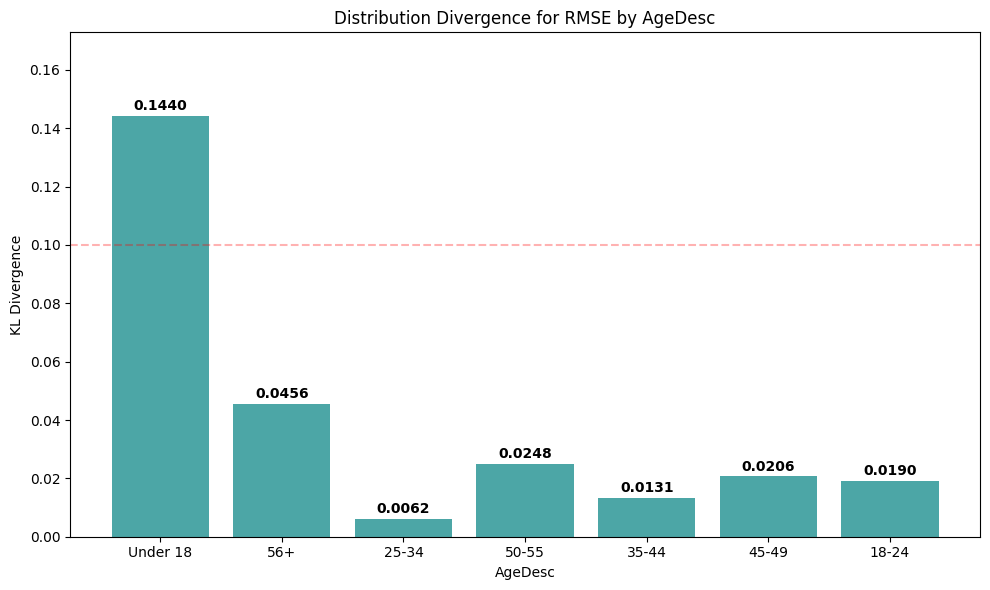

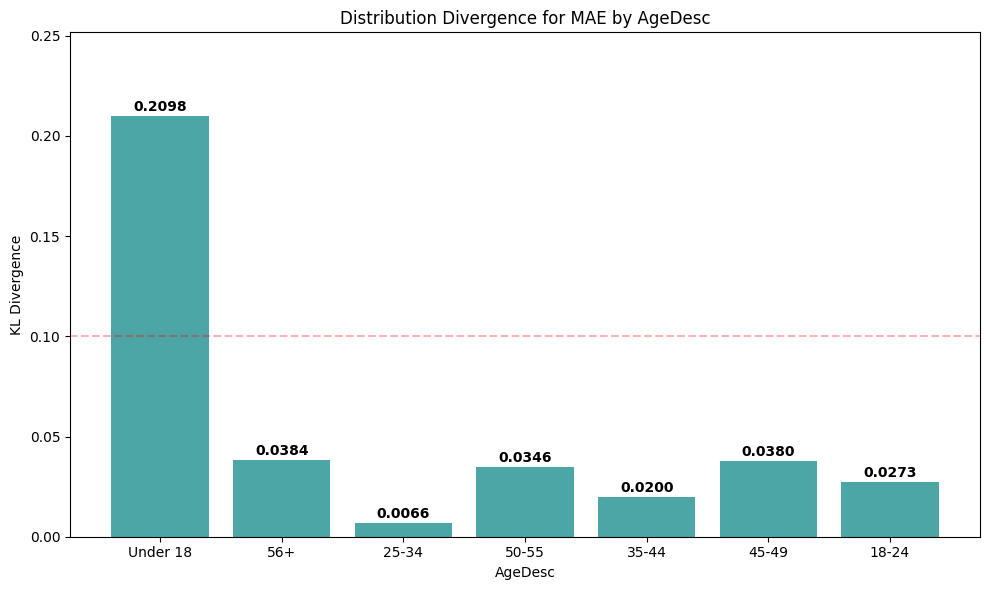

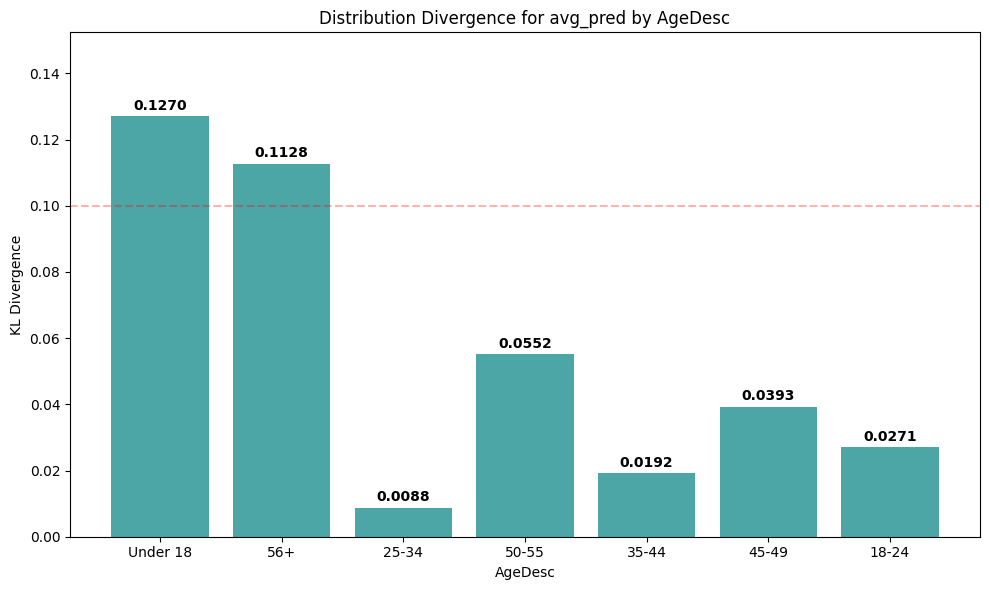

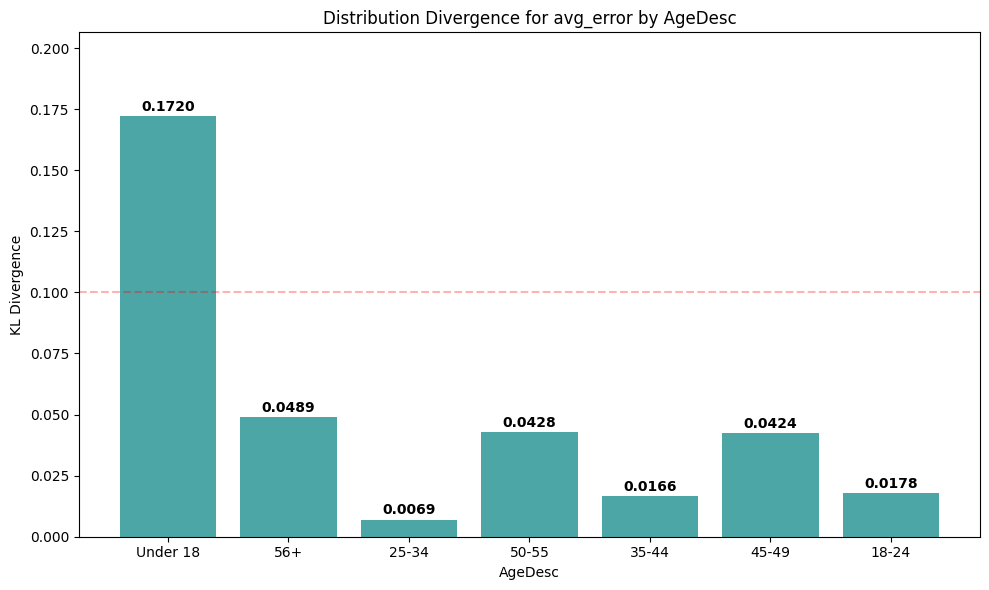

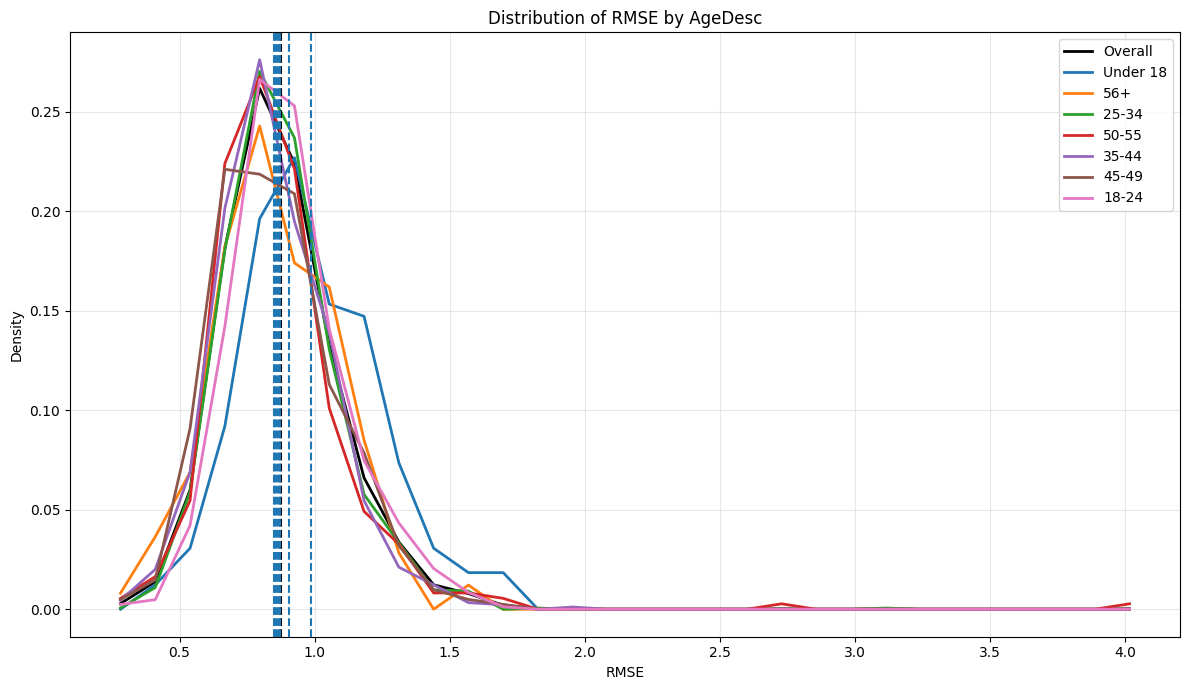

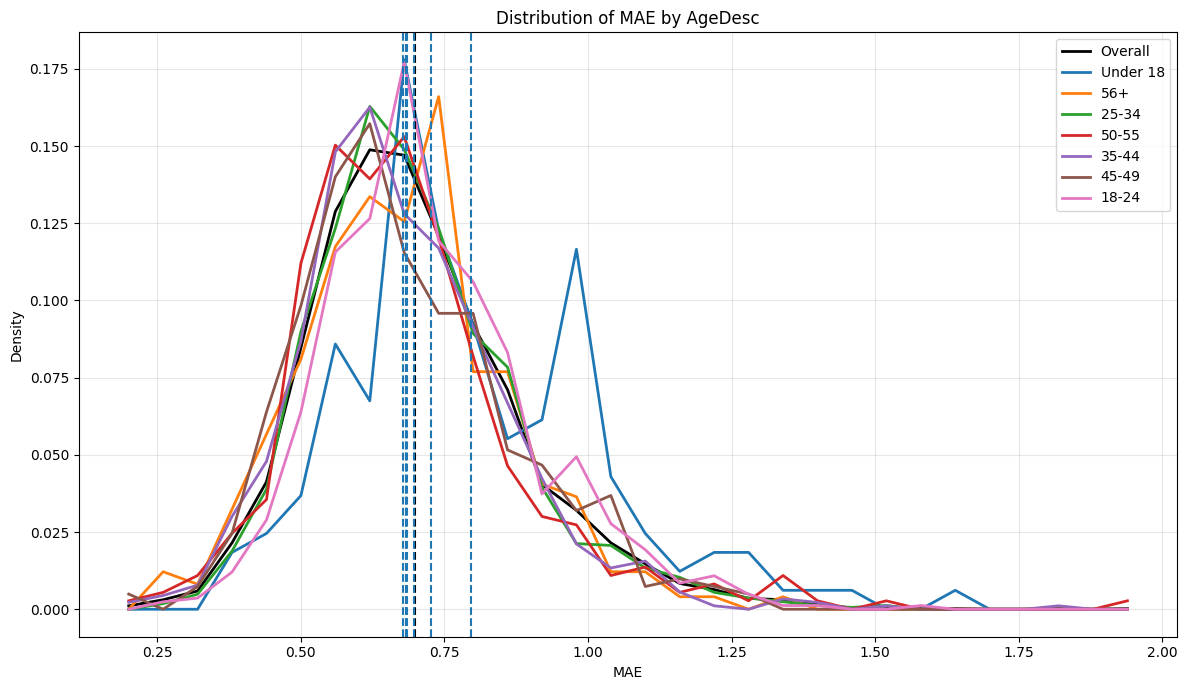

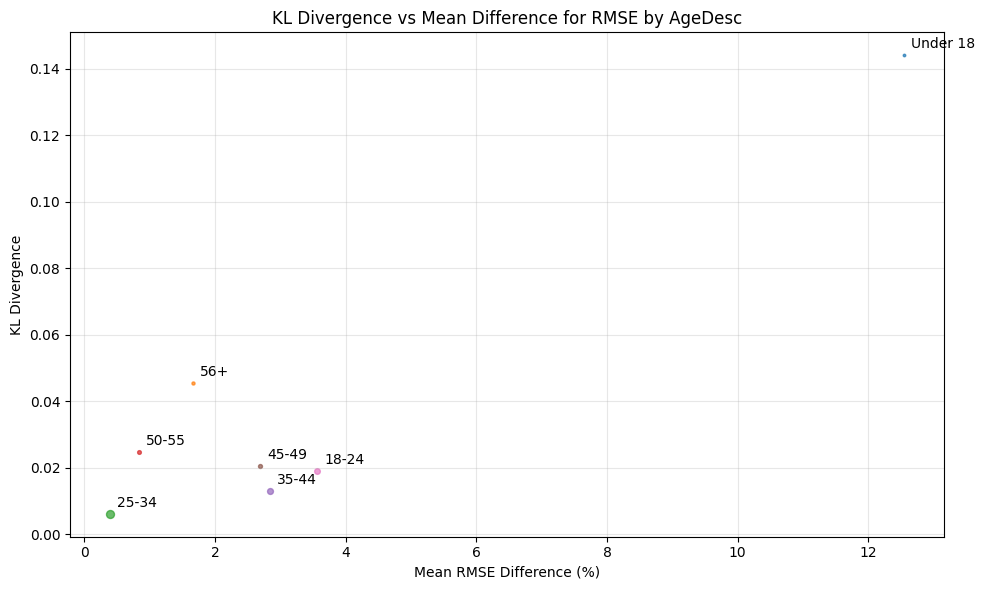

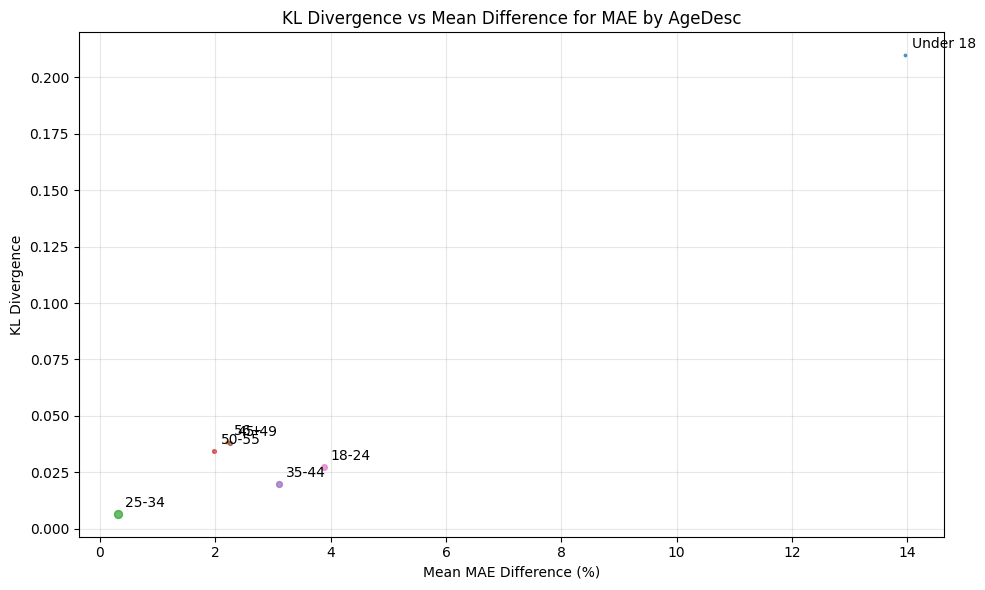

In [54]:
# Step 15: Evaluate KL divergence group fairness
print("\Evaluating KL divergence group fairness...")
kl_results, user_metrics_with_demo = evaluate_kl_divergence_fairness(
    eval_df,
    ratings,
    metrics=['RMSE', 'MAE', 'avg_pred', 'avg_error'],
    demographic_fields=['Gender', 'AgeDesc'],
    bins=30
)

### Sani's fairness metrics

#### Variance for Individual Fairness:

In [55]:
eval_df

,UserID,MovieID,Actual,Predicted,Error,AbsError
0,1,260,4,4.876090,-0.876090,0.876090
1,1,527,5,5.095346,-0.095346,0.095346
2,1,588,4,4.707145,-0.707145,0.707145
3,1,661,3,3.702596,-0.702596,0.702596
4,1,720,3,4.776113,-1.776113,1.776113
...,...,...,...,...,...,...
186374,6040,2794,1,2.732915,-1.732915,1.732915
186375,6040,3418,3,3.622655,-0.622655,0.622655
186376,6040,3424,2,4.233545,-2.233545,2.233545
186377,6040,3504,4,4.321758,-0.321758,0.321758


In [56]:
def get_knn_top5_recommendations(eval_df, users=None, k=5):
    """
    Generates the top-5 recommended movies for each user based on predicted ratings in eval_df.

    Parameters:
    eval_df (DataFrame): DataFrame containing UserID, MovieID, Actual and Predicted ratings
    users (list, optional): List of specific users to generate recommendations for. 
                           If None, recommendations for all users in eval_df are generated.
    k (int): Number of recommendations to generate per user (default 5)

    Returns:
    dict: Dictionary with user IDs as keys and lists of top-5 recommended movies and ratings as values.
          Format: {user_id: [(movie_id, predicted_rating), ...]}
    """
    knn_top_recs = defaultdict(list)
    
    # If no specific users provided, use all users in the dataframe
    if users is None:
        users = eval_df['UserID'].unique()
    
    # Group predictions by user
    user_predictions = {user: eval_df[eval_df['UserID'] == user] for user in users}
    
    # For each user, get their top k recommendations based on predicted ratings
    for user_id, user_data in user_predictions.items():
        # Sort by predicted rating (descending)
        sorted_predictions = user_data.sort_values('Predicted', ascending=False)
        
        # Take top k recommended movies
        top_k_movies = sorted_predictions.head(k)
        
        # Store as list of (movie_id, predicted_rating) tuples
        knn_top_recs[user_id] = [
            (row['MovieID'], row['Predicted']) 
            for _, row in top_k_movies.iterrows()
        ]
    
    return knn_top_recs

In [57]:
def calculate_individual_variances(top_5_recommendations):
    """
    Calculates variance in predicted ratings for each individual customer based on recommended categories.

    Parameters:
    top_5_recommendations (dict): Dictionary with customer IDs as keys and 
                                  lists of tuples (category, predicted_rating).

    Returns:
    dict: Dictionary mapping customer_id to their rating variance and number of rated categories.
          Format: {customer_id: {"variance": float, "count": int}}
    """
    individual_stats = {}

    for customer, recommendations in top_5_recommendations.items():
        ratings = [rating for _, rating in recommendations]
        
        variance_value = np.var(ratings) if ratings else 0.0
        count = len(ratings)
        
        individual_stats[customer] = {"variance": variance_value, "count": count}
    
    return individual_stats

In [58]:
def group_variances_by_age(individual_stats, customer_demographics, age_key="age_group"):
    """
    Groups individual variances by customer age group.

    Parameters:
    individual_stats (dict): Customer variance statistics from `calculate_individual_variances`.
    customer_demographics (dict): Customer demographics dictionary.
    age_key (str): Demographic attribute used to group by age. Default is "age_group".

    Returns:
    list[dict]: List containing variance data grouped by age, ready for DataFrame creation.
                Format: [{"Age Group": str, "Customer ID": str, "Variance": float, "Count": int}, ...]
    """
    rows = []

    for customer, stats in individual_stats.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        rows.append({
            "Age Group": age_group,
            "Customer ID": customer,
            "Variance": stats["variance"],
            "Count": stats["count"]
        })
    
    return rows

In [59]:
def calculate_agegroup_fairness(predictions, customer_demographics, product_categories, age_key="age_group"):
    """
    Calculates average variance of predicted ratings within each age group across categories.

    Parameters:
    predictions (dict): Customer recommendations dictionary (top-5 recommendations per customer).
    customer_demographics (dict): Customer demographics dictionary.
    product_categories (list): List of all product categories.
    age_key (str): Key for age group in demographics. Default "age_group".

    Returns:
    dict: Dictionary mapping age group to their average variance and total rating count.
          Format: {age_group: {"avg_variance": float, "total_count": int}}
    """
    agegroup_cat_ratings = defaultdict(lambda: defaultdict(list))

    for customer, recs in predictions.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        for category, rating in recs:
            if category in product_categories:
                agegroup_cat_ratings[age_group][category].append(rating)

    fairness_by_age = {}

    for age_group, categories in agegroup_cat_ratings.items():
        variances = []
        total_count = 0

        for category in product_categories:
            ratings = categories.get(category, [])
            if ratings:
                variances.append(np.var(ratings))
                total_count += len(ratings)

        avg_variance = np.mean(variances) if variances else 0.0

        fairness_by_age[age_group] = {"avg_variance": avg_variance, "total_count": total_count}

    return fairness_by_age

Overall Recommendation Variance Summary:
Total users analyzed: 4557
Overall mean variance: 0.042469
Overall median variance: 0.015586
Min variance: 0.000065
Max variance: 44.805999
Standard deviation: 0.766802

userKNN Individual Fairness by Age Group (Summary)
           Variance                                     
               mean    median       min        max count
Age Group                                               
18-24      0.032559  0.018786  0.000065   1.518078   830
25-34      0.051770  0.015676  0.000121  44.805999  1646
35-44      0.024976  0.014311  0.000323   1.170211   898
45-49      0.024640  0.013887  0.000171   0.276447   407
50-55      0.096933  0.013402  0.000161  25.748245   366
56+        0.026863  0.014309  0.000218   0.881276   247
Under 18   0.041261  0.024007  0.000730   0.673868   163


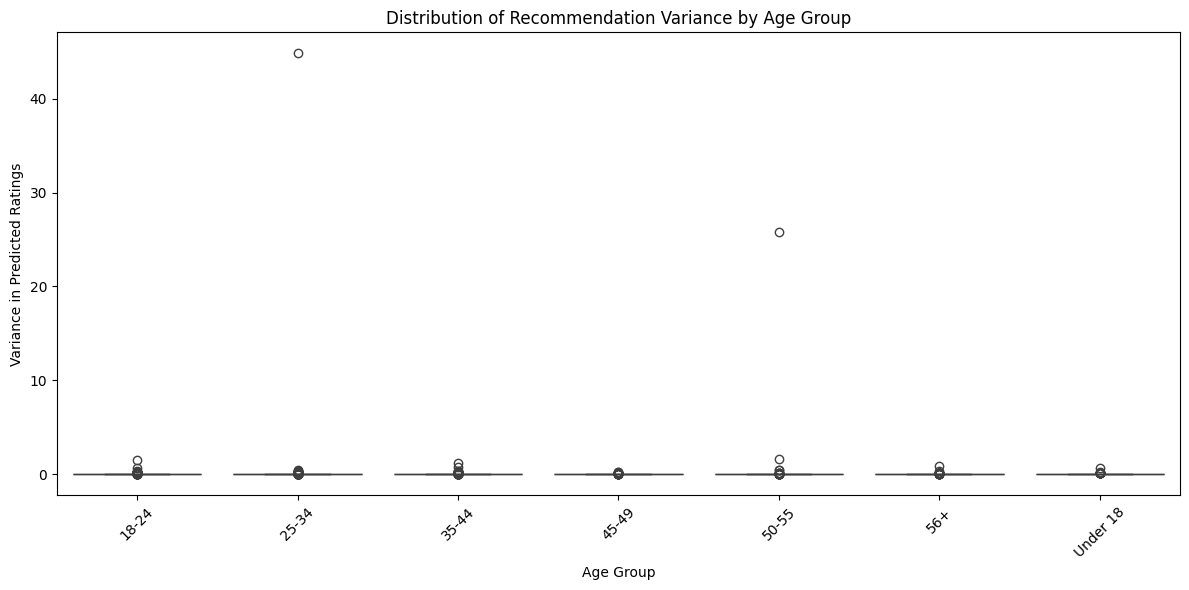

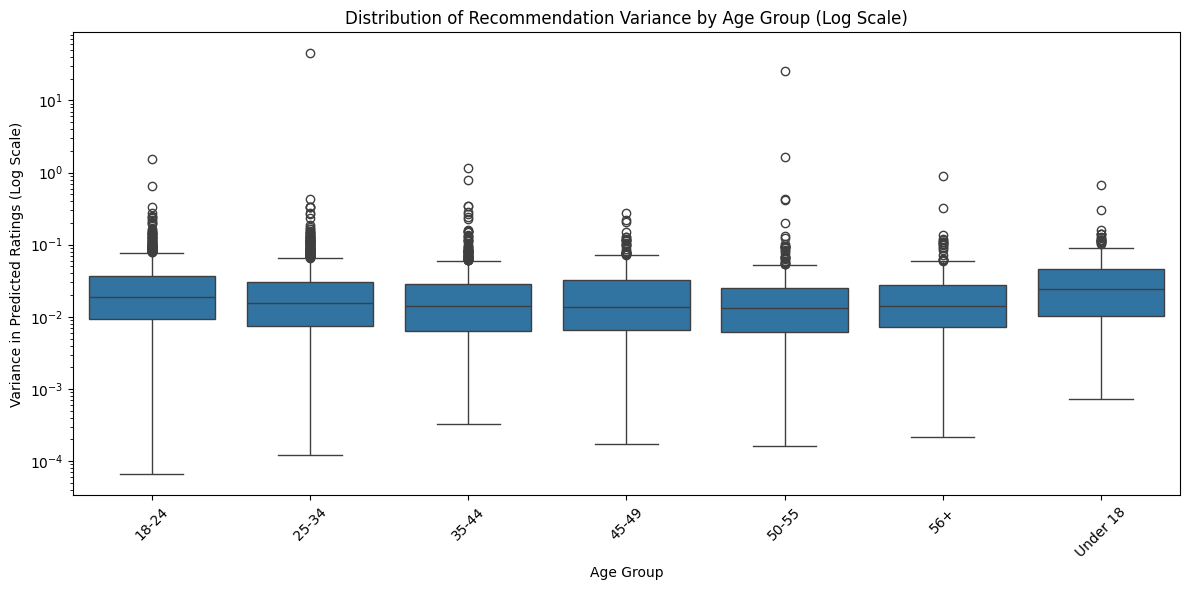

In [60]:
# --- Generate top-5 recommendations with userKNN ---
userKNN_top_5_recs = get_knn_top5_recommendations(eval_df)

# --- Individual variance calculation using userKNN recommendations ---
userKNN_individual_stats = calculate_individual_variances(userKNN_top_5_recs)

# --- Use existing demographic data from user_metrics_with_demo ---
# Extract unique users with their demographic information
user_demographics = user_metrics_with_demo[['UserID', 'AgeDesc', 'Gender']].drop_duplicates()

# --- Convert demographics DataFrame to dictionary format ---
customer_demographics_dict = {}
for _, row in user_demographics.iterrows():
    customer_demographics_dict[row['UserID']] = {
        "age_group": row['AgeDesc'],
        "gender": row['Gender']
    }

# --- Group variances by age ---
userKNN_rows = group_variances_by_age(userKNN_individual_stats, customer_demographics_dict, age_key="age_group")

# --- Create DataFrame and normalize age group formatting if needed ---
userKNN_df = pd.DataFrame(userKNN_rows).sort_values(by=["Age Group", "Customer ID"])

# --- Print overall summary statistics ---
print("Overall Recommendation Variance Summary:")
print(f"Total users analyzed: {len(userKNN_df)}")
print(f"Overall mean variance: {userKNN_df['Variance'].mean():.6f}")
print(f"Overall median variance: {userKNN_df['Variance'].median():.6f}")
print(f"Min variance: {userKNN_df['Variance'].min():.6f}")
print(f"Max variance: {userKNN_df['Variance'].max():.6f}")
print(f"Standard deviation: {userKNN_df['Variance'].std():.6f}")

# --- Print summary statistics by age group ---
print("\nuserKNN Individual Fairness by Age Group (Summary)")
age_group_stats = userKNN_df.groupby("Age Group").agg({
    "Variance": ["mean", "median", "min", "max", "count"]
})
print(age_group_stats)

# --- Create boxplot visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="Age Group", y="Variance", data=userKNN_df)
plt.title("Distribution of Recommendation Variance by Age Group")
plt.ylabel("Variance in Predicted Ratings")
plt.xticks(rotation=45)
plt.tight_layout()

# Add a second plot with log scale to better visualize differences
plt.figure(figsize=(12, 6))
sns.boxplot(x="Age Group", y="Variance", data=userKNN_df)
plt.yscale('log')  # Use log scale to better visualize the range
plt.title("Distribution of Recommendation Variance by Age Group (Log Scale)")
plt.ylabel("Variance in Predicted Ratings (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plots
plt.show()

# --- Write summary to file ---
with open("userKNN_fairness_summary.txt", "w") as f:
    f.write("UserKNN Recommendation Fairness Analysis\n")
    f.write("=====================================\n\n")
    f.write(f"Total users analyzed: {len(userKNN_df)}\n")
    f.write(f"Overall mean variance: {userKNN_df['Variance'].mean():.6f}\n")
    f.write(f"Overall median variance: {userKNN_df['Variance'].median():.6f}\n")
    f.write(f"Standard deviation: {userKNN_df['Variance'].std():.6f}\n\n")
    f.write("Variance by Age Group:\n")
    f.write(age_group_stats.to_string())

### Mean Average Envy for Individual Fairness:

In [61]:
def calculate_individual_mean_average_envy(top_5_recommendations):
    """
    Calculates Mean Average Envy (MAE) for each customer based on their predicted ratings.
    Envy is defined as the average positive difference between the ratings of other customers
    and the focal customer's own rating for the same category.

    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs to a list of tuples (product_category, predicted_rating).

    Returns:
        dict: Dictionary mapping customer IDs to their MAE values.
              Format: {customer_id: mean_average_envy (float)}
    """
    individual_envy = {}
    customers = list(top_5_recommendations.keys())

    for customer_i in customers:
        recs_i = top_5_recommendations.get(customer_i, [])
        total_envy = 0
        comparisons = 0

        for category_i, rating_i in recs_i:
            # Compare against all other customers
            for customer_j in customers:
                if customer_i == customer_j:
                    continue
                recs_j = top_5_recommendations.get(customer_j, [])
                # Check ratings for the same category
                for category_j, rating_j in recs_j:
                    if category_j == category_i:
                        envy = max(rating_j - rating_i, 0)
                        total_envy += envy
                        comparisons += 1

        individual_envy[customer_i] = total_envy / comparisons if comparisons > 0 else 0.0

    return individual_envy

In [62]:
def group_envy_by_age(individual_envy, customer_demographics, age_key="age_group"):
    """
    Groups individual MAE values by customer age group.

    Parameters:
        individual_envy (dict):
            Dictionary mapping customer IDs to MAE values.
        customer_demographics (dict):
            Dictionary mapping customer IDs to their demographic information.
        age_key (str):
            Demographic attribute to group by age (default "age_group").

    Returns:
        list[dict]: List containing MAE data grouped by age, ready for DataFrame creation.
                    Format: [{"Age Group": str, "Customer ID": str, "Envy": float}, ...]
    """
    rows = []

    for customer, envy_value in individual_envy.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        rows.append({
            "Age Group": age_group,
            "Customer ID": customer,
            "Envy": envy_value
        })

    return rows

Overall Recommendation Envy Summary:
Total users analyzed: 4557
Overall mean envy: 0.239726
Overall median envy: 0.163408
Min envy: 0.000000
Max envy: 2.956292
Standard deviation: 0.248502

User-KNN Individual Fairness by Age Group (Summary)
               Envy                                    
               mean    median       min       max count
Age Group                                              
18-24      0.245821  0.165591  0.000221  2.370445   830
25-34      0.237440  0.160656  0.000000  2.039278  1646
35-44      0.231309  0.157613  0.000159  2.956292   898
45-49      0.234198  0.171064  0.001513  1.274365   407
50-55      0.235981  0.161330  0.000469  1.624748   366
56+        0.242394  0.158820  0.000000  2.156997   247
Under 18   0.296310  0.188046  0.001305  1.854567   163


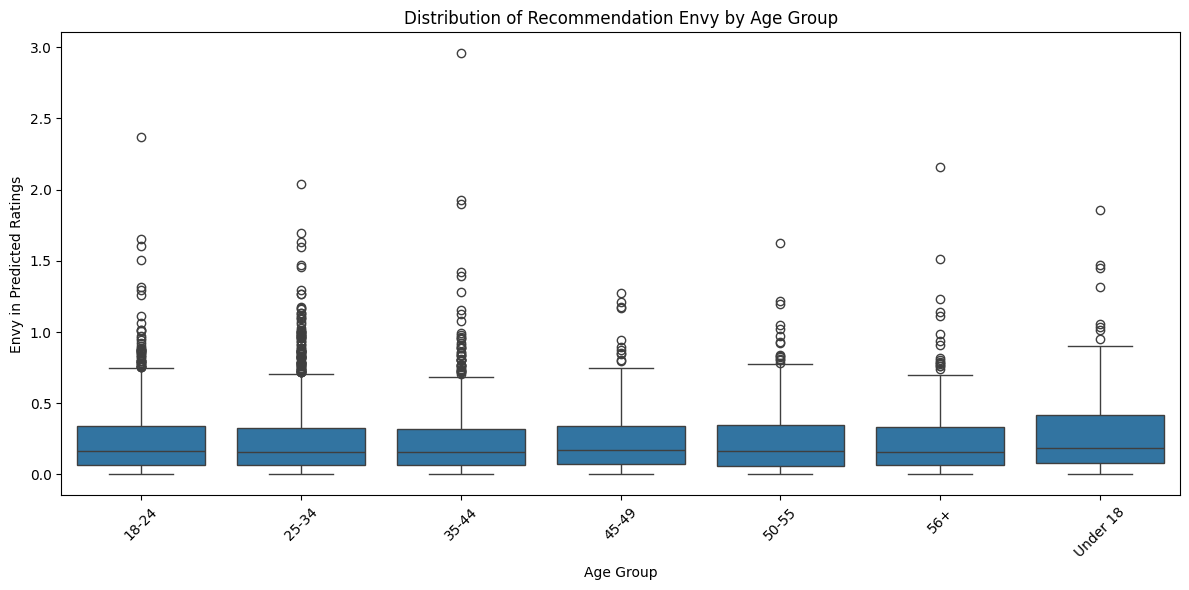

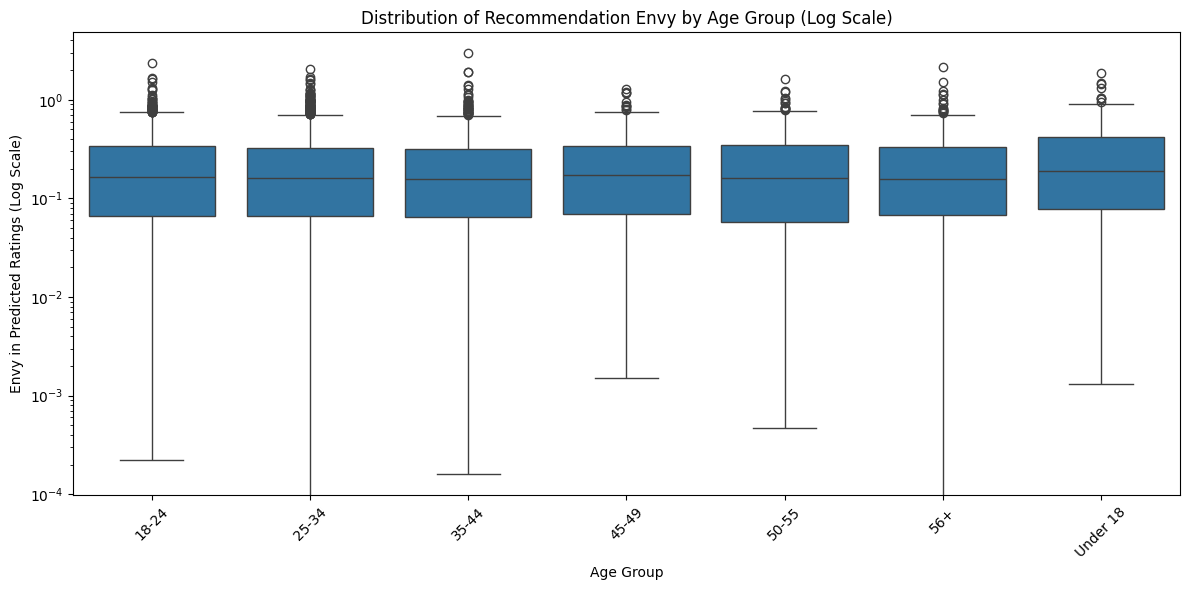

In [63]:
# --- Generate top-5 recommendations with User-KNN ---
userKNN_top_5_recs = get_knn_top5_recommendations(eval_df)

# --- Individual envy calculation using User-KNN recommendations ---
knn_individual_envy = calculate_individual_mean_average_envy(userKNN_top_5_recs)

# --- Use existing demographic data from user_metrics_with_demo ---
# Extract unique users with their demographic information
user_demographics = user_metrics_with_demo[['UserID', 'AgeDesc', 'Gender']].drop_duplicates()

# --- Convert demographics DataFrame to dictionary format ---
customer_demographics_dict = {}
for _, row in user_demographics.iterrows():
    customer_demographics_dict[row['UserID']] = {
        "age_group": row['AgeDesc'],
        "gender": row['Gender']
    }

# --- Group envy by age ---
knn_envy_rows = group_envy_by_age(knn_individual_envy, customer_demographics_dict, age_key="age_group")

# --- Create DataFrame and normalize age group formatting if needed ---
knn_envy_df = pd.DataFrame(knn_envy_rows).sort_values(by=["Age Group", "Customer ID"])

# --- Print overall summary statistics ---
print("Overall Recommendation Envy Summary:")
print(f"Total users analyzed: {len(knn_envy_df)}")
print(f"Overall mean envy: {knn_envy_df['Envy'].mean():.6f}")
print(f"Overall median envy: {knn_envy_df['Envy'].median():.6f}")
print(f"Min envy: {knn_envy_df['Envy'].min():.6f}")
print(f"Max envy: {knn_envy_df['Envy'].max():.6f}")
print(f"Standard deviation: {knn_envy_df['Envy'].std():.6f}")

# --- Print summary statistics by age group ---
print("\nUser-KNN Individual Fairness by Age Group (Summary)")
age_group_stats = knn_envy_df.groupby("Age Group").agg({
    "Envy": ["mean", "median", "min", "max", "count"]
})
print(age_group_stats)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Age Group", y="Envy", data=knn_envy_df)
plt.title("Distribution of Recommendation Envy by Age Group")
plt.ylabel("Envy in Predicted Ratings")
plt.xticks(rotation=45)
plt.tight_layout()

# Add a second plot with log scale to better visualize differences
plt.figure(figsize=(12, 6))
sns.boxplot(x="Age Group", y="Envy", data=knn_envy_df)
plt.yscale('log')  # Use log scale to better visualize the range
plt.title("Distribution of Recommendation Envy by Age Group (Log Scale)")
plt.ylabel("Envy in Predicted Ratings (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plots
plt.show()

# --- Write summary to file ---
with open("UserKNN_fairness_summary.txt", "w") as f:
    f.write("User-KNN Recommendation Fairness Analysis\n")
    f.write("=======================================\n\n")
    f.write(f"Total users analyzed: {len(knn_envy_df)}\n")
    f.write(f"Overall mean envy: {knn_envy_df['Envy'].mean():.6f}\n")
    f.write(f"Overall median envy: {knn_envy_df['Envy'].median():.6f}\n")
    f.write(f"Standard deviation: {knn_envy_df['Envy'].std():.6f}\n\n")
    f.write("Envy by Age Group:\n")
    f.write(age_group_stats.to_string())

## Group User Fairness

#### Fraction of Satisfied Users (FSU) for Group Fairness

In [64]:
def compute_customer_utility(predictions, product_categories):
    """
    Computes the average predicted rating (utility) for each customer 
    based on their top-5 recommendations.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        product_categories (list[str]):
            List of valid product categories to include.

    Returns:
        dict: Mapping of customer ID to average utility (float).
              Customers with no valid predictions are assigned np.nan.
    """
    utilities = {}

    for customer_id, recs in predictions.items():
        ratings = [rating for category, rating in recs if category in product_categories]
        utilities[customer_id] = np.mean(ratings) if ratings else np.nan

    return utilities

In [65]:
def compute_fraction_satisfied_by_group(utilities, customer_demographics, group_key):
    """
    Calculates the fraction of satisfied users within each demographic group.
    A user is considered satisfied if their utility is >= their group's average utility.

    Parameters:
        utilities (dict):
            Mapping from customer ID to their average predicted utility.
        customer_demographics (dict):
            Mapping from customer ID to demographic attributes.
        group_key (str):
            The demographic column to group by (e.g., 'gender').

    Returns:
        DataFrame: Group-level statistics including:
            - Number of customers
            - Group average utility
            - Number of satisfied users
            - Fraction satisfied
    """
    records = [
        {
            "CustomerID": customer,
            "Utility": util,
            "Group": customer_demographics.get(customer, {}).get(group_key, "Unknown")
        }
        for customer, util in utilities.items()
        if not np.isnan(util)
    ]

    df = pd.DataFrame(records)

    # Calculate group average utility
    group_avg = df.groupby("Group")["Utility"].mean().reset_index().rename(columns={"Utility": "Group_Avg"})
    df = df.merge(group_avg, on="Group", how="left")

    # Determine satisfaction
    df["Satisfied"] = df["Utility"] >= df["Group_Avg"]

    # Aggregate results per group
    summary = df.groupby("Group").agg(
        Num_Customers=("CustomerID", "count"),
        Group_Avg=("Group_Avg", "first"),
        Num_Satisfied=("Satisfied", "sum")
    ).reset_index()

    summary["Fraction_Satisfied"] = summary["Num_Satisfied"] / summary["Num_Customers"]

    return summary

In [66]:
# --- Generate top-5 recommendations with User-KNN ---
userKNN_top_5_recs = get_knn_top5_recommendations(eval_df)

# --- Individual envy calculation using User-KNN recommendations ---
knn_individual_envy = calculate_individual_mean_average_envy(userKNN_top_5_recs)

# --- Use existing demographic data from user_metrics_with_demo ---
# Extract unique users with their demographic information
user_demographics = user_metrics_with_demo[['UserID', 'AgeDesc', 'Gender']].drop_duplicates()

# --- Convert demographics DataFrame to dictionary format ---
customer_demographics_dict = {}
for _, row in user_demographics.iterrows():
    customer_demographics_dict[row['UserID']] = {
        "age_group": row['AgeDesc'],
        "gender": row['Gender']
    }

product_categories = list(user_item_matrix.index)

# Compute utilities
knn_utilities = compute_customer_utility(userKNN_top_5_recs, product_categories)

# Demographic columns to evaluate
demographic_columns = ["gender", "age_group"]

# Item-KNN Model
print("\n=== Item-KNN Group Fairness Evaluation (Fraction of Satisfied Users) ===")
for demo_col in demographic_columns:
    knn_summary = compute_fraction_satisfied_by_group(knn_utilities, customer_demographics_dict, group_key=demo_col)
    print(f"\n[Demographic Column: {demo_col}]")
    print(knn_summary.to_string(index=False))


=== Item-KNN Group Fairness Evaluation (Fraction of Satisfied Users) ===

[Demographic Column: gender]
Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
    F           1216   4.382020            642            0.527961
    M           3335   4.433399           1798            0.539130

[Demographic Column: age_group]
   Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
   18-24            830   4.387117            444            0.534940
   25-34           1641   4.430449            885            0.539305
   35-44            898   4.443217            482            0.536748
   45-49            406   4.427637            211            0.519704
   50-55            366   4.460448            192            0.524590
     56+            247   4.416841            128            0.518219
Under 18            163   4.240090             95            0.582822


In [67]:
# --- Generate top-5 recommendations with User-KNN ---
userKNN_top_5_recs = get_knn_top5_recommendations(eval_df)

# --- Use existing demographic data from user_metrics_with_demo ---
# Extract unique users with their demographic information
user_demographics = user_metrics_with_demo[['UserID', 'AgeDesc', 'Gender']].drop_duplicates()

# --- Convert demographics DataFrame to dictionary format ---
customer_demographics_dict = {}
for _, row in user_demographics.iterrows():
    customer_demographics_dict[row['UserID']] = {
        "age_group": row['AgeDesc'],
        "gender": row['Gender']
    }

# Define product categories
product_categories = list(user_item_matrix.index)

# Compute utilities for UserKNN
knn_utilities = compute_customer_utility(userKNN_top_5_recs, product_categories)

# Demographic columns to evaluate
demographic_columns = ["gender", "age_group"]

# Initialize an empty DataFrame to store satisfaction data
satisfaction_all = pd.DataFrame()

# Process each demographic dimension
for col in demographic_columns:
    # Generate summary for the current demographic
    knn_summary = compute_fraction_satisfied_by_group(knn_utilities, customer_demographics_dict, group_key=col)
    knn_summary['Demographic'] = col
    
    # Add to the overall satisfaction DataFrame
    satisfaction_all = pd.concat([satisfaction_all, knn_summary])

# Calculate overall average fraction satisfied
knn_summary_avg = satisfaction_all['Fraction_Satisfied'].mean()

# Print only the overall average
print("\n=== Overall Average Fraction Satisfied ===")
print(f"UserKNN: {knn_summary_avg:.4f}")


=== Overall Average Fraction Satisfied ===
UserKNN: 0.5359


### Absolute Difference (AD) for Group Fairness:

In [68]:
def calculate_absolute_difference(predictions, customer_demographics, product_categories, gender_key="gender"):
    """
    Calculates Absolute Difference (AD) in predicted ratings between protected (female) 
    and unprotected (male) groups for each product category.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        customer_demographics (dict):
            Dictionary mapping customer IDs to demographic attributes, including gender.
        product_categories (list):
            List of product categories to evaluate.
        gender_key (str):
            Key in demographic dict for gender. Default is "gender".

    Returns:
        dict: Mapping from product category to AD value (float), or None if one group is missing.
              Format: {category: abs_diff_value or None}
    """
    ad_by_category = {}

    for category in product_categories:
        ratings_male = []
        ratings_female = []

        for customer, recs in predictions.items():
            # Skip if customer isn't in demographics or gender is missing
            if customer not in customer_demographics:
                continue
            
            gender = customer_demographics.get(customer, {}).get(gender_key, "unknown")
            # Handle capitalization variations
            if isinstance(gender, str):
                gender = gender.lower()
            
            if gender not in {"male", "female", "m", "f"}:
                continue

            for cat, rating in recs:
                if cat == category:
                    if gender in {"male", "m"}:
                        ratings_male.append(rating)
                    elif gender in {"female", "f"}:
                        ratings_female.append(rating)

        if ratings_male and ratings_female:
            avg_male = np.mean(ratings_male)
            avg_female = np.mean(ratings_female)
            ad_by_category[category] = abs(avg_male - avg_female)
        else:
            ad_by_category[category] = None  # Not enough data for comparison

    return ad_by_category

In [69]:
def compute_average_ad(ad_dict):
    """
    Compute the average Absolute Difference (AD) across product categories,
    excluding those with missing (None) values.

    Parameters:
        ad_dict (dict): Dictionary mapping category -> AD value (or None).

    Returns:
        float: Mean AD value (overall group fairness score), or None if no valid values.
    """
    valid_ads = [val for val in ad_dict.values() if val is not None]
    return np.mean(valid_ads) if valid_ads else None

# Define product categories (from user-item matrix index)
product_categories = list(user_item_matrix.index)

In [70]:
# Compute AD for UserKNN model
userknn_ad = calculate_absolute_difference(
    userKNN_top_5_recs, 
    customer_demographics_dict, 
    product_categories,
    gender_key="gender"
)

# Compute model-level average AD
userknn_avg_ad = compute_average_ad(userknn_ad)

# Print results
print(f"\nOverall Fairness (Average AD across categories) for UserKNN:")
if userknn_avg_ad is not None:
    print(f"UserKNN: {userknn_avg_ad:.4f}")
else:
    print(f"UserKNN: No valid AD values found")

    # Create a breakdown of gender distributions for debugging if needed
print("\nGender Distribution in Recommendations:")
gender_counts = {"male": 0, "female": 0, "unknown": 0}
for customer, recs in userKNN_top_5_recs.items():
    if customer in customer_demographics_dict:
        gender = customer_demographics_dict.get(customer, {}).get("gender", "unknown")
        if isinstance(gender, str):
            gender = gender.lower()
        if gender in {"male", "m"}:
            gender_counts["male"] += 1
        elif gender in {"female", "f"}:
            gender_counts["female"] += 1
        else:
            gender_counts["unknown"] += 1
    else:
        gender_counts["unknown"] += 1

print(f"Male users: {gender_counts['male']}")
print(f"Female users: {gender_counts['female']}")
print(f"Unknown gender: {gender_counts['unknown']}")


Overall Fairness (Average AD across categories) for UserKNN:
UserKNN: 0.2883

Gender Distribution in Recommendations:
Male users: 3339
Female users: 1218
Unknown gender: 0
